In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from Xception layers ...")
bnfeatures = base_model.predict(X)

Extracting features from Xception layers ...


In [8]:
print(bnfeatures)

[[  9.57096815e-01   4.73694801e-01   8.01265240e-04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  5.41610837e-01   3.50095212e-01   4.13542166e-02 ...,   0.00000000e+00
    1.22136744e-02   0.00000000e+00]
 [  8.03113997e-01   3.11225533e-01   2.96893232e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  7.51897573e-01   4.39868301e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  9.10163105e-01   4.48719531e-01   1.23130731e-01 ...,   7.88003788e-04
    0.00000000e+00   0.00000000e+00]
 [  1.09792042e+00   6.67906046e-01   2.00203098e-02 ...,   7.23496953e-04
    0.00000000e+00   0.00000000e+00]]


In [9]:
bnfeatures.shape

(10136, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                40980     
Total params: 40,980
Trainable params: 40,980
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='portex_nolegend-xception-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [ ]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0596
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 0s - loss: 1.1932 - acc: 0.6960 - val_loss: 0.7236 - val_acc: 0.8145
Epoch 2/100
9112/9112 [==============================] - 0s - loss: 0.6064 - acc: 0.8372 - val_loss: 0.5727 - val_acc: 0.8457
Epoch 3/100
9112/9112 [==============================] - 0s - loss: 0.4924 - acc: 0.8649 - val_loss: 0.5076 - val_acc: 0.8604
Epoch 4/100
9112/9112 [==============================] - 0s - loss: 0.4269 - acc: 0.8842 - val_loss: 0.4572 - val_acc: 0.8701
Epoch 5/100
9112/9112 [==============================] - 0s - loss: 0.3837 - acc: 0.8940 - val_loss: 0.4211 - val_acc: 0.8750
Epoch 6/100
9112/9112 [==============================] - 0s - loss: 0.3497 - acc: 0.9018 - val_loss: 0.3973 - val_acc: 0.8857
Epoch 7/100
9112/9112 [==============================] - 0s - loss: 0.3237 - acc: 0.9103 - val_loss: 0.3877 - val_acc: 0

9132/9132 [==============================] - 137s - loss: 0.0030 - acc: 0.9995 - val_loss: 0.2659 - val_acc: 0.9542
Epoch 45/100
9132/9132 [==============================] - 136s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.2688 - val_acc: 0.9562
Epoch 46/100
9132/9132 [==============================] - 137s - loss: 0.0030 - acc: 0.9996 - val_loss: 0.2700 - val_acc: 0.9582
Epoch 47/100
9132/9132 [==============================] - 136s - loss: 0.0033 - acc: 0.9992 - val_loss: 0.2676 - val_acc: 0.9552
Epoch 48/100
9132/9132 [==============================] - 136s - loss: 0.0024 - acc: 0.9995 - val_loss: 0.2725 - val_acc: 0.9542
Epoch 49/100
2336/9132 [======>.......................] - ETA: 98s - loss: 0.0027 - acc: 0.9996

In [33]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9455


In [34]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

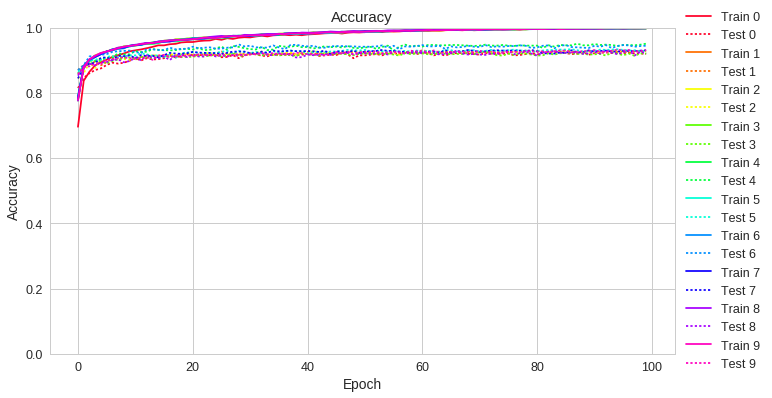

In [35]:
plot_acc(tophistory)

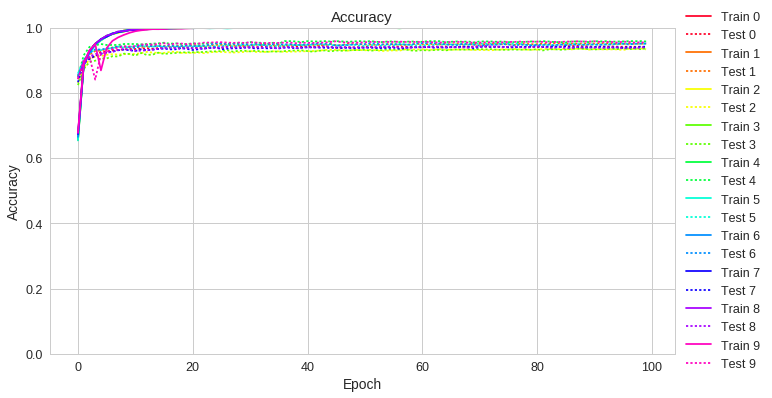

In [36]:
plot_acc(history)

In [37]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

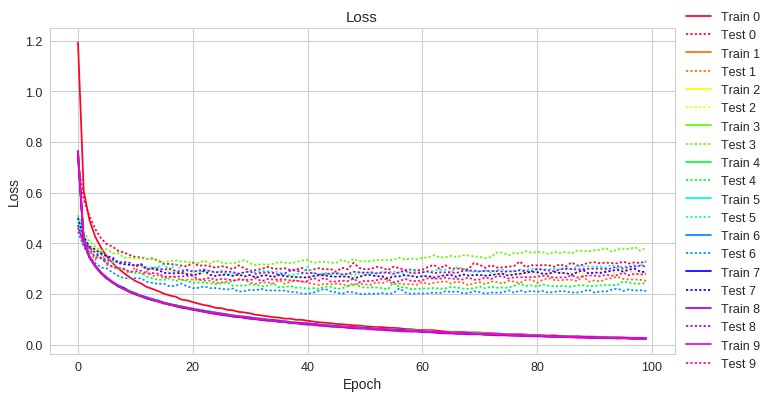

In [38]:
plot_loss(tophistory)

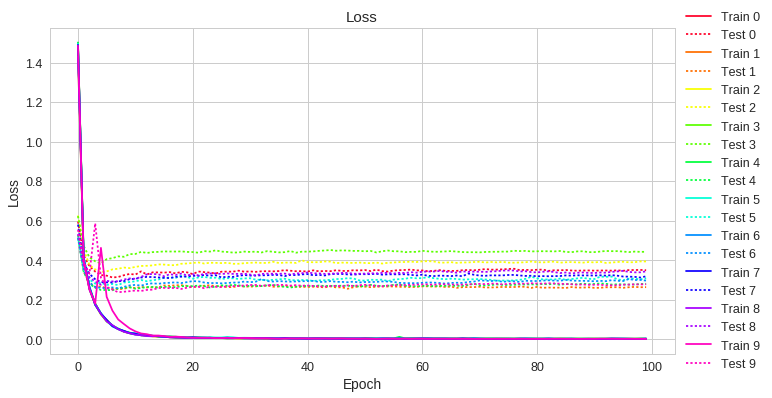

In [39]:
plot_loss(history)

Plotting the confusion matrix


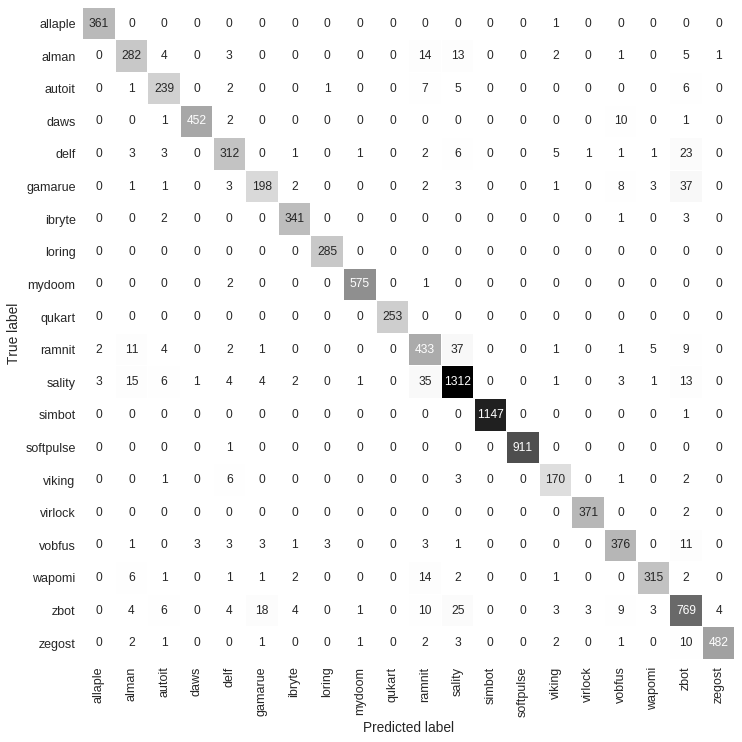

In [40]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


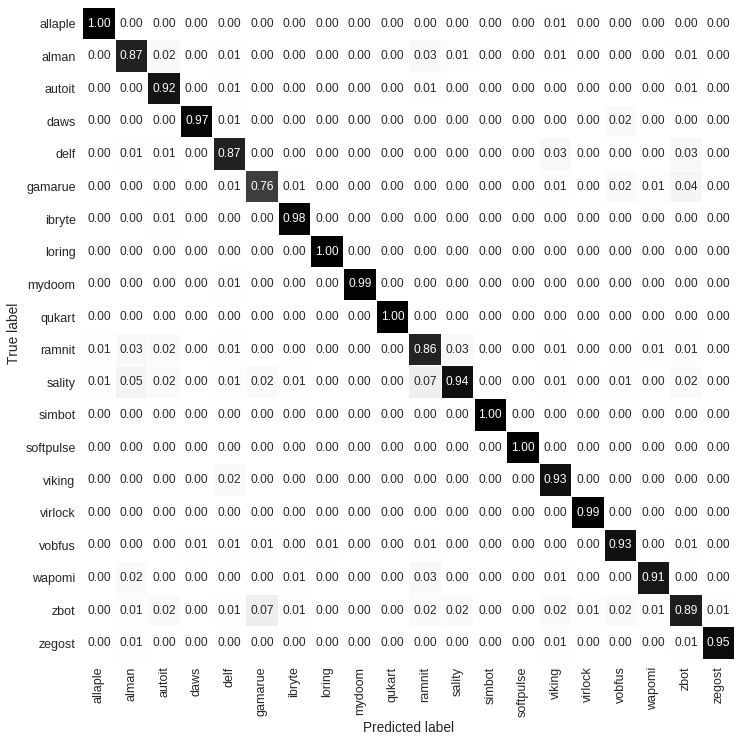

In [41]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
for h in tophistory:
    print(h.history)

{'acc': [0.69600526788341466, 0.83724758565373547, 0.86490342405618958, 0.88421861287059234, 0.89398595269465253, 0.90177787538156684, 0.91033801590799757, 0.9156057946089593, 0.92076382802388879, 0.92734855141317352, 0.93042142235259406, 0.93327480251062744, 0.93700614584654018, 0.94106672519754175, 0.9457857770496968, 0.94567603160667257, 0.94918788410886745, 0.95028533812046467, 0.95456540835751469, 0.95588235294117652, 0.9558823530458378, 0.95862598781317765, 0.96016242328288792, 0.9607111501840252, 0.96543020193151885, 0.96257682177348547, 0.96751536435469709, 0.96543020198384955, 0.96905179982440737, 0.97058823529411764, 0.96992976294995614, 0.97289288849868305, 0.97508779631255482, 0.97300263388937669, 0.9762949956625151, 0.9772827041264267, 0.97772168579386243, 0.97684372256365237, 0.9782704127473304, 0.97673397722528943, 0.97914837576821778, 0.98002633889376645, 0.98112379290536378, 0.98255048287971902, 0.98320895522388063, 0.98397717306339705, 0.98189201064021892, 0.984525899

In [43]:
for h in history:
    print(h.history)

{'acc': [0.66560579466129, 0.88696224758560138, 0.92581211594346324, 0.94820017569728643, 0.96422300273855077, 0.97453906935908696, 0.98035557517050864, 0.98518437225636524, 0.99111062335381916, 0.9928665496049166, 0.99330553127235233, 0.99462247585601404, 0.99571992976294998, 0.99615891132572432, 0.99747585601404742, 0.99714661984196662, 0.99824407374890256, 0.99802458296751539, 0.99890254609306406, 0.99912203687445122, 0.9990122914837577, 0.9990122914837577, 0.9993415276558385, 0.99923178226514486, 0.99923178226514486, 0.99890254609306406, 0.99956101843722567, 0.99956101843722567, 0.99978050921861283, 0.9996707638279192, 0.9990122914837577, 0.99879280070237053, 0.99945127304653203, 0.9993415276558385, 0.9990122914837577, 0.99945127304653203, 0.99956101843722567, 0.9996707638279192, 0.9993415276558385, 0.9996707638279192, 0.99978050921861283, 0.9993415276558385, 0.99956101843722567, 0.9996707638279192, 0.99945127304653203, 0.9996707638279192, 0.99978050921861283, 0.99978050921861283, 

In [44]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

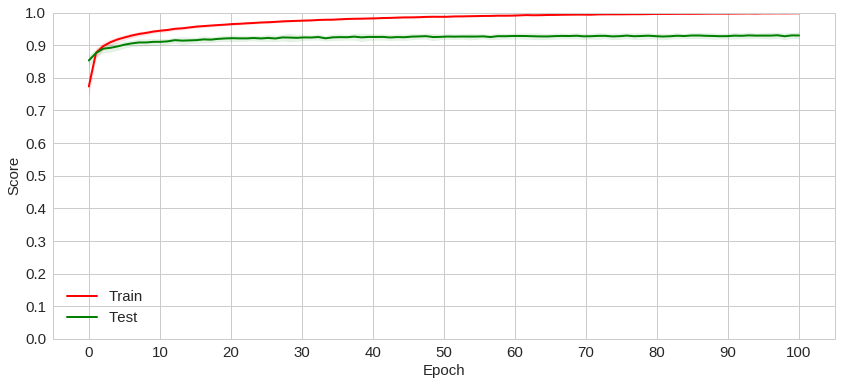

In [45]:
plot_mean_acc(tophistory)

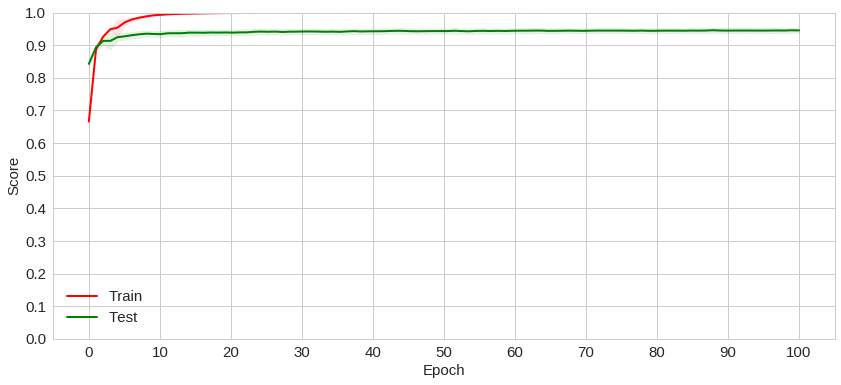

In [46]:
plot_mean_acc(history)

In [47]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

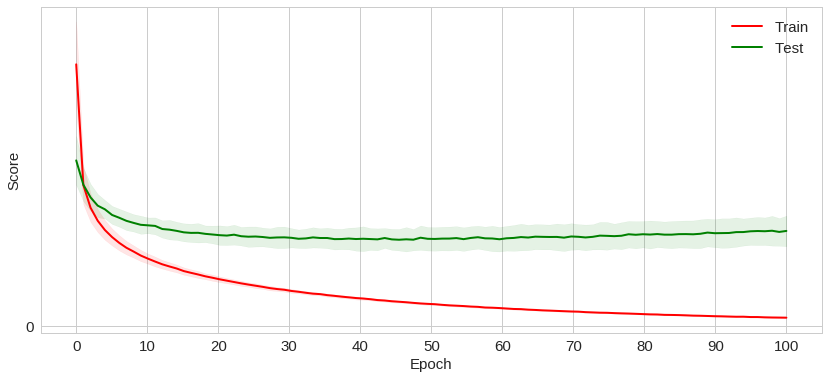

In [48]:
plot_mean_loss(tophistory)

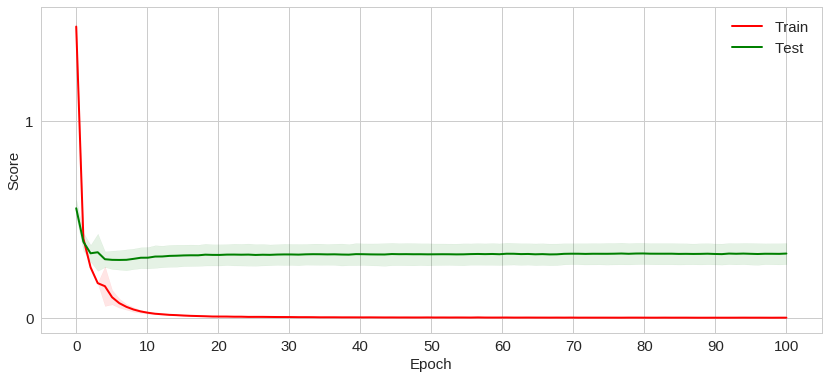

In [49]:
plot_mean_loss(history)

In [64]:
tophist = [{'acc': [0.69600526788341466, 0.83724758565373547, 0.86490342405618958, 0.88421861287059234, 0.89398595269465253, 0.90177787538156684, 0.91033801590799757, 0.9156057946089593, 0.92076382802388879, 0.92734855141317352, 0.93042142235259406, 0.93327480251062744, 0.93700614584654018, 0.94106672519754175, 0.9457857770496968, 0.94567603160667257, 0.94918788410886745, 0.95028533812046467, 0.95456540835751469, 0.95588235294117652, 0.9558823530458378, 0.95862598781317765, 0.96016242328288792, 0.9607111501840252, 0.96543020193151885, 0.96257682177348547, 0.96751536435469709, 0.96543020198384955, 0.96905179982440737, 0.97058823529411764, 0.96992976294995614, 0.97289288849868305, 0.97508779631255482, 0.97300263388937669, 0.9762949956625151, 0.9772827041264267, 0.97772168579386243, 0.97684372256365237, 0.9782704127473304, 0.97673397722528943, 0.97914837576821778, 0.98002633889376645, 0.98112379290536378, 0.98255048287971902, 0.98320895522388063, 0.98397717306339705, 0.98189201064021892, 0.98452589991220374, 0.98562335381913957, 0.98507462697033299, 0.98617208077260754, 0.98694029861212407, 0.98726953478420487, 0.98617208077260754, 0.98847673402950365, 0.98814749780509215, 0.98836698858647942, 0.98968393337946381, 0.98913520632133456, 0.99056189640035119, 0.99012291483757686, 0.98979367866549606, 0.99067164179104472, 0.99034240561896403, 0.99209833187006147, 0.99275680421422297, 0.99264705882352944, 0.991878841141005, 0.99363476744443313, 0.9918788410886743, 0.99275680421422297, 0.99396400351185255, 0.99429323968393324, 0.99330553127235233, 0.99396400361651382, 0.99462247585601404, 0.99440298507462688, 0.99506145741878838, 0.99462247585601404, 0.99582967515364351, 0.99593942054433715, 0.99637840210711148, 0.99637840210711148, 0.99539069359086918, 0.99571992976294998, 0.99659789288849865, 0.99648814749780512, 0.99615891132572432, 0.99703687445127309, 0.99670763827919229, 0.99659789288849865, 0.99681738366988581, 0.99692712906057945, 0.99670763838385368, 0.99758560150940234, 0.99780509218612823, 0.99813432835820892, 0.99769534679543459, 0.99725636523266026, 0.99813432835820892], 'loss': [1.1931563946005543, 0.60639834215601252, 0.49235396805408232, 0.42690779767191339, 0.38370035817688031, 0.3496735691500924, 0.32369497031156591, 0.30081599008838161, 0.2834330246415025, 0.26690631372244134, 0.25207584754901563, 0.2420472910364434, 0.22816707297204564, 0.22026626050105944, 0.21160252581990738, 0.20158458384010644, 0.19450468482994218, 0.19002081945708596, 0.17870832363485348, 0.17535735331835509, 0.16854286953950787, 0.16224349709432098, 0.15694514712395638, 0.15278580015536669, 0.14592789198068332, 0.14455640661392011, 0.13811084301692544, 0.13607634123843212, 0.13002209057271011, 0.127690039751716, 0.12387586808890183, 0.11856054499601459, 0.11566629726521481, 0.11261329410354018, 0.10912678294583723, 0.10730203964581501, 0.1033331901358344, 0.10336960520827529, 0.098792273031189523, 0.098589606406502397, 0.094920582022710892, 0.091949677753856665, 0.089059321450182388, 0.087319793897542755, 0.085180637676062765, 0.082344279543572707, 0.081069811459064903, 0.07927338643894058, 0.076707766127230514, 0.076093344663820103, 0.073203483874450873, 0.071632793348174642, 0.06998326569874104, 0.069761516495270098, 0.067319198736399286, 0.066811207083362148, 0.065397580662011262, 0.062282092470260335, 0.061814022669936609, 0.059262296830854259, 0.058213585531428989, 0.057949151500366149, 0.057704487176083806, 0.054461425921738249, 0.052851413531168394, 0.051202733229920985, 0.051925849653551515, 0.050653190454231008, 0.048846290339703516, 0.04888907704858847, 0.048782700906598433, 0.045860126738855984, 0.045764106622618261, 0.044798183738138722, 0.04310787645764682, 0.042414368441797745, 0.041551649143642976, 0.041734219742145737, 0.040546261434810431, 0.03901611260670753, 0.038228406807157528, 0.03707673268832587, 0.0364698026496083, 0.037130701763651894, 0.035307448440745695, 0.034961326520389586, 0.033815336957429984, 0.034234055060373261, 0.032578952623575373, 0.032404292064953572, 0.032065641177496017, 0.031317976521715668, 0.031051332852210362, 0.030133869253668059, 0.02991378396958819, 0.028755977067890348, 0.027932632295864523, 0.027519062151633616, 0.027952563236741459, 0.026350325007806021], 'val_acc': [0.814453125, 0.845703125, 0.8603515625, 0.8701171875, 0.875, 0.8857421875, 0.892578125, 0.8896484375, 0.892578125, 0.8984375, 0.90625, 0.8994140625, 0.90625, 0.90234375, 0.9033203125, 0.90625, 0.91796875, 0.908203125, 0.9130859375, 0.91796875, 0.916015625, 0.9150390625, 0.9169921875, 0.9150390625, 0.91796875, 0.9091796875, 0.91015625, 0.916015625, 0.90625, 0.9140625, 0.919921875, 0.91796875, 0.9140625, 0.912109375, 0.9169921875, 0.916015625, 0.916015625, 0.919921875, 0.9150390625, 0.9169921875, 0.919921875, 0.921875, 0.9130859375, 0.9150390625, 0.9169921875, 0.916015625, 0.921875, 0.91796875, 0.90625, 0.9150390625, 0.9150390625, 0.9169921875, 0.9189453125, 0.9150390625, 0.9208984375, 0.9208984375, 0.919921875, 0.921875, 0.9228515625, 0.9189453125, 0.921875, 0.921875, 0.9150390625, 0.919921875, 0.9140625, 0.9208984375, 0.921875, 0.9228515625, 0.919921875, 0.9189453125, 0.9169921875, 0.921875, 0.919921875, 0.9189453125, 0.919921875, 0.9208984375, 0.9150390625, 0.916015625, 0.9189453125, 0.921875, 0.9169921875, 0.9228515625, 0.923828125, 0.9248046875, 0.9248046875, 0.921875, 0.9189453125, 0.919921875, 0.9248046875, 0.9169921875, 0.921875, 0.9228515625, 0.923828125, 0.921875, 0.921875, 0.921875, 0.9228515625, 0.9208984375, 0.9208984375, 0.9189453125], 'val_loss': [0.72358726430684328, 0.57267177198082209, 0.50763295777142048, 0.45724060456268489, 0.42107028188183904, 0.39733102009631693, 0.38770655379630625, 0.37102683272678405, 0.36459611816098914, 0.35426085343351588, 0.34674157909466885, 0.34531529722153209, 0.33894889141083695, 0.34039625496370718, 0.33288477835594676, 0.31936706056876574, 0.31944505649153143, 0.31624276087677572, 0.31256872326048324, 0.30940444872248918, 0.32449257512053009, 0.31228129194641951, 0.31380268378416076, 0.30982840264914557, 0.30438314744242234, 0.31058123390539549, 0.30553420685464516, 0.29865529824746773, 0.31343268964701565, 0.30195094908776809, 0.29289557375159347, 0.29498658663942479, 0.29879917756625218, 0.30777462862897664, 0.30116558203008026, 0.29885968306552968, 0.30269408001913689, 0.29463624639538466, 0.29702452115998312, 0.3036949126599211, 0.292674880274717, 0.29739682614672347, 0.3025534277803672, 0.29743252377375029, 0.29948061817412963, 0.2883304106999276, 0.30393207782617537, 0.29784893275791546, 0.32352253488079441, 0.30347849621557543, 0.29831911082874285, 0.29885996766188327, 0.30775925564557838, 0.30410383399976126, 0.29423517295617785, 0.30846836078308115, 0.30194233859674569, 0.29536839709453488, 0.29733560325985309, 0.29371222805730213, 0.29611390490299527, 0.30720203758392017, 0.31574076127799344, 0.29996885767150161, 0.31457125166252808, 0.29960829789752097, 0.30140260447205947, 0.29882841381004255, 0.29740337680914308, 0.32281530497130007, 0.31572396004366965, 0.30381996851474469, 0.31454416522888096, 0.30473188551422936, 0.30560227899968595, 0.30812074655420929, 0.31108428590346193, 0.32937107910152008, 0.30638243204680293, 0.31400264574085668, 0.31361408699694948, 0.31433677186578279, 0.31433402811182987, 0.30785078019869161, 0.31782938290871243, 0.30927715416737556, 0.32490531149016988, 0.31276921009532543, 0.31639663137985963, 0.32357661226353684, 0.32586381065107162, 0.32207409276435328, 0.3245487397953184, 0.32259057095347998, 0.32140639300013163, 0.32808120240815697, 0.32080144845457426, 0.32553763387807066, 0.32268232747750858, 0.33040294332920439]},
{'acc': [0.7831906955807727, 0.88007461067247417, 0.90125082300136772, 0.91002852772316545, 0.91957428150855058, 0.92615755988967141, 0.93065613351266896, 0.93789773983261626, 0.93987272338749994, 0.94338380531807442, 0.94448101839685428, 0.94941847706824667, 0.95194206725407882, 0.95424621470643678, 0.95633091966075701, 0.95995172262453365, 0.95962255888401693, 0.96379196849182192, 0.9635725258760659, 0.96434057493965331, 0.967741935483871, 0.96609611597033951, 0.96620583717357911, 0.96905859136152406, 0.97048496827237929, 0.97180162387535662, 0.97278911573781712, 0.97344744349352641, 0.9749835418038183, 0.97542242703533022, 0.97640991889779072, 0.97553214843476688, 0.97761685328444869, 0.97827518104015798, 0.97937239411893795, 0.97871406627167001, 0.98014044336564243, 0.98112793504498574, 0.98035988607295699, 0.98112793504498574, 0.98255431204739963, 0.9829931973704702, 0.98310291858678955, 0.98343208251042358, 0.98463901689708144, 0.98518762343647137, 0.98639455782312924, 0.98727232828615319, 0.98705288567039717, 0.9873820495940312, 0.98650427913100724, 0.98782093482554312, 0.98847926267281105, 0.98935703322739355, 0.98902786921220098, 0.98869870538012561, 0.98946675444371301, 0.99067368892192942, 0.99034452490673686, 0.98968619705946892, 0.9911125740618828, 0.99231950854009932, 0.99177090200070939, 0.99253895106429668, 0.99330700021944263, 0.9929778362958086, 0.9938556068503912, 0.99429449199034448, 0.99308755760368661, 0.99440421329822248, 0.99451393460610049, 0.99539170516068298, 0.99528198376124644, 0.99473337722185651, 0.99506254114549042, 0.99517226254492708, 0.99484309852973452, 0.99374588545095455, 0.99681808207153833, 0.99561114768488035, 0.99583059030063636, 0.99594031160851437, 0.99659863945578231, 0.99605003291639238, 0.99670836094677751, 0.99670836076366032, 0.99692780337941633, 0.99659863945578231, 0.99736668861092825, 0.99725696730305025, 0.99736668861092825, 0.99758613122668427, 0.99758613122668427, 0.99714724599517224, 0.99824445907395221, 0.99758613122668427, 0.99769585253456217, 0.99824445907395221, 0.99802501645819619, 0.99846390168970811], 'loss': [0.7553376727180573, 0.41495971217839794, 0.35142575588591507, 0.31131529404532632, 0.2861454843794643, 0.26466354775813317, 0.24696672468272274, 0.23399160108807998, 0.22361585822235158, 0.2114454097906853, 0.20488349397192404, 0.1937635667787222, 0.18566457609060905, 0.17878264322507426, 0.17341543259276929, 0.16498193167442682, 0.16189217341817311, 0.15290967488016818, 0.14909286561610277, 0.14565749362434816, 0.13943367569311058, 0.1376514920009603, 0.13491706178982008, 0.12974623178857603, 0.12525821852401497, 0.12198075464754375, 0.11944295167072787, 0.11484866848778301, 0.11295924276736435, 0.10861051283794745, 0.10572752334947567, 0.10324356400763253, 0.1003940969882159, 0.098717972806260226, 0.096010500269649524, 0.095293980398368019, 0.092981805802143686, 0.090108798627143036, 0.088634592773413637, 0.085468956638215035, 0.083443546735955249, 0.081965019256497837, 0.079474846616841885, 0.078107292546641546, 0.076363467811452521, 0.073617615065659406, 0.073110141452759125, 0.070630446503121572, 0.069320963749190764, 0.06709297431278495, 0.067418936804339163, 0.064871382758770177, 0.063056419123048352, 0.061311396608521126, 0.061657347679399781, 0.060474385160585752, 0.059187371551088004, 0.056525750081215298, 0.057046790643038657, 0.055951035172581043, 0.053958958031604339, 0.05202690568348544, 0.051545300912328632, 0.050862885050235257, 0.049396635831671115, 0.047943122192010669, 0.047132242087578075, 0.046411246463937642, 0.045207757144734767, 0.045261280199143744, 0.042919394980142432, 0.042599727647959051, 0.041852698006783894, 0.041056322105129169, 0.040620148973243134, 0.040742487587575878, 0.039610967653586279, 0.039196581109893908, 0.036611650134392847, 0.036220479801555516, 0.035385177966754167, 0.035828536687411053, 0.034670853604343292, 0.034032766648586808, 0.033383788578155035, 0.033020974713013261, 0.031584421849208941, 0.033131831528123129, 0.030405619056821393, 0.030328774557828852, 0.029766977024635568, 0.029940592418127424, 0.029022848635784415, 0.029036924010602521, 0.027486095681340188, 0.027608383140374046, 0.026931116427749636, 0.026331138147814955, 0.025916938643615602, 0.025192394920489702], 'val_acc': [0.86986301124912424, 0.88551858761539193, 0.88747553746061081, 0.89628179969153055, 0.88454011496732377, 0.89432485252910399, 0.90508806192245039, 0.91193737699094346, 0.90704500908487695, 0.91585127038265157, 0.90215264117881044, 0.9099804298285169, 0.91291585057215685, 0.91487279680143829, 0.91291585057215685, 0.91487279680143829, 0.91291585057215685, 0.91487279680143829, 0.91585127131579669, 0.92074363828871819, 0.91682974221421776, 0.91487279680143829, 0.92172211093678635, 0.91878669205943664, 0.91878669112629152, 0.92661447884285286, 0.91878669205943664, 0.92172211186993147, 0.91682974303071985, 0.9197651647075048, 0.91976516284121457, 0.91976516564064992, 0.92367905996550315, 0.91682974489701008, 0.91780821847822336, 0.92074363735557307, 0.91976516564064992, 0.92172211186993147, 0.91780821847822336, 0.9236790571660678, 0.9256360061947847, 0.92367905996550315, 0.92074363828871819, 0.92074363828871819, 0.92172211093678635, 0.91780821754507824, 0.92270058451799963, 0.92367905903235803, 0.92563600526163958, 0.9246575316804263, 0.92661447977599798, 0.92172211186993147, 0.9187866901931464, 0.92367905809921291, 0.91976516284121457, 0.92465753261357142, 0.92367905903235803, 0.92270058545114475, 0.9246575316804263, 0.92563600526163958, 0.93052837503399632, 0.92759295242406614, 0.92465753261357142, 0.92661447790970775, 0.92367905809921291, 0.92661447977599798, 0.92465753261357142, 0.9246575316804263, 0.92759295335721126, 0.92367905903235803, 0.9256360061947847, 0.9256360061947847, 0.92661447977599798, 0.92172211186993147, 0.9256360061947847, 0.92661447884285286, 0.9246575316804263, 0.92661447884285286, 0.92954989865334769, 0.92661447977599798, 0.92661447884285286, 0.92759295055777591, 0.92759295242406614, 0.92661447977599798, 0.92661447977599798, 0.92954989958649281, 0.92759295242406614, 0.9236790571660678, 0.92661447884285286, 0.92857142600527953, 0.92367905809921291, 0.92563600526163958, 0.92661447977599798, 0.9285714250721343, 0.9256360061947847, 0.92759295335721126, 0.92270058545114475, 0.92759295242406614, 0.92857142600527953, 0.9256360061947847], 'val_loss': [0.4720916965586332, 0.38925280181395799, 0.3718199979535754, 0.3348908001691861, 0.37185580039910843, 0.31609578274642419, 0.30741822509616323, 0.29790466232134172, 0.29850222149211364, 0.28176674090777826, 0.30545810313344934, 0.27647734268654117, 0.28994194196569945, 0.27157883018386458, 0.27428699812602159, 0.26296084013324661, 0.26828359386750628, 0.26631615185515989, 0.25579161781256332, 0.25726387238607479, 0.25740606380068859, 0.25694117009814704, 0.25258871297481417, 0.25315939507459939, 0.244535531735671, 0.24598048520028415, 0.25007808280274008, 0.2505108433795652, 0.25953350589772844, 0.25674320601196615, 0.24523961936340552, 0.24094781290499198, 0.24453466969092036, 0.24720280736852474, 0.24224895118770359, 0.25606952813761985, 0.24054477865390347, 0.24858936149291622, 0.25348673641787378, 0.24997453720704332, 0.24551088955625164, 0.23944720380835657, 0.2360624638194703, 0.24085574439196408, 0.23839884340296519, 0.24139755109731481, 0.23844758228174687, 0.23275055730425609, 0.23629630356161344, 0.24032972420797247, 0.23856297944838259, 0.23682578211675767, 0.24711413973752855, 0.2429546170736756, 0.25163668526496935, 0.23914141746451112, 0.2412910125899054, 0.23860377008929201, 0.23882268031274467, 0.23669499002849054, 0.24811317724150236, 0.23896611772043405, 0.24458943010403988, 0.24743473651356915, 0.25103058519343974, 0.24174883553597423, 0.24906813749522264, 0.24609950121568239, 0.23527497744929035, 0.24248984057208844, 0.24711269543078135, 0.23876802563930882, 0.24972376774092306, 0.24718306985102345, 0.24098140255030001, 0.25276769776867314, 0.24945698839840352, 0.24398528004775721, 0.25544036054517733, 0.25739865004253132, 0.24438241651052073, 0.25691364550144719, 0.26300662678590436, 0.25560579401515071, 0.25412141430708163, 0.25729296395057699, 0.25619284250759139, 0.25159621185398934, 0.27065202834490942, 0.24890941763771154, 0.25398430878034733, 0.24988495497372279, 0.25932390669644617, 0.26351072062951136, 0.26824667100648697, 0.25995979613638237, 0.2578111757141035, 0.25775718692337984, 0.25659930090277389, 0.25278147642408771]},
{'acc': [0.78674857401439835, 0.88295304968776589, 0.89929793779658562, 0.91553312866977554, 0.92123738492251805, 0.92716103575113518, 0.93330408084178085, 0.93845985102099039, 0.94076349281229021, 0.94416410711680965, 0.9464677490127249, 0.94800351036384789, 0.95151382190399703, 0.95392716103554187, 0.95557261967460227, 0.95941202281702498, 0.95952172010496239, 0.96303203159280382, 0.96358051782325993, 0.96610355434735751, 0.96632294866169377, 0.96818780171970575, 0.96895568242142105, 0.96983326020184291, 0.97169811320754718, 0.97301448008741087, 0.97301448008741087, 0.97498903032874473, 0.97487933304080732, 0.97597630544941172, 0.97696358062238642, 0.97674418604651159, 0.97948661693725314, 0.97948661693725314, 0.97904782799473455, 0.98124177275963553, 0.98200965340904312, 0.98080298376480912, 0.98157086441421681, 0.98354541465555068, 0.98321632294866168, 0.98551996494919236, 0.98475208429978467, 0.98628784559859994, 0.98672663459342635, 0.98617814836297024, 0.98716542353594494, 0.98782360689741522, 0.98859148749451509, 0.98727512071926693, 0.98727512071926693, 0.9882623957876262, 0.98881088207038992, 0.9891399737249712, 0.98979815713874919, 0.99067573497147876, 0.99056603773584906, 0.99089512944273805, 0.99199210179903463, 0.99001755155770077, 0.99232119350592363, 0.99308907420763903, 0.99122422114962705, 0.99089512944273805, 0.99221149632260175, 0.99319877139096091, 0.99319877139096091, 0.99462483545414659, 0.99363756033347961, 0.99462483550645431, 0.99319877139096091, 0.9941860465116279, 0.99539271615586189, 0.99550241333918388, 0.99495392716103559, 0.99517332163229488, 0.99495392716103559, 0.99572180781044317, 0.99462483545414659, 0.99627029398859146, 0.99539271610355418, 0.99670908293111016, 0.99583150504607287, 0.99670908293111016, 0.99659938569548046, 0.99648968845985086, 0.99670908293111016, 0.99670908293111016, 0.99714787187362874, 0.99670908293111016, 0.99692847740236945, 0.99692847740236945, 0.99758666081614744, 0.99714787187362874, 0.99780605528740673, 0.99758666086845516, 0.99758666081614744, 0.99725756910925845, 0.99780605528740673, 0.99736726634488815], 'loss': [0.75587032933463227, 0.40797587279794301, 0.34877136010985565, 0.30750497745390054, 0.28138872170301843, 0.26123298836047315, 0.24357685789354749, 0.23125167861221232, 0.21916780405370956, 0.20779523122671562, 0.19862008454730082, 0.19064838693572431, 0.18448228322005469, 0.17514318884556729, 0.16924429100665569, 0.16155747898632417, 0.15878599899125864, 0.15115533859524982, 0.1476889682174409, 0.1429231691486012, 0.13842153379848099, 0.13315816978160203, 0.1318330720962794, 0.12526823512591934, 0.12257618765531009, 0.11866666676379338, 0.11578923102571233, 0.11213346354633949, 0.10932906731773542, 0.10891214843484695, 0.10508777780483668, 0.10262906206130144, 0.099459989312684766, 0.096959142871740456, 0.094115276633385453, 0.091642309191092008, 0.089006849800405297, 0.088109746339970804, 0.08599908694546439, 0.0835704083124134, 0.082014052587193118, 0.079111025685435488, 0.077605756248963306, 0.075440980935368745, 0.073327062670313095, 0.073006300666762211, 0.07053737377665345, 0.069747367315566453, 0.066772262563748339, 0.066274041183269974, 0.066148390701696924, 0.065417865605901446, 0.063172145854124326, 0.062715620953244774, 0.059415449132099125, 0.058459395631827407, 0.058092619099144663, 0.05665717025815839, 0.055100630381164604, 0.054601773881190384, 0.052627077851707657, 0.051841382844477382, 0.051431355421717832, 0.050156869216543797, 0.050329771322762562, 0.048382182194867278, 0.047447797190520571, 0.045398609321229341, 0.045480516654393913, 0.04324196893337684, 0.044917861044655352, 0.04275160276965647, 0.040548418568853432, 0.040541488222839962, 0.040284496748810954, 0.040507829724800798, 0.039136994612117566, 0.036960724572855007, 0.037603086340369858, 0.036199359036491671, 0.035462702679668091, 0.034625193917369464, 0.034180816529402872, 0.034137606655932823, 0.033700149432772761, 0.033177200925486192, 0.032180838586011444, 0.031678812598753207, 0.031113744458774559, 0.030130139173643142, 0.030130475278929064, 0.028904825099182005, 0.028390872680033284, 0.028835572781284007, 0.027772449849466842, 0.027421915399408383, 0.027408725466822756, 0.027158679902396635, 0.026250885149767231, 0.025844034889019034], 'val_acc': [0.84411765266867245, 0.86078431933533917, 0.89215686741997213, 0.87647059220893708, 0.90000000654482371, 0.90784314379972575, 0.91176471149220184, 0.90098039683173681, 0.90392157517227467, 0.90098039613050573, 0.90588235761605052, 0.90980392811345123, 0.91372549580592732, 0.91372549580592732, 0.91568628011965281, 0.9107843193353391, 0.91862745659024103, 0.91666666970533484, 0.91862745565526627, 0.91862745659024103, 0.91764706443337829, 0.9166666706403096, 0.91960784874710377, 0.92352941643957998, 0.91274510201285863, 0.91960784874710377, 0.91764706186219758, 0.91960784617592306, 0.92254902521769211, 0.91666666970533484, 0.91862745401906032, 0.92450980859644272, 0.92647059384514308, 0.91568627754847209, 0.91666666970533484, 0.92450980696023677, 0.92254902428271723, 0.92450980696023677, 0.91764706186219758, 0.92156863048964854, 0.9205882383327858, 0.92843137815886856, 0.92450980696023677, 0.92352941480337403, 0.92352941480337403, 0.92352941480337403, 0.92549019911709951, 0.92647059033898749, 0.92745098343082499, 0.92254902264651129, 0.9205882383327858, 0.92352941480337403, 0.92450980696023677, 0.92254902264651129, 0.92450980696023677, 0.92450980696023677, 0.9166666706403096, 0.92647059033898749, 0.92254902264651129, 0.92352941386839926, 0.92156863048964854, 0.92254902264651129, 0.92352941480337403, 0.92254902264651129, 0.92647059127396225, 0.92352941480337403, 0.92549019911709951, 0.92843137558768773, 0.92647059127396225, 0.92450980696023677, 0.92549019911709951, 0.92352941480337403, 0.92745098343082499, 0.92549019911709951, 0.92450980696023677, 0.92549019911709951, 0.92647059127396225, 0.92254902264651129, 0.92254902264651129, 0.92647059127396225, 0.92843137558768773, 0.92450980696023677, 0.92549019911709951, 0.92843137558768773, 0.92450980696023677, 0.92647059220893713, 0.92352941480337403, 0.92549019911709951, 0.92352941480337403, 0.92549019911709951, 0.92450980696023677, 0.92549019911709951, 0.92647059220893713, 0.92549019911709951, 0.93039215896643845, 0.92352941480337403, 0.92843137558768773, 0.92745098343082499, 0.92843137558768773, 0.92745098343082499], 'val_loss': [0.4988422800512875, 0.43786444757498949, 0.39375487951671378, 0.37829936602536368, 0.35841681288153515, 0.34286096773895564, 0.32830124471117467, 0.33194290863386555, 0.32042022015826377, 0.3224519212018041, 0.31369008994569963, 0.31633352410851739, 0.30031467615535445, 0.29607477749825695, 0.29603536367854649, 0.29270502401552362, 0.2901856113152177, 0.28999575975113639, 0.28301629939792206, 0.28299935319479191, 0.27841417630586551, 0.28596357935126504, 0.27673088035308846, 0.27438801080718928, 0.28855816609427043, 0.27565720643409913, 0.27959595155518724, 0.27815845481065266, 0.27009446078947946, 0.2758143757396907, 0.27250219737636105, 0.27262541238656818, 0.26841952600333768, 0.28121867973868753, 0.27613282263753752, 0.27032254355338714, 0.26213724032391372, 0.26546001513397283, 0.27088689992350401, 0.26662384081704943, 0.26656097473357532, 0.26935251907436358, 0.26758799756073631, 0.27427541679501827, 0.26727201827646546, 0.27088420094063909, 0.27156521787081717, 0.2651990260924304, 0.26822130592978177, 0.27667877474964103, 0.27674352301229888, 0.28275212130198873, 0.26826977499820037, 0.27702870027153004, 0.26649653494641112, 0.27552025001769997, 0.28683686343971276, 0.26942072664387523, 0.27467638573280589, 0.2742870803169139, 0.27289183945212442, 0.26729808154027435, 0.27469586810044599, 0.27656618229538094, 0.26762138989151402, 0.28943340513117921, 0.27251845605445424, 0.27089373211686812, 0.26990169573520473, 0.27825718320616266, 0.26851953515428001, 0.27579687528424057, 0.27174304221567297, 0.28081140026413637, 0.27975538399826061, 0.28076139868290723, 0.27693665068272466, 0.27996042529429199, 0.28481478858179887, 0.27837411302014015, 0.28265205272125288, 0.27860290980749469, 0.27797078628049632, 0.28111735185980341, 0.28744893708242347, 0.28366959266362862, 0.28103480540619996, 0.28542892785843316, 0.28046993616552951, 0.28373031959784512, 0.286057824670998, 0.2902288494410516, 0.29246083001843565, 0.28380007260118373, 0.28787010882008995, 0.29119703940277936, 0.29114977047178331, 0.2868774613458549, 0.28398340650277459, 0.28318521181969186]},
{'acc': [0.77631578947368418, 0.88212719298245612, 0.90098684210526314, 0.91217105263157894, 0.92182017543859651, 0.9263157894736842, 0.93256578947368418, 0.93618421052631584, 0.94276315789473686, 0.94385964912280707, 0.94725877192982455, 0.94780701754385965, 0.95307017543859651, 0.95339912280701755, 0.95625000000000004, 0.95975877192982462, 0.96118421052631575, 0.96337719298245617, 0.96436403508771928, 0.96666666666666667, 0.96710526315789469, 0.96885964912280698, 0.97006578947368416, 0.97050438596491229, 0.97083333333333333, 0.97127192982456145, 0.97401315789473686, 0.97445175438596487, 0.97467105263157894, 0.97456140350877196, 0.97686403508771935, 0.9770833333333333, 0.97872807017543861, 0.97850877192982455, 0.97817982456140351, 0.98114035087719298, 0.98135964912280704, 0.98245614035087714, 0.98135964912280704, 0.98344298245614037, 0.98366228070175443, 0.98508771929824557, 0.98475877192982453, 0.98388157894736838, 0.98519736842105265, 0.98530701754385963, 0.9860745614035088, 0.98782894736842108, 0.98739035087719296, 0.98815789473684212, 0.9888157894736842, 0.98958333333333337, 0.98859649122807014, 0.99024122807017545, 0.98969298245614035, 0.98947368421052628, 0.99057017543859649, 0.99133771929824566, 0.98969298245614035, 0.99144736842105263, 0.9916666666666667, 0.99243421052631575, 0.99265350877192982, 0.9916666666666667, 0.99243421052631575, 0.99265350877192982, 0.99342105263157898, 0.99353070175438596, 0.99407894736842106, 0.99276315789473679, 0.99407894736842106, 0.99451754385964908, 0.99506578947368418, 0.99484649122807023, 0.99495614035087721, 0.99528508771929824, 0.99572368421052626, 0.99484649122807023, 0.99506578947368418, 0.99605263157894741, 0.9966008771929824, 0.99528508771929824, 0.99638157894736845, 0.99616228070175439, 0.99616228070175439, 0.99649122807017543, 0.99703947368421053, 0.99682017543859647, 0.99703947368421053, 0.99638157894736845, 0.99703947368421053, 0.99747807017543855, 0.99725877192982459, 0.9966008771929824, 0.99736842105263157, 0.99703947368421053, 0.99824561403508771, 0.99747807017543855, 0.99791666666666667, 0.99791666666666667], 'loss': [0.76558142544930441, 0.41088476003262037, 0.34572004027533948, 0.30795614290655704, 0.28198564507459339, 0.26373894585852037, 0.24425678373428814, 0.23087582240502039, 0.21927640605391119, 0.20887532851152252, 0.19824652865267636, 0.19032545845236695, 0.18240173825046471, 0.17613988947450068, 0.17128678298833078, 0.16244869467459228, 0.1569842160270925, 0.15298340017335457, 0.14616454369143436, 0.14121686505121098, 0.1382545892345278, 0.13433571988553331, 0.13036978835599464, 0.1276683642676002, 0.12399893690619553, 0.11957558945082782, 0.11486938020639252, 0.11201710052657546, 0.11205387567741829, 0.10747882132990319, 0.10395853463233563, 0.10324550898451554, 0.098389299174672679, 0.095154037130506422, 0.09616939648985863, 0.091369053198580158, 0.08973210237005301, 0.087946258589886778, 0.085683117950694609, 0.082148767680975426, 0.081660262861272745, 0.080512427329494249, 0.076765671659979898, 0.076987774905405551, 0.073195860953184602, 0.073652474176988267, 0.070875537395477292, 0.069292512444550536, 0.06703319951499763, 0.065978347627740158, 0.065364122168536778, 0.062836318436944691, 0.06095568971675739, 0.059842575145395177, 0.059172443287414417, 0.05920308469549606, 0.056385421831356849, 0.054596033705431118, 0.0557626573336229, 0.052948207774183208, 0.052926855913379735, 0.050899095584948859, 0.050033645841636158, 0.04967336206321131, 0.047805169446949375, 0.046745248831677855, 0.046013977339393212, 0.045169707015156747, 0.043939283411753807, 0.043840944878103437, 0.042107717483712913, 0.041306475000946148, 0.040682018139775386, 0.040476294567710472, 0.040105054994816321, 0.038095545412547754, 0.037521372598252799, 0.03767628127937777, 0.036683047968044613, 0.036182756506298715, 0.03405005514229599, 0.034529270702286771, 0.032889265272962417, 0.033475005731248016, 0.032589366839250976, 0.031785363109226812, 0.030879502279455202, 0.030781952422439005, 0.030038787842842571, 0.029544546837477308, 0.028852960114416324, 0.028236804124817515, 0.02800407684816603, 0.029552761350938102, 0.027040438576225651, 0.027357218293636514, 0.025593026550976852, 0.025191868197891796, 0.026379473010698953, 0.02506245253117461], 'val_acc': [0.85629921259842523, 0.88188976377952755, 0.88681102409137513, 0.89763779809155797, 0.89665354330708658, 0.89074803431203042, 0.89763779527559051, 0.9025590555874381, 0.90748031777659743, 0.90846456974510137, 0.90354330990258169, 0.91043307368210924, 0.90846456974510137, 0.9064960658080935, 0.90846456974510137, 0.9094488217136053, 0.91043307368210924, 0.91240157761911711, 0.9094488217136053, 0.91043307086614178, 0.91043307368210924, 0.91437008155612498, 0.91141732565061317, 0.91437008155612498, 0.91633858549313285, 0.91240157761911711, 0.91437007874015752, 0.92027559336714859, 0.91240157761911711, 0.91437007874015752, 0.92125984533565253, 0.91830708943014072, 0.91535433352462892, 0.91732283464566933, 0.91732283464566933, 0.91437008155612498, 0.91732283464566933, 0.91535433070866146, 0.91240157480314965, 0.92125984251968507, 0.91830708661417326, 0.91633858267716539, 0.91535433070866146, 0.922244094488189, 0.9192913385826772, 0.92027559055118113, 0.92027559055118113, 0.91830708661417326, 0.91535433070866146, 0.9192913385826772, 0.92125984251968507, 0.9192913385826772, 0.91929134139864466, 0.91830708943014072, 0.92027559055118113, 0.91732283511499724, 0.91437007920948543, 0.922244094488189, 0.91830708661417326, 0.92125984251968507, 0.92125984251968507, 0.91830708661417326, 0.91830708708350117, 0.92125984298901298, 0.92027559102050904, 0.91830708708350117, 0.91929133905200511, 0.9192913385826772, 0.92322834692602085, 0.91830708661417326, 0.92421259842519687, 0.92618110236220474, 0.922244094488189, 0.91535433117798937, 0.91437007920948543, 0.92027559102050904, 0.9163385831464933, 0.92125984251968507, 0.92027559102050904, 0.91732283464566933, 0.91437007920948543, 0.91535433117798937, 0.92125984251968507, 0.91732283511499724, 0.92125984251968507, 0.922244094488189, 0.92125984251968507, 0.91929133905200511, 0.92027559102050904, 0.91732283464566933, 0.91830708708350117, 0.91929133905200511, 0.91437007920948543, 0.92322834645669294, 0.92027559055118113, 0.91535433070866146, 0.92027559055118113, 0.9133858272409815, 0.92125984251968507, 0.92027559102050904], 'val_loss': [0.51203484381512399, 0.44819464254391006, 0.40656678815643621, 0.3882555982288648, 0.3705584980899424, 0.37749443593706322, 0.36094843846283792, 0.36177464973504148, 0.34378148897323668, 0.34419072515103877, 0.34190952879428044, 0.34158841155352088, 0.33780386900404602, 0.34350897285969945, 0.32781898029749906, 0.3254948243091807, 0.33120092540598056, 0.3332589066085061, 0.32872031371321853, 0.32765427664816965, 0.32199272691954189, 0.32314451779862208, 0.33259024414211863, 0.31906557260044505, 0.33236389231637092, 0.32485068464967032, 0.3215409316412195, 0.32134918550920388, 0.32683511953764249, 0.33479706620830513, 0.32096542787232152, 0.31456718154940899, 0.31810150543084792, 0.31624478964487046, 0.319513826134182, 0.32686099715578537, 0.32432372035920681, 0.32172399221215486, 0.32614471572432963, 0.332526586370957, 0.33503602669935484, 0.32345415947694828, 0.32717091545616606, 0.32672976004853516, 0.3242134571558517, 0.32348788200279949, 0.33673873797240556, 0.32419448698720504, 0.33801472036343977, 0.32981394055252711, 0.32905727680293589, 0.33006796829357071, 0.33530295397774645, 0.33458050296941633, 0.33391068622494652, 0.335599778153027, 0.34358338688284351, 0.3360046921889151, 0.3406025226858484, 0.33850018731038833, 0.34316364600594473, 0.34509183110038594, 0.3535165726918178, 0.34514109054416481, 0.34526568810330838, 0.35085398325518186, 0.34635595236992001, 0.35358006740057674, 0.35269611575168658, 0.34880376477094688, 0.34691642963498881, 0.34226165981491197, 0.34668988950396329, 0.36401037002332037, 0.36435611773567944, 0.35262297575754353, 0.36306503335484691, 0.35967410240390757, 0.36905845145228106, 0.363483059825009, 0.36644638038213334, 0.36518234702908364, 0.35827171832549831, 0.36731668113881866, 0.36212870403945513, 0.36677032044199437, 0.36108031884400338, 0.37186331453356286, 0.37050308526485476, 0.36876356520161341, 0.37280645951138619, 0.37511075904379637, 0.38106421401786839, 0.367223206821431, 0.37648700845354649, 0.37941372435024973, 0.3776494303220379, 0.38526853590234728, 0.37161646371166035, 0.38251360860684103]},
{'acc': [0.78442982456140353, 0.87982456140350873, 0.89967105263157898, 0.91052631578947374, 0.91896929824561402, 0.92697368421052628, 0.93070175438596492, 0.93508771929824563, 0.93837719298245614, 0.94232456140350873, 0.94605263157894737, 0.94813596491228069, 0.949780701754386, 0.95010964912280704, 0.95241228070175443, 0.95800438596491233, 0.95877192982456139, 0.95745614035087723, 0.96063596491228065, 0.96162280701754388, 0.96458333333333335, 0.96425438596491231, 0.96787280701754386, 0.96644736842105261, 0.96743421052631584, 0.96973684210526312, 0.96907894736842104, 0.97280701754385968, 0.97456140350877196, 0.97401315789473686, 0.9754385964912281, 0.9754385964912281, 0.97631578947368425, 0.97828947368421049, 0.97839912280701757, 0.97719298245614039, 0.98168859649122808, 0.98092105263157892, 0.98037280701754381, 0.98278508771929829, 0.98245614035087714, 0.98432017543859651, 0.98344298245614037, 0.98442982456140349, 0.98366228070175443, 0.98497807017543859, 0.98629385964912286, 0.98728070175438598, 0.98640350877192984, 0.9866228070175439, 0.9860745614035088, 0.98804824561403504, 0.98793859649122806, 0.98903508771929827, 0.98903508771929827, 0.99046052631578951, 0.99013157894736847, 0.99067982456140347, 0.99035087719298243, 0.99002192982456139, 0.9916666666666667, 0.99375000000000002, 0.99210526315789471, 0.9933114035087719, 0.99298245614035086, 0.99265350877192982, 0.9933114035087719, 0.99407894736842106, 0.99342105263157898, 0.99364035087719293, 0.9933114035087719, 0.99451754385964908, 0.993859649122807, 0.99495614035087721, 0.99561403508771928, 0.99484649122807023, 0.99429824561403513, 0.99528508771929824, 0.99550438596491231, 0.99572368421052626, 0.99671052631578949, 0.99594298245614032, 0.99627192982456136, 0.99649122807017543, 0.99649122807017543, 0.99627192982456136, 0.99638157894736845, 0.99714912280701751, 0.9966008771929824, 0.99682017543859647, 0.9966008771929824, 0.99736842105263157, 0.99671052631578949, 0.99649122807017543, 0.99703947368421053, 0.99758771929824563, 0.99758771929824563, 0.99671052631578949, 0.99802631578947365, 0.9978070175438597], 'loss': [0.75199578822704782, 0.41413835757657103, 0.34872727153594035, 0.31137016018231711, 0.2843756462398328, 0.26229444862457746, 0.2494135576382018, 0.23616860890597627, 0.22396973957095229, 0.21400198387472252, 0.20412871053344325, 0.19280421835811515, 0.18604834168626552, 0.1810992752250872, 0.17603630341850876, 0.16548594351400409, 0.16080533718330819, 0.15705650001764299, 0.15258332694831647, 0.14702660368199935, 0.1426203303169786, 0.13966213276511744, 0.13340399767223157, 0.13239641422242449, 0.12745355604249134, 0.12348579016693852, 0.12181624600238967, 0.11529338385975152, 0.11240911888971664, 0.11197022087218468, 0.10815931223986441, 0.10556531600784837, 0.10435123180872516, 0.098871953602422749, 0.098174308462623969, 0.097291387813655955, 0.091957128387794157, 0.089634035671489282, 0.088297162257265624, 0.085484590015390466, 0.085178400549972264, 0.081453597153487961, 0.079896302952578199, 0.079729901201892314, 0.078462112917189006, 0.075800725255619011, 0.073659419582078334, 0.071389045422537281, 0.070004208503585116, 0.070629544235896652, 0.068348319083452222, 0.065357221061723272, 0.064769186955272104, 0.062752996032175268, 0.062388515524696889, 0.059890431244122355, 0.060306154714341746, 0.058027595229316178, 0.057721315115167385, 0.056591991478936711, 0.055480478730118063, 0.053125933159077376, 0.052215258319649779, 0.05072112291267044, 0.049207547790648641, 0.049438256535090895, 0.04887061213192187, 0.047817199265486318, 0.046845217068728649, 0.046952927844566214, 0.045731383516338833, 0.043858639993949941, 0.04329741753376367, 0.04112302487748757, 0.040919047058151477, 0.039738616013997481, 0.040830787401973156, 0.03900518142863324, 0.038321144480192873, 0.038052237216840708, 0.035621330148556778, 0.036981920564645214, 0.034993002125829981, 0.034550509219499009, 0.034265890103160286, 0.033157209967050634, 0.033090806935440031, 0.031973304619130338, 0.031924603104983504, 0.031233746770834715, 0.031053332997518675, 0.030166893530833093, 0.029205497275841864, 0.029199807523962177, 0.028710233374384411, 0.027859137266090041, 0.027351548012934233, 0.028069097110838222, 0.026425598045451599, 0.026919830675449289], 'val_acc': [0.86023622422706425, 0.8828740166866873, 0.89862205099871784, 0.89862205099871784, 0.90157480690422964, 0.90649606393078186, 0.90846456692913391, 0.92125984251968507, 0.91830708755282908, 0.91830708661417326, 0.92814961005383589, 0.92519685039370081, 0.92618110611682802, 0.93405512186485951, 0.93208661792785164, 0.93110236314338024, 0.93011811117487631, 0.9311023659593477, 0.93405512186485951, 0.93503937101739598, 0.93307086989635557, 0.93700787495440385, 0.93110236220472442, 0.93208661792785164, 0.9360236220472441, 0.94192913385826771, 0.93208661417322836, 0.94389764061124304, 0.94094488095110795, 0.93700787777037131, 0.93405512092620369, 0.93307086989635557, 0.94094488188976377, 0.93110236220472442, 0.93307086708038811, 0.94389763779527558, 0.94192913667423517, 0.94094488470573123, 0.94488188882512369, 0.93996062992125984, 0.94094488095110795, 0.9360236220472441, 0.93897638076872336, 0.94291338488811582, 0.93996062992125984, 0.94192913385826771, 0.93897638076872336, 0.94389764154989886, 0.93799212880021943, 0.93700787683171549, 0.93897638076872336, 0.94094488095110795, 0.93503936914008434, 0.94094488095110795, 0.94488189164109115, 0.92913386202233983, 0.94192913291961189, 0.9478346447306355, 0.9429133886427391, 0.94488188882512369, 0.94192913291961189, 0.94685039276213157, 0.94685039370078738, 0.94586614079362763, 0.94586614454825091, 0.94685039651675484, 0.94685039651675484, 0.94586614454825091, 0.94488188882512369, 0.94389763967258722, 0.94488189257974697, 0.9478346447306355, 0.94488188882512369, 0.94488188882512369, 0.94685039276213157, 0.94488188882512369, 0.94389763685661976, 0.94586614079362763, 0.94488188882512369, 0.94488188882512369, 0.94488188882512369, 0.93799212598425197, 0.94586614454825091, 0.94192913667423517, 0.94685039276213157, 0.94586614079362763, 0.94586614079362763, 0.95078740063614731, 0.94586614454825091, 0.94586614079362763, 0.94980314866764337, 0.94685039276213157, 0.9478346447306355, 0.94685039276213157, 0.94389763685661976, 0.94685039276213157, 0.94685039276213157, 0.94586614454825091, 0.9478346447306355, 0.95078740063614731], 'val_loss': [0.48390177129877832, 0.42850870301756333, 0.36610226757736419, 0.35265709578580273, 0.34051165172067566, 0.32402712243103138, 0.32656476293199177, 0.3000328823058741, 0.29677899239775468, 0.28842256525091414, 0.28305252492207827, 0.28338943356941415, 0.26973161489270098, 0.26197777414239765, 0.25689851222596477, 0.25622165376892475, 0.26252394011170843, 0.25179304443593098, 0.25730897495009769, 0.25249680785799589, 0.24451851963311227, 0.24566201846239957, 0.24614546486491881, 0.24268411353366143, 0.24003781967129059, 0.24227609214974261, 0.24677829513890948, 0.23313391002676062, 0.23436805482506459, 0.23295840491379399, 0.23863138619803009, 0.23688649212736196, 0.2305192686186546, 0.2337805788393873, 0.2420345785817696, 0.22745685722205905, 0.22755149809100966, 0.23241109882644562, 0.22532541398325656, 0.22564732362644557, 0.22119011421042575, 0.22371003094498676, 0.22125745122733445, 0.22969015056150965, 0.2296032607174977, 0.22107209803584199, 0.22245727557087167, 0.23131478127728283, 0.24356964034304265, 0.2310441879826684, 0.225277468136454, 0.22666838865243191, 0.22643183839533068, 0.22342159922043819, 0.21867904877695751, 0.24607669672810503, 0.22830196036111589, 0.22698986251222283, 0.22021306234498519, 0.2202327182508664, 0.22241197229825019, 0.22219035226217376, 0.22424488888955382, 0.22167821669530335, 0.22242070171172756, 0.22833259060452271, 0.22612325311386333, 0.22226657959007876, 0.22106283936551249, 0.22273902224393297, 0.23028191819000535, 0.22271326898479621, 0.2291667983332932, 0.22540962908753973, 0.22625892727653732, 0.22490622386799008, 0.23254875008575526, 0.24191287104880271, 0.23201699890135594, 0.23425950974911028, 0.22956384005001884, 0.23851323886318157, 0.23332391558729496, 0.23132892144932107, 0.23196231887332247, 0.2308315650102665, 0.22936927395308943, 0.23453584502226657, 0.23511495313008293, 0.23181188652880358, 0.23179574182626755, 0.23431471260419776, 0.23637278091199926, 0.23517048294932494, 0.2363864151811581, 0.25015884351245132, 0.24588128197329773, 0.24148475619631068, 0.24139069807206825, 0.24435952394036231]},
{'acc': [0.7814794522050309, 0.88383561639263208, 0.89775342485349474, 0.91145205468347623, 0.92087671252472758, 0.92613698649733034, 0.93161643861744503, 0.93512328756018859, 0.93906849347728572, 0.94246575362061802, 0.94520547971333546, 0.94695890430554952, 0.95189041102422423, 0.95452054814116594, 0.95408219184614207, 0.95736986307901883, 0.96087671245940742, 0.95989041108954443, 0.9606575342465753, 0.96427397273338, 0.96778082204844851, 0.96734246581874483, 0.96778082198312843, 0.97019178095255809, 0.97041095890410956, 0.97030136975196946, 0.97128767129819682, 0.97293150684931506, 0.97578082198312843, 0.97468493163748959, 0.97731506868911111, 0.97621917814751191, 0.97775342472285443, 0.98005479440950372, 0.97841095890410956, 0.97972602739726022, 0.97906849315068489, 0.98082191780821915, 0.98147945205479448, 0.98169863013698633, 0.98268493150684932, 0.98279452054794525, 0.98421917808219173, 0.98498630136986298, 0.98465753431189551, 0.98586301376395025, 0.98487671232876717, 0.98663013698630142, 0.98717808225710102, 0.98673972602739723, 0.9860821918461421, 0.98849315068493149, 0.98849315075025168, 0.98904109595573109, 0.98772602739726023, 0.99013698636669001, 0.990027397260274, 0.990027397260274, 0.99145205479452059, 0.99068493150684933, 0.99178082191780825, 0.9915616438356164, 0.99210958904109592, 0.99232876712328766, 0.99243835616438358, 0.99232876712328766, 0.99287671239408726, 0.99375342472285444, 0.99353424657534251, 0.99386301369863017, 0.99364383561643832, 0.99386301369863017, 0.99463013698630132, 0.99419178082191784, 0.99463013705162151, 0.99441095896942977, 0.99495890410958909, 0.99528767123287676, 0.99473972609271744, 0.99528767123287676, 0.9960547945205479, 0.99561643835616442, 0.99704109589041101, 0.99693150684931509, 0.99572602739726024, 0.99693150684931509, 0.99715068493150683, 0.99747945205479449, 0.99682191780821916, 0.99704109595573109, 0.99780821917808216, 0.99747945205479449, 0.99780821917808216, 0.99704109595573109, 0.99802739732559409, 0.99780821917808216, 0.99769863013698634, 0.99780821917808216, 0.99824657534246575, 0.99802739726027401], 'loss': [0.75993130074461845, 0.4057027907371521, 0.34817219449396003, 0.30887789113880837, 0.28374101582292011, 0.26256364012417727, 0.24532094543600735, 0.23263237207556425, 0.21970911276177185, 0.20979442481798669, 0.20086109161050353, 0.19325363493618899, 0.18337792075170228, 0.17767348431071189, 0.17297142264777668, 0.16408510957760353, 0.15792809965022622, 0.15493243012689564, 0.15015827524172118, 0.14297889579812142, 0.13904675607485315, 0.13701449093345094, 0.13256377602603336, 0.12794038480765199, 0.1243769419274918, 0.12234320356747876, 0.11746087729767578, 0.11402093079277914, 0.11037074788465892, 0.10974513801156659, 0.10469132985317543, 0.10322585230412548, 0.10044569086456952, 0.097070307290717348, 0.09587434106167049, 0.09215779681605836, 0.09267119690816697, 0.088950746970633932, 0.086805351952167403, 0.085077796484509555, 0.083713019607001782, 0.081921989579723312, 0.078256768564247112, 0.077311107717148247, 0.07639306208858751, 0.073287021123383145, 0.073452177644184186, 0.069163307109515959, 0.068533706607067424, 0.067575401765842966, 0.066907561400165294, 0.064097167671135033, 0.062392662947308525, 0.061678574731088662, 0.06226260669713151, 0.058477335541215661, 0.058429603899586693, 0.056352778080697746, 0.054791091077335895, 0.053615800211282628, 0.053909473822949687, 0.052268964382475372, 0.05176234404334467, 0.049325825362989351, 0.049093663596127129, 0.047449169921344271, 0.047836477841008203, 0.047199018386128833, 0.04515541746069307, 0.043922155673373237, 0.043967018794319399, 0.043539771144928997, 0.041872226379097321, 0.04109070615164221, 0.040513769794000336, 0.040129169523715973, 0.038674549391008402, 0.037136106950371235, 0.03819983329715794, 0.036861762210114363, 0.035573304179392445, 0.035514314273857088, 0.033841426174118096, 0.033295008907987644, 0.034332984422984186, 0.033244418361823853, 0.03253846067192722, 0.031392628208823402, 0.030947964377599221, 0.029785314445217995, 0.029678166325676113, 0.028794878170098345, 0.027806853497375363, 0.028984875324654252, 0.027122936693772876, 0.027154530831395764, 0.026882825909310008, 0.025738557267474801, 0.025248420045698342, 0.026026460776590321], 'val_acc': [0.86547972617116342, 0.8783382820564255, 0.89812067572605947, 0.90306627414346807, 0.90108803477650468, 0.90999011192783996, 0.91295747097828506, 0.90900099224435826, 0.91196835129480336, 0.91493571034524845, 0.91493571034524845, 0.92087042844613864, 0.91790306939569355, 0.91394659066176676, 0.91493571034524845, 0.90999011192783996, 0.91790306939569355, 0.90702275287739487, 0.92185954812962034, 0.92383778749658374, 0.92482690718006544, 0.92284866781310204, 0.92087042844613864, 0.92185954812962034, 0.92284866781310204, 0.92581602686354714, 0.92878338591399223, 0.92087042844613864, 0.92878338591399223, 0.92482690718006544, 0.92185954812962034, 0.92581602686354714, 0.92185954812962034, 0.92383778749658374, 0.92779426623051053, 0.92284866781310204, 0.92878338591399223, 0.92977250559747393, 0.92779426623051053, 0.92878338591399223, 0.92087042844613864, 0.92482690718006544, 0.92581602686354714, 0.92482690718006544, 0.92680514648807277, 0.92680514648807277, 0.92878338591399223, 0.93175074496443733, 0.93076162528095563, 0.92977250559747393, 0.93175074496443733, 0.92779426623051053, 0.92977250559747393, 0.92779426623051053, 0.92680514654702884, 0.93076162522199957, 0.92680514654702884, 0.92878338591399223, 0.92680514654702884, 0.92977250559747393, 0.92680514654702884, 0.92878338591399223, 0.92680514654702884, 0.92581602686354714, 0.93175074496443733, 0.93076162528095563, 0.92581602680459107, 0.92680514654702884, 0.93076162522199957, 0.93076162522199957, 0.92680514648807277, 0.92878338585503617, 0.93175074496443733, 0.92779426623051053, 0.92977250559747393, 0.93076162522199957, 0.93273986464791903, 0.92977250553851787, 0.92977250553851787, 0.92482690718006544, 0.92878338591399223, 0.92977250559747393, 0.93175074490548127, 0.93076162522199957, 0.93273986464791903, 0.93273986458896296, 0.93372898427244466, 0.93076162522199957, 0.92680514654702884, 0.92779426617155447, 0.92878338591399223, 0.93273986458896296, 0.93175074490548127, 0.93273986458896296, 0.93372898427244466, 0.93175074490548127, 0.92977250553851787, 0.93076162528095563, 0.92779426617155447, 0.92977250559747393], 'val_loss': [0.49388239967510561, 0.42244642874194654, 0.38775212588903341, 0.36392195099038022, 0.3573467889846727, 0.33362829321894044, 0.32554057124600505, 0.33268622412142723, 0.32157691959089035, 0.31540605811628813, 0.31513397673810034, 0.30967149386066356, 0.30676229845854047, 0.30332073950301763, 0.30679745976854589, 0.31735718654815021, 0.29505046214318797, 0.31684239157203781, 0.29769225964464552, 0.29211948407006944, 0.29156449583518429, 0.28994742393563661, 0.29207472788707955, 0.29268448860094348, 0.28458743551322263, 0.29452136631881859, 0.27668698349899429, 0.28141415663916547, 0.28095350319585966, 0.28583875869453307, 0.29138325775225493, 0.28581462120526757, 0.2902124628703765, 0.29184444070414617, 0.28778981134692955, 0.28819253372279957, 0.27723596015547586, 0.27454969279341856, 0.28001521679383456, 0.28024380293036383, 0.30822730864928788, 0.28226021235073162, 0.27643993174870019, 0.28445211824690175, 0.27879157612716521, 0.28638377269747473, 0.27758613942477955, 0.28081829878100878, 0.27515663873720003, 0.28483526415448834, 0.28474760475189864, 0.28266871573012431, 0.28177610052786134, 0.28760264607642788, 0.28695575517419641, 0.288652089720421, 0.2835501161796381, 0.28067360895121163, 0.2959024416387328, 0.28692231835950233, 0.28844524862112997, 0.28621656813870761, 0.29234719101810996, 0.29640968647076399, 0.29580144501490652, 0.28719339470380667, 0.30565714210768241, 0.30238304645943814, 0.29277599410886962, 0.28814492198139968, 0.28964111025394612, 0.29389809954137208, 0.28459246326651877, 0.29620496168671673, 0.29640164632446009, 0.29013711641736406, 0.28835760234585034, 0.29681079394289012, 0.29437292196402604, 0.30221009613163158, 0.29599687051818857, 0.29810901085975983, 0.29802423915507903, 0.29995585854140527, 0.29784252178970477, 0.30459913434725383, 0.29722036284277442, 0.31034858994192532, 0.31055315085309126, 0.30967293767481968, 0.30730922156952212, 0.30916920181096502, 0.30528171438488672, 0.31701361282305468, 0.30323653312692217, 0.31002637342389716, 0.30891690196631361, 0.31456989736206847, 0.30830235593443367, 0.32916388459786866]},
{'acc': [0.79051166870801171, 0.88177933606859027, 0.90007669555797387, 0.91048537308197752, 0.91826448998133059, 0.92494795663184115, 0.93426098390700218, 0.93524706914206257, 0.93634271943008862, 0.94488879152387628, 0.94773748221527487, 0.94762791717537032, 0.95222964830932499, 0.95266790841016813, 0.95529746905441049, 0.95716007451727947, 0.95968007013467838, 0.96165224060479892, 0.9637339761213547, 0.96296702094651188, 0.96439136628241529, 0.96581571163137991, 0.96603484169812792, 0.96833570726837059, 0.97030787773196059, 0.97052700777911693, 0.97151309303376898, 0.97523830393991506, 0.97490960885285416, 0.97512873890654106, 0.97436178371863702, 0.97589569412056743, 0.97633395420834934, 0.97721047441656628, 0.97753916949709652, 0.97973047003396518, 0.98148351047652127, 0.98137394544314727, 0.98290785582548579, 0.98214090063105119, 0.9813739454366166, 0.98257916073842499, 0.98334611592632903, 0.98444176620129387, 0.9849895913224499, 0.98663306673816253, 0.9872904568861619, 0.98575654651688449, 0.98750958694637936, 0.98729045689269257, 0.98838610716112685, 0.98816697710743995, 0.98772871700006626, 0.98816697710090939, 0.98981045250356081, 0.98926262736934367, 0.98948175742956113, 0.99013914758409116, 0.9904678426646214, 0.99079653774515175, 0.99178262298674258, 0.99265914320149007, 0.99265914320149007, 0.99298783828202042, 0.99320696833570721, 0.99342609838939411, 0.99364522844308101, 0.99353566342276811, 0.99452174865782839, 0.99441218363098494, 0.99474087871151529, 0.99517913882541964, 0.99528870385226298, 0.99485044373835874, 0.99474087871151529, 0.99506957379204553, 0.99506957379204553, 0.99583652898648023, 0.99594609400679301, 0.99594609401332357, 0.99594609400679301, 0.99616522406701047, 0.99550783389941933, 0.9963843541141667, 0.9963843541141667, 0.9963843541141667, 0.99671304919469705, 0.99737043935575764, 0.9968226142215405, 0.99715130930207074, 0.99726087432891419, 0.99748000438913165, 0.99802782951681823, 0.99726087433544475, 0.99737043935575764, 0.99791826448997478, 0.99791826448997478, 0.99846608962419192, 0.99758956940944454, 0.99802782951681823], 'loss': [0.73876848908626358, 0.41284883108512066, 0.34752461375262322, 0.31375630155501233, 0.2850442266252316, 0.2666114329005223, 0.24618466177709761, 0.2345776909708624, 0.22561640592241544, 0.20957055154682133, 0.20128549270840429, 0.19439236327664566, 0.18827326543701822, 0.18021846846459508, 0.17247284125727291, 0.16649275194472729, 0.16081914798256286, 0.15565523954270194, 0.15165694991406858, 0.14650170960228584, 0.14277448783121197, 0.13715339569170634, 0.13472656301572025, 0.12970546519454604, 0.12551094227210968, 0.12372274233481964, 0.11933167814764355, 0.11528403016622166, 0.11224958280753865, 0.11065354985683434, 0.10777631814850668, 0.10484429062314032, 0.10144363169798039, 0.099946685672913274, 0.098126000146265949, 0.094593687079111352, 0.093347551049898295, 0.089848536632320786, 0.08695219622046764, 0.085986814481954499, 0.085186664817092111, 0.083056748088053731, 0.079641194780038504, 0.078466412768549945, 0.075700118542664466, 0.073883710255807811, 0.072648466288083427, 0.072009912252726557, 0.069270316849758498, 0.068718893841844514, 0.065592322623865537, 0.064978452304067333, 0.06401333975216586, 0.062799200777650541, 0.060045157796459914, 0.059877166086776214, 0.059118018773053477, 0.057944711540606583, 0.056324772064919877, 0.05624804360961632, 0.053658972722976678, 0.052123755432107802, 0.051672948476805071, 0.050376428327323884, 0.049532635262540287, 0.048870499269393755, 0.047453113495356622, 0.045545265270380539, 0.046248757880508827, 0.045252045623242199, 0.044072808885778095, 0.04261187726936453, 0.04159800366662713, 0.040923146960371762, 0.040614118406711745, 0.039677328614911307, 0.039523148149010305, 0.038070674337078531, 0.03826964249191768, 0.036859011558983794, 0.03719442037344501, 0.035601829514242123, 0.035114817081913767, 0.034390316473878697, 0.033921304757741411, 0.03314173976095134, 0.032576305902959665, 0.03090289761623019, 0.031773719053755874, 0.03045866311627482, 0.030541353240744678, 0.028951817164484299, 0.028503198943149746, 0.028850416978060959, 0.028493447059266888, 0.027825788579986497, 0.027664925453083807, 0.02617397037440556, 0.026035853687821152, 0.026589972748568787], 'val_acc': [0.87016847880319037, 0.88503468538772012, 0.91179385288028703, 0.91377601343529191, 0.91674925426779941, 0.91873141482280429, 0.92566897676532167, 0.92765113732032667, 0.92864221759782906, 0.92963329787533155, 0.92467789648781917, 0.92269573593281429, 0.93359761898534144, 0.93359761898534144, 0.93161545843033655, 0.93062437815283405, 0.93855302037285393, 0.93359761898534144, 0.93458869926284394, 0.93557977954034643, 0.94152626120536131, 0.93657085981784893, 0.93855302037285393, 0.93954410065035632, 0.93557977954034643, 0.93557977954034643, 0.93855302037285393, 0.93954410065035632, 0.94846382314787869, 0.94251734148286381, 0.9444995020378687, 0.93954410065035632, 0.93954410065035632, 0.93855302037285393, 0.9454905823153712, 0.93954410065035632, 0.93359761898534144, 0.9464816625928737, 0.94747274287037619, 0.9444995020378687, 0.94251734148286381, 0.9444995020378687, 0.93855302037285393, 0.93855302037285393, 0.94251734148286381, 0.94350842176036631, 0.94350842176036631, 0.94251734148286381, 0.94251734148286381, 0.94152626120536131, 0.94152626120536131, 0.94152626120536131, 0.94251734148286381, 0.9454905823153712, 0.93855302037285393, 0.9444995020378687, 0.93359761898534144, 0.94251734148286381, 0.94152626120536131, 0.94350842176036631, 0.9464816625928737, 0.94251734148286381, 0.94251734148286381, 0.9444995020378687, 0.93458869926284394, 0.94251734148286381, 0.93954410065035632, 0.94053518092785882, 0.9444995020378687, 0.94152626120536131, 0.94053518092785882, 0.9464816625928737, 0.94053518092785882, 0.94251734148286381, 0.94152626120536131, 0.94350842176036631, 0.94350842176036631, 0.9454905823153712, 0.9444995020378687, 0.93756194009535143, 0.93954410065035632, 0.9444995020378687, 0.9454905823153712, 0.93657085981784893, 0.9444995020378687, 0.9464816625928737, 0.94053518092785882, 0.93954410065035632, 0.93855302037285393, 0.93756194009535143, 0.9444995020378687, 0.94152626120536131, 0.9464816625928737, 0.93756194009535143, 0.94350842176036631, 0.9464816625928737, 0.9454905823153712, 0.94152626120536131, 0.94350842176036631, 0.9444995020378687], 'val_loss': [0.44640901599105215, 0.38801467420147479, 0.34802222866251165, 0.32300745740872544, 0.30513168169911009, 0.30174072250738609, 0.28555365708703684, 0.27271648991864073, 0.26331354909538635, 0.26195745187099906, 0.26288589290218617, 0.26217455204624251, 0.24864899399953388, 0.24456286552196924, 0.23999355533284877, 0.24088144963247216, 0.23014340121059043, 0.23322032526785247, 0.24199926657500659, 0.2307589131714804, 0.22401841001989406, 0.22497171747089317, 0.23066092084454534, 0.22362160197910516, 0.22402791615771231, 0.22095630675317984, 0.2183843834069073, 0.22206531849397185, 0.20959860716675979, 0.21226101784299545, 0.21712180682641663, 0.21540014370740554, 0.22082670727731776, 0.21384241999698317, 0.21489742459550248, 0.21405525330446726, 0.21392056287974268, 0.20835419221318763, 0.20781237262368527, 0.2020655434802027, 0.20141793748805054, 0.2055822539967517, 0.21390859937670062, 0.22116601174905881, 0.21119155966592779, 0.20732064070493883, 0.20102075421795013, 0.20894550710198412, 0.20688075021812019, 0.20067310033871896, 0.19993385948920098, 0.20236055320682608, 0.20118168298555658, 0.20428716930227558, 0.20126644516136677, 0.20385584388965716, 0.22309973280889797, 0.20641013557978374, 0.20141644461349953, 0.20279859378357021, 0.20249215060382586, 0.20323552536972908, 0.20648324787312133, 0.20361188471691574, 0.2111016665259976, 0.20893770558976479, 0.21030798057688177, 0.20423001637456181, 0.20331571593627284, 0.21127646343253656, 0.20805400259374218, 0.20128584214199124, 0.20607282125467907, 0.20573173998278169, 0.20592492062986595, 0.21546064293193395, 0.2051381949534708, 0.21484646453855355, 0.20838258766137227, 0.21265085180834853, 0.20911707069572039, 0.21276439562857813, 0.20556887881509586, 0.20937623762815444, 0.21156829133538882, 0.21111415166636732, 0.20636067100271224, 0.20617599392215638, 0.21012569272039666, 0.21774254120471892, 0.20587657080766883, 0.21059838978862583, 0.21015774632955356, 0.21792875753258281, 0.22210011241135022, 0.21305816017040047, 0.21893334932844741, 0.21387493965812249, 0.21539465601555888, 0.2121060769033514]},
{'acc': [0.783632778421397, 0.87960122694162612, 0.90249780899176568, 0.91038562664329536, 0.91936897463593747, 0.92747589828255506, 0.93131025411077595, 0.93733567051674382, 0.93875985971989073, 0.94379929886064851, 0.9465381246089517, 0.94796231370762085, 0.95256354085820272, 0.95343996478631554, 0.95738387374267775, 0.95683610867659952, 0.95716476774758985, 0.96154688869412797, 0.96242331283119664, 0.96329973691602633, 0.96669588064959344, 0.96669588064959344, 0.96724364576791066, 0.96899649414652589, 0.97020157740682389, 0.97096844872918497, 0.9719544258899171, 0.9749123575810692, 0.97480280455740576, 0.97480280440068889, 0.97502191055249376, 0.97797984224364587, 0.97929447852760731, 0.97874671346152908, 0.9784180541815829, 0.97940403155127087, 0.98170464504820332, 0.98258106918527199, 0.98400525838841901, 0.98181419807186676, 0.98367659947414554, 0.98422436454022377, 0.98378615249780899, 0.98619631886168801, 0.98696319002733224, 0.98597721297107799, 0.98762050832602977, 0.9869631901840491, 0.98751095530236632, 0.98794916739702021, 0.98926380352426468, 0.98860648553900088, 0.98915425070955709, 0.98926380368098155, 0.99003067468990891, 0.98981156864258202, 0.98981156879929888, 0.9903593339176161, 0.99046888678456269, 0.99156441702119724, 0.99211218213951446, 0.99287905346187555, 0.9925503944431241, 0.99331726555652933, 0.99309815950920244, 0.99353637160385622, 0.99353637160385622, 0.99419368974583699, 0.99430324276950044, 0.99463190184049077, 0.99397458369851011, 0.99386503067484666, 0.99441279579316388, 0.99616564417177911, 0.9948510077311008, 0.99517966695880811, 0.99561787905346188, 0.99528921998247155, 0.99594653812445222, 0.996603856266433, 0.99605609114811566, 0.99627519703872569, 0.99583698510078877, 0.99605609114811566, 0.99704206820436991, 0.99682296215704302, 0.99682296231375989, 0.99704206836108678, 0.99693251533742333, 0.99726117440841366, 0.99737072743207711, 0.997589833479404, 0.99780893952673089, 0.99780893952673089, 0.99813759859772133, 0.99726117440841366, 0.99769938650306744, 0.99791849239367758, 0.99802804557405789, 0.99802804557405789], 'loss': [0.75620577896404018, 0.40862098061965285, 0.34436950863295746, 0.31055478589718638, 0.28447456442400826, 0.26354617462881191, 0.24775535382794039, 0.23065024183362748, 0.22287126249853295, 0.20823280362446614, 0.20011570268717907, 0.19213489076738083, 0.18369660015878292, 0.17612382072194641, 0.17157752924222469, 0.16537290630661322, 0.15882976107645411, 0.1526743473614077, 0.14699379304435356, 0.14429992451075396, 0.13887417924367576, 0.13626744410743011, 0.13131793348753693, 0.12742634711821385, 0.12385207506045243, 0.12057072204340977, 0.11820941379883119, 0.11242579094131823, 0.10960533644915881, 0.10944203267773445, 0.10659951174029335, 0.10248864558994718, 0.099053517542289707, 0.097032600698713459, 0.097319670047653448, 0.092413972935898064, 0.089904176121892693, 0.086203557464451672, 0.085241335340490679, 0.084885947654426988, 0.081832862926825012, 0.080628019430259143, 0.078905173155375471, 0.075489851131081892, 0.074071398391784227, 0.072881497814924853, 0.070277331372450361, 0.068850838973478309, 0.067668395474435566, 0.065420933492240096, 0.064790690348766861, 0.06433959630637133, 0.061762132756183481, 0.06072852099077624, 0.060278147798583342, 0.058536943469415306, 0.058244479847884202, 0.055342671427937792, 0.054751402101790456, 0.053840383080852129, 0.051856721376740647, 0.050745464895674788, 0.049565884285491357, 0.048647653535139029, 0.049209345616139044, 0.047069243358662, 0.045296435876962492, 0.044475325744837445, 0.045095675777542706, 0.042590579143696766, 0.042186139678740901, 0.041622637439679151, 0.040602567583635958, 0.039865109677721181, 0.040354122041245492, 0.038244494906317289, 0.037242381222134718, 0.038165477332214218, 0.036159521427518125, 0.035662065123801268, 0.03509634289821964, 0.034711827627668036, 0.033905958604985013, 0.034158033180874132, 0.032452140973128318, 0.031627190605419755, 0.030867510400941035, 0.029953108176484534, 0.030856945126674137, 0.029943796097138518, 0.028889394437895857, 0.028190588860998646, 0.028045180688737046, 0.026708566011513252, 0.026412504768418596, 0.027735237667204829, 0.025905755841508702, 0.025528624897053844, 0.025662156252890801, 0.024483643858273181], 'val_acc': [0.84424603269213727, 0.87996031935252839, 0.88988095427316327, 0.8918650831495013, 0.90773809618420076, 0.90873016251458061, 0.90079365363196717, 0.91369047997489805, 0.91269841648283456, 0.91468254346696154, 0.90674603553045363, 0.91567460695902503, 0.91269841648283456, 0.91369047997489805, 0.90873016251458061, 0.91567460695902503, 0.92261905140346956, 0.92063492441934247, 0.91964286092727898, 0.92162698791140607, 0.92559524187966002, 0.92361111489553305, 0.92261905140346956, 0.92261905140346956, 0.92162698791140607, 0.91964286092727898, 0.92261905140346956, 0.92658730537172351, 0.92658730537172351, 0.92658730537172351, 0.92162698791140607, 0.92063492441934247, 0.92658730537172351, 0.92261905140346956, 0.92956349584791398, 0.927579368863787, 0.927579368863787, 0.92956349584791398, 0.927579368863787, 0.927579368863787, 0.92857143235585049, 0.927579368863787, 0.92559524187966002, 0.92956349206349209, 0.91865079743521549, 0.92658730537172351, 0.927579368863787, 0.92460317838759654, 0.92956349584791398, 0.92261905140346956, 0.92658730537172351, 0.927579368863787, 0.92857143235585049, 0.93154762283204096, 0.92857143235585049, 0.92857143235585049, 0.92658730537172351, 0.92559524187966002, 0.92361111489553305, 0.92658730537172351, 0.92361111489553305, 0.92658730537172351, 0.92658730537172351, 0.92361111489553305, 0.93055555933997747, 0.92261905140346956, 0.927579368863787, 0.927579368863787, 0.93154762283204096, 0.92857143235585049, 0.92559524187966002, 0.927579368863787, 0.92956349584791398, 0.93055555933997747, 0.92956349584791398, 0.92956349584791398, 0.92956349584791398, 0.92956349584791398, 0.927579368863787, 0.93154762283204096, 0.927579368863787, 0.92162698791140607, 0.92063492441934247, 0.92063492441934247, 0.92361111489553305, 0.92261905140346956, 0.93055555933997747, 0.92460317838759654, 0.92460317838759654, 0.93055555933997747, 0.92658730537172351, 0.92857143235585049, 0.92956349584791398, 0.92658730537172351, 0.92658730537172351, 0.92857143235585049, 0.92857143235585049, 0.927579368863787, 0.92956349584791398, 0.93055555933997747], 'val_loss': [0.50182407721877098, 0.42611841609080631, 0.38792100277478025, 0.37621263315575937, 0.35995461753318236, 0.3497785249473675, 0.34445771448580281, 0.32281217071789481, 0.31807109759381363, 0.31600687895265839, 0.31212752249224912, 0.31908140621436315, 0.29678256527727676, 0.30023314840426402, 0.29419153335592929, 0.28433123556897044, 0.28238019525694352, 0.28226149127826033, 0.28386945588724866, 0.27871749334273832, 0.27612477881438469, 0.27762928702277206, 0.29226943615099621, 0.2766557602721843, 0.27185548578401925, 0.27633040697990163, 0.27638837665925542, 0.27185569005918558, 0.27714070476940833, 0.26979612092772087, 0.27561760247160222, 0.26475225797843277, 0.27308224170793971, 0.27448100961665328, 0.26726194488213562, 0.27517673323561054, 0.2713352116813425, 0.26884813901357579, 0.26719946339948192, 0.26634988032622331, 0.26559770346937023, 0.27099751764058416, 0.27475145472479717, 0.27411831081646221, 0.27032856285130413, 0.26887560358417906, 0.2696185648581752, 0.26931959533329874, 0.26127596831446726, 0.26860010858240818, 0.27457721413566827, 0.27552867542683435, 0.27059049011956038, 0.26995911780122983, 0.26137869376797757, 0.26979638733991168, 0.27020864951041329, 0.27531188966774306, 0.27214245643913199, 0.26730327485116534, 0.27071798280956011, 0.27153255926705677, 0.2653130462680392, 0.26993931824957446, 0.27497724303779364, 0.27552032127197079, 0.26772446849934078, 0.27850636267003354, 0.27347755228777443, 0.27494226639008423, 0.27628640292887069, 0.27273865186942292, 0.27497372968886452, 0.27925393329742149, 0.27988323068466486, 0.27324100725944311, 0.2778221828648384, 0.2801207885584604, 0.28431262945282687, 0.28807740912842356, 0.28675709922133558, 0.28072739570065358, 0.28059367705540467, 0.28816149484397996, 0.28321985211596978, 0.28316696898841581, 0.27661965172511471, 0.28650384155568487, 0.29511783807201358, 0.28145206324963856, 0.28546679218069337, 0.28334213802218938, 0.28817161753613618, 0.29266007280084305, 0.29650806431697224, 0.28905911193734779, 0.2965185165643352, 0.30011763234472799, 0.28808479744304988, 0.28736434735040506]},
{'acc': [0.77623220169008889, 0.88214676905043943, 0.90098576127895258, 0.91259583792315646, 0.92135815993849057, 0.92661555314769095, 0.93253012076917896, 0.93888280436086502, 0.940635268633363, 0.94435925562044876, 0.94654983573257601, 0.95060240992580547, 0.95334063555559745, 0.95235487432887234, 0.95717415156787489, 0.95936473194113958, 0.96133625425096414, 0.96111719634420645, 0.96319824767922257, 0.96396495099919, 0.96527929943205881, 0.96571741553282553, 0.96834611186323138, 0.9715224534501643, 0.97316538882803938, 0.97480832434954023, 0.97305586009009903, 0.97491785323110625, 0.97316538899777882, 0.97798466622372449, 0.97743702122833487, 0.97831325301204819, 0.97809419537948494, 0.98083242100927681, 0.98039430449068998, 0.98127053683584908, 0.98083242100927681, 0.98313253026410763, 0.98247535625658322, 0.98488499494136883, 0.98455640773522501, 0.98466593647316536, 0.98608981380065719, 0.98619934324366887, 0.98817086527929898, 0.98718510447039398, 0.98674698795180726, 0.98860898166731703, 0.98981380107499417, 0.98871851069250871, 0.98740416210295734, 0.99003285912537753, 0.99025191690156655, 0.99003285870755753, 0.9916757940854326, 0.99178532311062428, 0.9916757940854326, 0.99255202628696604, 0.992223439211391, 0.99266155531215772, 0.99309967141292443, 0.99375684598189451, 0.99255202628696604, 0.99375684556407451, 0.99397590361445787, 0.9943044906900329, 0.99539978094194959, 0.99529025191675791, 0.9963855421686747, 0.9958378970427163, 0.99386637458926619, 0.9963855421686747, 0.99561883899233294, 0.99605695509309966, 0.99616648411829134, 0.99605695509309966, 0.99649507119386638, 0.99704271631982477, 0.99616648411829134, 0.99693318729463309, 0.99715224534501645, 0.99704271631982477, 0.99715224534501645, 0.99748083242059149, 0.99715224534501645, 0.99737130339539981, 0.99759036144578317, 0.99835706462212481, 0.99780941949616653, 0.99791894852135821, 0.99802847754654989, 0.99813800657174157, 0.99835706462212481, 0.99835706462212481, 0.99879518072289153, 0.99835706462212481, 0.99846659364731649, 0.99868565211551996, 0.99857612267250817, 0.99868565169769985], 'loss': [0.76545618115092939, 0.40981793869103161, 0.34549011155261139, 0.31129249724735958, 0.28201337070872462, 0.26139088054672127, 0.24740531580993927, 0.23079704042005905, 0.22080110498221525, 0.20896280869466191, 0.19907155771375618, 0.19106429873721884, 0.18251349216353593, 0.17803875399837096, 0.16983373853228048, 0.16320241709593744, 0.15850120661096792, 0.15403380448820819, 0.14806453443957576, 0.14448242496947991, 0.13908116789565289, 0.13416476666209209, 0.12982586456579029, 0.12492143689182476, 0.12165004366851714, 0.11756110700563428, 0.11539608072346691, 0.11167432949975183, 0.11057278082705015, 0.10534919601868173, 0.10252412937883479, 0.10045326041039344, 0.097914680609273497, 0.09514368406261306, 0.094084610129825913, 0.090501134291797194, 0.090473583283520995, 0.086549459086059877, 0.085238990481424692, 0.081184969354433145, 0.079460721519272789, 0.079193051125923619, 0.075498230122070589, 0.074917540739230237, 0.07137608943345905, 0.070910868257577947, 0.069886514893758467, 0.067068483885316443, 0.065289067541456164, 0.0638759547246769, 0.064663077771728944, 0.061194138067314427, 0.059653262082417981, 0.059383105694725373, 0.056729650373396188, 0.055202111543073584, 0.054065655337530313, 0.052919940602315869, 0.052104946780798862, 0.052409231283692778, 0.04997381957866015, 0.049786713468023096, 0.048576938666950051, 0.046129030527838739, 0.045298878514786277, 0.044674791993016348, 0.043148352565633506, 0.043168386196368758, 0.041452759637743204, 0.041540236904531687, 0.041483148900222803, 0.039219930866755633, 0.038549005423814287, 0.037279389315536746, 0.03735801402850715, 0.036455288586519898, 0.035820183875845076, 0.034878367368388931, 0.034532133441699947, 0.03354495284509685, 0.033520690552474114, 0.032490812282833841, 0.031198535768186667, 0.030846199314931138, 0.030882242400309342, 0.030481885752343826, 0.029606840881923988, 0.02817375481716252, 0.027629715201790726, 0.026684362404170853, 0.026579640644550453, 0.026630462192790531, 0.026125499807698051, 0.025887021877540752, 0.02468602240314097, 0.025429603745110194, 0.0240640463472751, 0.023041358799036075, 0.023102125643394471, 0.023820338505325351], 'val_acc': [0.85288270425132917, 0.88170974202468899, 0.88966202830699515, 0.88369781359526556, 0.89363817144814828, 0.8946322072334365, 0.9005964219451662, 0.90258449351574266, 0.89363817144814828, 0.8976143145893013, 0.90755467244218402, 0.89960238615987786, 0.91550695872449017, 0.90755467244218402, 0.90656063665689579, 0.91153081558333715, 0.9005964219451662, 0.91550695872449017, 0.91749503029506674, 0.90954274401276058, 0.91848906608035508, 0.91153081558333715, 0.91153081558333715, 0.91848906608035508, 0.91153081558333715, 0.91550695872449017, 0.91153081558333715, 0.91650099450977851, 0.91848906608035508, 0.91550695872449017, 0.92147117343621987, 0.91848906608035508, 0.92246520945850474, 0.91650099450977851, 0.91550695896148682, 0.92147117343621987, 0.91848906608035508, 0.91848906608035508, 0.90854870846446889, 0.90954274401276058, 0.91749503076905992, 0.91550695872449017, 0.91650099474677504, 0.91848906631735161, 0.91650099474677504, 0.9224652092215081, 0.9214711736732164, 0.9224652092215081, 0.91848906655434825, 0.92047713765093153, 0.92147117343621987, 0.9194831018656433, 0.92246520969550128, 0.92147117343621987, 0.91749503053206338, 0.92644135283665441, 0.92544731681436954, 0.9194831018656433, 0.92445328079208466, 0.92246520945850474, 0.92246520945850474, 0.9244532810290812, 0.92147117391021305, 0.91749503053206338, 0.91948310210263995, 0.9224652092215081, 0.92942345995552256, 0.92047713788792818, 0.91749503053206338, 0.91948310210263995, 0.91749503053206338, 0.91650099474677504, 0.92047713788792818, 0.91948310210263995, 0.92345924548078961, 0.92842942440723097, 0.91848906655434825, 0.9214711736732164, 0.92644135259965776, 0.92047713788792818, 0.91451292317619859, 0.92445328126607784, 0.92644135236266123, 0.92842942417023433, 0.92345924524379297, 0.9224652092215081, 0.92345924524379297, 0.9244532810290812, 0.9194831018656433, 0.92147117391021305, 0.92544731681436954, 0.92047713788792818, 0.93041749550381425, 0.92345924524379297, 0.91848906608035508, 0.92345924524379297, 0.9304174957408109, 0.91451292341319512, 0.92644135236266123, 0.92047713812492482], 'val_loss': [0.47143744675823995, 0.40484339733484015, 0.38312009409455133, 0.36343418636449998, 0.34165942852587161, 0.33285798513095372, 0.33690541199821367, 0.3232069277161988, 0.32715739352743384, 0.32377711493914452, 0.3091374896503763, 0.31581239328973337, 0.29827318047626949, 0.30292970204270386, 0.3012328195731872, 0.29706071014469765, 0.30082502991709098, 0.29136669306384461, 0.28927487634107557, 0.29588872921388321, 0.28794835776712741, 0.29255878514282507, 0.29720503019602235, 0.29051188635963865, 0.28613782426431245, 0.28753835041720277, 0.28905546708980473, 0.28712402092326234, 0.28071046974435893, 0.28589980535312864, 0.28942165075418047, 0.27983894144373744, 0.28454530248501769, 0.28577331259613392, 0.28393910679860673, 0.2771296113716516, 0.2813215770904034, 0.29240695468361155, 0.29423870342398512, 0.28474684246763898, 0.28190517143756483, 0.28445898347106535, 0.2775691500353436, 0.27871177497386534, 0.2815085333997891, 0.28174478789628532, 0.27821027179652263, 0.27899402660474176, 0.28809488557601276, 0.28605715591688669, 0.28408380346946699, 0.28687530399981059, 0.28172543913956405, 0.28528909493982052, 0.28410774917609316, 0.28018905947292244, 0.28668588152348301, 0.29324486275864525, 0.28388817833179225, 0.28231920534895294, 0.28548805975627384, 0.29048280120435194, 0.28281964406428517, 0.28591964956287114, 0.28565039624934269, 0.28556596514966548, 0.28387386401028375, 0.29125115697382753, 0.29232596291272406, 0.29284842638715464, 0.28963423775317831, 0.2921036739223109, 0.29075415742481275, 0.29087411223383175, 0.28861633288459049, 0.28954306222139914, 0.29072621023820744, 0.29402735060592722, 0.28955329956022952, 0.29008440156052401, 0.3002927803019167, 0.29629821553092084, 0.29362934868584645, 0.29003307879129697, 0.29811106730989589, 0.29945632026456276, 0.29917563728296276, 0.29720880227336088, 0.29910995510049965, 0.30000737916544129, 0.3003674310388067, 0.30072455714932872, 0.29922700693186455, 0.30130211686202896, 0.3108359015679153, 0.3005948306398466, 0.30765727391375891, 0.30881255762808363, 0.31266603839509083, 0.30828587569179455]},
{'acc': [0.77890933009025254, 0.87757336858380952, 0.90330705228104591, 0.91425755589978508, 0.92268944376662698, 0.92685063523364808, 0.93177836201350728, 0.93637757347280703, 0.94207183551328832, 0.94382391595234749, 0.94623302682366117, 0.94973718801507601, 0.95105124846185662, 0.95324134931092297, 0.95554095519722104, 0.95773105573299111, 0.96057818659658345, 0.96123521702883796, 0.96200175228945994, 0.96298729762454538, 0.96419185303409427, 0.96671046878599154, 0.96988611497014332, 0.96846254927726672, 0.96802452923277205, 0.9707621551635649, 0.97295225580376699, 0.97306176084099871, 0.97382829620605282, 0.97470433660833866, 0.97623740702515049, 0.97612790198791877, 0.97689443724854075, 0.97744196243469939, 0.97787998268805831, 0.98017958826106, 0.9800700833282604, 0.982150679035663, 0.98215067893123087, 0.98280770925905325, 0.98226018407289473, 0.98280770915462112, 0.98390275973580255, 0.98488830486202361, 0.98565484022707783, 0.98423127474306549, 0.98620236530880423, 0.9865308804204993, 0.98674989070382702, 0.98664038545773103, 0.98795444590451165, 0.98795444590451165, 0.98872098126956576, 0.98937801138852388, 0.98850197082958979, 0.98970652650021906, 0.98970652650021906, 0.99047306176084104, 0.98981603164188281, 0.99123959702146303, 0.99091108190976784, 0.99288217257993872, 0.9915681121331581, 0.99167761717038982, 0.99244415243101181, 0.99266316250547526, 0.99342969776609724, 0.99255365746824353, 0.99332019272886551, 0.9940867279894875, 0.99310118265440206, 0.99474375821287775, 0.99419623302671922, 0.99441524310118268, 0.99419623302671922, 0.99441524310118268, 0.99551029347349973, 0.99430573806395095, 0.99561979851073146, 0.99616732369689009, 0.99583880858519491, 0.99551029347349973, 0.99627682873412182, 0.99693385895751208, 0.99529128339903639, 0.99616732390575435, 0.99649583880858517, 0.99627682873412182, 0.99704336409917593, 0.99671484888304862, 0.9974813841436706, 0.99660534384581689, 0.99759088928533446, 0.99737187910643887, 0.99770039421813406, 0.99737187910643887, 0.99802890932982913, 0.99737187910643887, 0.99813841436706086, 0.99802890932982913], 'loss': [0.76211102453700508, 0.41554785265611338, 0.34577834595727441, 0.31043207705464743, 0.28336286864623239, 0.26547190265022658, 0.24888525320363056, 0.23228119312411485, 0.21952765932012117, 0.2101875725567367, 0.20181781535889046, 0.19164965667590936, 0.18316025206957059, 0.17849395192092415, 0.17154628565788688, 0.16540191238040314, 0.15841167199862302, 0.15500824640990871, 0.14979039327752627, 0.14635423774187678, 0.14217467635439196, 0.13629711436640521, 0.13058065823750489, 0.12723101075188767, 0.12766786614792733, 0.12088761765198179, 0.11814789471399664, 0.11588937067314559, 0.11234986015150435, 0.1103041315295432, 0.10497406506898682, 0.10379122751444722, 0.10065576491573115, 0.098901442720004465, 0.097361846146121964, 0.09208177749689242, 0.090075832615805151, 0.088258978049586961, 0.086234688097990453, 0.083657846615155754, 0.083795711979028478, 0.081224813785663416, 0.079146801648670467, 0.076791657421263065, 0.074291603226072686, 0.073659055956455374, 0.07194571028472925, 0.070876776978725992, 0.070047546643151867, 0.066610374121200189, 0.065368097410930956, 0.063907255126922941, 0.062805686493584104, 0.061285297996215633, 0.061744205226148367, 0.058830249189769181, 0.05756120903615726, 0.05599020929795788, 0.055301216829517566, 0.054563474179332425, 0.053319112114213404, 0.051315114580900899, 0.052399283770244998, 0.050848051277407415, 0.049223283417539225, 0.048221553104309152, 0.046891987036572595, 0.046882319281655239, 0.045670307487366862, 0.04379877696026719, 0.04372517285567467, 0.041757519945561025, 0.042180310295135158, 0.040988519499784125, 0.041014324963432207, 0.039470419320316627, 0.038095372559709136, 0.038923499457117136, 0.036592024138203012, 0.036683011100029035, 0.036835048926983596, 0.036014209054753124, 0.034674908605208797, 0.033234014457717467, 0.033770199449005951, 0.032773663322887975, 0.031444946496510424, 0.032230196876408129, 0.030215425748888778, 0.030555752450718569, 0.029205583124876387, 0.029142677230802064, 0.028148251601571948, 0.028239883158553393, 0.027567503961603526, 0.027428621766445043, 0.026410086405966503, 0.026708402840214186, 0.025735522670556305, 0.025446896941004958], 'val_acc': [0.85756972301528744, 0.87848605767664212, 0.88147410453553221, 0.88944223202557204, 0.88844621608931706, 0.90239043919688677, 0.90239043919688677, 0.90637450294190669, 0.90936255075067163, 0.90537848700565171, 0.90537848700565171, 0.90637450294190669, 0.90936255075067163, 0.90139442326063179, 0.91434263043194652, 0.91633466230445648, 0.91035856668692661, 0.91235059950931141, 0.91035856668692661, 0.9153386463682015, 0.91235059855943657, 0.91832669417696644, 0.91633466230445648, 0.9153386463682015, 0.9153386463682015, 0.91832669417696644, 0.91334661449569154, 0.9153386463682015, 0.91434263043194652, 0.91633466230445648, 0.91733067824071146, 0.91932271011322142, 0.92131474198573138, 0.91832669417696644, 0.92231075792198636, 0.91832669417696644, 0.9203187260494764, 0.91733067824071146, 0.92330677385824134, 0.92131474198573138, 0.91932271011322142, 0.91733067824071146, 0.91932271011322142, 0.9153386463682015, 0.9203187260494764, 0.92529880573075129, 0.9203187260494764, 0.92729083760326125, 0.91733067824071146, 0.92430278979449632, 0.92430278979449632, 0.92529880573075129, 0.92828685353951623, 0.91932271011322142, 0.92529880573075129, 0.92629482166700627, 0.92330677385824134, 0.92131474198573138, 0.92928286947577121, 0.92729083760326125, 0.92828685353951623, 0.92330677385824134, 0.93027888541202619, 0.92330677385824134, 0.92330677385824134, 0.92629482166700627, 0.92529880573075129, 0.92629482166700627, 0.92529880573075129, 0.92430278979449632, 0.92928286947577121, 0.92330677385824134, 0.92529880573075129, 0.92430278979449632, 0.92330677385824134, 0.92529880573075129, 0.92629482166700627, 0.92529880573075129, 0.92828685353951623, 0.92729083760326125, 0.92629482166700627, 0.92729083760326125, 0.92330677385824134, 0.92729083760326125, 0.93027888541202619, 0.92928286947577121, 0.92430278979449632, 0.92629482166700627, 0.92729083760326125, 0.92828685353951623, 0.93127490134828117, 0.92629482166700627, 0.92529880573075129, 0.92928286947577121, 0.93227091728453615, 0.93027888541202619, 0.93127490134828117, 0.92629482166700627, 0.92828685353951623, 0.93127490134828117], 'val_loss': [0.4616565292634337, 0.40304149915853821, 0.3816505205108825, 0.34376538287388136, 0.34341986516705786, 0.32136075188632152, 0.30848772469833791, 0.30361605886800358, 0.30045891083791793, 0.2880966381477823, 0.28968764786270867, 0.29283304636058699, 0.28032181677835216, 0.28309758403987823, 0.28072646333171847, 0.26949867275840345, 0.26883647086625673, 0.26998320518736818, 0.26942196982426653, 0.27233423417864511, 0.27221713867316771, 0.25775034499699734, 0.26017872926563884, 0.26448617040910627, 0.2558471475147171, 0.25957126615465104, 0.2588271865884651, 0.25369169954692877, 0.25664572677096403, 0.25668874873401248, 0.25506783690140306, 0.26311268339692373, 0.25090251604570041, 0.25920861295890063, 0.2574564269219759, 0.25836270493251157, 0.25732231276217415, 0.25407467041196174, 0.2540295379838361, 0.24908690667684297, 0.25157138478545199, 0.26369247677554175, 0.25366826926240238, 0.2644107304647958, 0.24948378933238355, 0.24977623196935608, 0.25292989774653502, 0.25128005178802021, 0.26074300435454256, 0.24673944081094457, 0.25222791359060448, 0.25143763188604801, 0.25505716916031307, 0.26068423372536592, 0.25875948343622646, 0.24693875964459652, 0.25132542025470417, 0.26039203237943942, 0.25269384192436978, 0.25120018027092988, 0.25451299394408994, 0.26259249593054718, 0.26151937097464079, 0.26015866864202458, 0.26508228022587094, 0.26059912564308313, 0.26083463573546811, 0.25760821715580295, 0.26513241405276011, 0.25706946091694305, 0.257440179840011, 0.26607637741098045, 0.25989088376655739, 0.27099191544452134, 0.27059977568855126, 0.26154387269372703, 0.26604885485971047, 0.26666609344878617, 0.26694500025337309, 0.26723662130276366, 0.268993753389909, 0.27190101932492722, 0.27049714597739377, 0.2641773172787773, 0.2662310130452612, 0.26605652033481691, 0.27413904731150096, 0.2653388249365447, 0.27033826484540507, 0.27376775732898972, 0.27303817744212072, 0.2705439409101924, 0.2761962818732821, 0.27322776634324814, 0.27486110120032003, 0.28452450675675472, 0.27425734521439082, 0.28059339660332439, 0.27776242757265057, 0.27844262087961191]}]

In [65]:
hist = [{'acc': [0.66560579466129, 0.88696224758560138, 0.92581211594346324, 0.94820017569728643, 0.96422300273855077, 0.97453906935908696, 0.98035557517050864, 0.98518437225636524, 0.99111062335381916, 0.9928665496049166, 0.99330553127235233, 0.99462247585601404, 0.99571992976294998, 0.99615891132572432, 0.99747585601404742, 0.99714661984196662, 0.99824407374890256, 0.99802458296751539, 0.99890254609306406, 0.99912203687445122, 0.9990122914837577, 0.9990122914837577, 0.9993415276558385, 0.99923178226514486, 0.99923178226514486, 0.99890254609306406, 0.99956101843722567, 0.99956101843722567, 0.99978050921861283, 0.9996707638279192, 0.9990122914837577, 0.99879280070237053, 0.99945127304653203, 0.9993415276558385, 0.9990122914837577, 0.99945127304653203, 0.99956101843722567, 0.9996707638279192, 0.9993415276558385, 0.9996707638279192, 0.99978050921861283, 0.9993415276558385, 0.99956101843722567, 0.9996707638279192, 0.99945127304653203, 0.9996707638279192, 0.99978050921861283, 0.99978050921861283, 0.99989025460930636, 0.9996707638279192, 0.99956101854188695, 0.9996707638279192, 0.99956101843722567, 0.9996707638279192, 0.99989025460930636, 0.99978050921861283, 0.99989025460930636, 0.99978050921861283, 0.99978050921861283, 0.99978050921861283, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99978050921861283, 0.9996707638279192, 0.99978050921861283, 0.99989025460930636, 0.99956101843722567, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99956101843722567, 0.9996707638279192, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99978050921861283, 0.9996707638279192, 0.99978050921861283, 0.99956101843722567, 0.9996707638279192, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.9996707638279192, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.9996707638279192, 0.9996707638279192, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636], 'loss': [1.5001901383458573, 0.40154123185913848, 0.25643349289109146, 0.1793377659151934, 0.12629607940318358, 0.093126544353566057, 0.068830891954283296, 0.05256738084187703, 0.037525788364732429, 0.02950056935304856, 0.025217895461875976, 0.021504817403365611, 0.01763985024624495, 0.015207776069928115, 0.013462383498426869, 0.011872363036002307, 0.0097252613921769131, 0.0087011842927106446, 0.0085925755345101513, 0.0068053231116241581, 0.0065308359117983881, 0.0075980973583750369, 0.0054444453632878096, 0.0052336976813668378, 0.0054022727436795906, 0.0053966681694136024, 0.0041861606844052568, 0.0048157368247279501, 0.0038867317743080604, 0.0039265043623224688, 0.0045130745530211468, 0.0048971940701254225, 0.0047086440441726045, 0.0039887549047723419, 0.0037488289997397099, 0.0039068898520308948, 0.0031963988757212716, 0.0031186153854808056, 0.0027087635987553143, 0.0028502530507589843, 0.0031137150894804295, 0.0035888238855095855, 0.0034626029709111197, 0.0026651052263153667, 0.0029693276308030477, 0.0025822239317584749, 0.0027012753288065453, 0.0023930183618466527, 0.0020871472096937781, 0.0025338406693063598, 0.0027093752656683705, 0.0022694827157138239, 0.0024713699967705473, 0.0019617051361831882, 0.0017690908371182667, 0.002162361493384269, 0.0019771019528062707, 0.0016753599357990959, 0.0020306913917518964, 0.0014921837899363453, 0.0016914007718839598, 0.001464635254987953, 0.0014792012528801921, 0.0012916557362260312, 0.0019147379545415089, 0.0014853574353729864, 0.001947758601261634, 0.0016188269762557488, 0.0017838903193516801, 0.0019805216867031278, 0.0013047322317025942, 0.0014609175437683543, 0.001789007799371456, 0.002035677138117246, 0.001825741554252293, 0.0012256074895734212, 0.0016325760440831624, 0.0015427239095140391, 0.0014722634758957413, 0.0020918851272888899, 0.0014328817963346477, 0.0017294695450391013, 0.0015430035662086709, 0.0015410921425572986, 0.0012441404509416674, 0.0013315106129255477, 0.0012597026493339214, 0.0011260406180257883, 0.0012559243663389128, 0.001206155105880847, 0.0013689768582031852, 0.0015453603304517579, 0.0012717156697906733, 0.000892855006057415, 0.0011275033838205014, 0.0013995817523438723, 0.0014510974683628929, 0.0015860838812682492, 0.0011001557303834337, 0.0015078523238076834], 'val_acc': [0.8427734375, 0.88671875, 0.9052734375, 0.912109375, 0.92578125, 0.9267578125, 0.9306640625, 0.931640625, 0.93359375, 0.9345703125, 0.9345703125, 0.935546875, 0.9375, 0.935546875, 0.9375, 0.9384765625, 0.9404296875, 0.9404296875, 0.9404296875, 0.9384765625, 0.9384765625, 0.939453125, 0.94140625, 0.939453125, 0.94140625, 0.9375, 0.94140625, 0.9404296875, 0.939453125, 0.9404296875, 0.939453125, 0.9384765625, 0.943359375, 0.94140625, 0.94140625, 0.9423828125, 0.94140625, 0.9423828125, 0.943359375, 0.943359375, 0.94140625, 0.94140625, 0.943359375, 0.943359375, 0.94140625, 0.9384765625, 0.9384765625, 0.9404296875, 0.939453125, 0.9404296875, 0.94140625, 0.94140625, 0.9384765625, 0.939453125, 0.9404296875, 0.9423828125, 0.94140625, 0.94140625, 0.9404296875, 0.9404296875, 0.94140625, 0.94140625, 0.9423828125, 0.94140625, 0.9423828125, 0.939453125, 0.9404296875, 0.9423828125, 0.94140625, 0.9423828125, 0.943359375, 0.94140625, 0.94140625, 0.94140625, 0.939453125, 0.94140625, 0.9404296875, 0.94140625, 0.9404296875, 0.94140625, 0.9404296875, 0.94140625, 0.9423828125, 0.943359375, 0.9423828125, 0.943359375, 0.943359375, 0.9443359375, 0.943359375, 0.943359375, 0.9404296875, 0.9423828125, 0.9423828125, 0.9423828125, 0.94140625, 0.94140625, 0.94140625, 0.94140625, 0.94140625, 0.9404296875], 'val_loss': [0.59565661859232932, 0.42390599868667778, 0.3689636440758477, 0.34234166624992213, 0.32454846567452478, 0.32142137680421001, 0.31229148508282378, 0.31468110360401624, 0.32369283931120663, 0.3301082333936165, 0.32686976882655472, 0.34315254555315278, 0.32737165831173343, 0.33815131393549791, 0.3379311652014394, 0.33683942702612057, 0.33939297902588805, 0.33283566424103128, 0.34119930339824123, 0.3383501022137807, 0.3294700118634637, 0.3425107542769581, 0.33921464707051996, 0.33681097960999296, 0.33239224289485492, 0.34164183049851715, 0.34195607743658485, 0.34162719027625599, 0.34667645247463952, 0.34161163480882806, 0.34274381486244465, 0.34080249879731639, 0.34356782428898214, 0.34421921170679326, 0.34320059382022805, 0.34473660010766594, 0.34949716549208176, 0.34645155637782921, 0.34387900871895738, 0.34427470129894289, 0.34219715121824734, 0.34836281901107213, 0.34338272860990315, 0.34520545279652026, 0.34420880659606823, 0.34893569350058584, 0.34542481344139375, 0.34533384073034057, 0.34885467719049856, 0.34781693903870448, 0.34978375132354245, 0.34472348598267644, 0.35177285230560784, 0.34446672170239623, 0.3422944786177986, 0.34725905253568357, 0.34918734734115731, 0.35034690680565816, 0.35214027762833666, 0.34828939148602345, 0.34783133556203794, 0.3437422286991989, 0.34586517127868177, 0.34925975453628766, 0.34600761918283851, 0.34554303807472841, 0.34577447299805897, 0.34897908743772632, 0.35014840934509195, 0.34880663268884149, 0.35133231151723265, 0.35484276846780816, 0.35170626559813556, 0.35219898852947651, 0.35338722843690107, 0.35540182820292188, 0.35632840042533331, 0.34922951819944004, 0.35106611442740032, 0.34951292769205544, 0.35142249083996191, 0.35220516179329309, 0.34574184476015901, 0.34880411379378629, 0.34860199025451521, 0.3500503911049897, 0.34752482685690822, 0.34640805275240893, 0.34755686634125382, 0.34781700675386595, 0.34674147918360276, 0.34759067230491603, 0.34744130170686027, 0.34690163313540623, 0.34842310485549888, 0.34622699070377827, 0.34979059138741597, 0.35002792018913276, 0.35043156251580854, 0.34913553660333818]},
{'acc': [0.65503620831935527, 0.8873162169139428, 0.92703533027421647, 0.94974764108343923, 0.96335308335186853, 0.97235023050630509, 0.98233486943164361, 0.98639455782312924, 0.98968619705946892, 0.99264867237217469, 0.9946236559139785, 0.99407504937458857, 0.99626947571526558, 0.99583059039219501, 0.99670836076366032, 0.99659863945578231, 0.99824445907395221, 0.99901250822909804, 0.99857362299758612, 0.99846390168970811, 0.9983541803818301, 0.99901250822909804, 0.99868334430546413, 0.99846390168970811, 0.99879306561334213, 0.99901250822909804, 0.99945139346061007, 0.99934167215273206, 0.99934167215273206, 0.99912222953697605, 0.99934167215273206, 0.99934167215273206, 0.99945139346061007, 0.99967083607636598, 0.99945139346061007, 0.99967083607636598, 0.99956111476848808, 0.99945139346061007, 0.99956111476848808, 0.99967083607636598, 0.99945139355216861, 0.99945139346061007, 0.99956111476848808, 0.99967083607636598, 0.99923195084485406, 0.99967083607636598, 0.99967083607636598, 0.99923195084485406, 0.99945139346061007, 0.99912222953697605, 0.99945139346061007, 0.99934167215273206, 0.99956111476848808, 0.99945139346061007, 0.99978055738424398, 0.99934167215273206, 0.99978055738424398, 0.99945139346061007, 0.99967083607636598, 0.99956111476848808, 0.99912222953697605, 0.99967083607636598, 0.99978055738424398, 0.99978055738424398, 0.99956111476848808, 0.99956111476848808, 0.99956111476848808, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99967083607636598, 0.99934167215273206, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99967083607636598, 0.99956111476848808, 0.99978055738424398, 0.99978055738424398, 0.99967083607636598, 0.99978055738424398, 0.99967083607636598, 0.99956111476848808, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99978055738424398, 0.99956111476848808, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99978055738424398], 'loss': [1.4968491466337843, 0.41011182210778679, 0.25811003896393275, 0.18044208956766683, 0.12679891023251055, 0.098514295041901206, 0.066695635125044284, 0.051846460020098087, 0.038239738863269722, 0.030237103657687028, 0.023672395838383282, 0.024036230846715485, 0.019412600465563597, 0.016453135730997086, 0.015216573072233194, 0.013557223492359837, 0.0095780183632063302, 0.0088916507548357678, 0.0081527129245138399, 0.0076273893296762742, 0.0075931084405247429, 0.0073900371259842737, 0.0066703586569598523, 0.0061981579310197155, 0.0056550920387432747, 0.0060120605581750882, 0.00514881068510358, 0.0047378692542367701, 0.0051443246088745034, 0.005436183284959554, 0.0044353284852324589, 0.0038264341415730724, 0.0038750106750063506, 0.0031625418972205809, 0.0035630134557908663, 0.0027933501314057296, 0.0029469400954104563, 0.0035088031695102539, 0.0029877116394425481, 0.0028622279074443095, 0.0033195579135710251, 0.003046041998346695, 0.0025405391900095494, 0.0023033242645289593, 0.0031232986179120562, 0.0024782487285705209, 0.0030882911968887665, 0.0027114396491547299, 0.0024169245936899474, 0.0035777279803916565, 0.0028862985690741127, 0.0029927504978511875, 0.0023757665265729212, 0.0025406842728949676, 0.0020126649652579534, 0.0024688325676023109, 0.0015792094185685345, 0.0025300173882854557, 0.0023002792745637924, 0.0025117802076721337, 0.0027441305341109629, 0.002338335816868764, 0.0019910412934671193, 0.0018801499747795138, 0.0020456435455171998, 0.0021316993356783934, 0.0021826769826471964, 0.0015860632353549061, 0.0018716920162673218, 0.0017580576236370122, 0.0018894818639620813, 0.0020885183959314939, 0.0015016851178286112, 0.001710343163296919, 0.0016605990895681513, 0.0014620698231437889, 0.0018242072361930014, 0.0019007846510737958, 0.0018890812748161038, 0.0017651486856517348, 0.0016086810512708433, 0.0014657268889799102, 0.0017832818624935038, 0.0019792676507496619, 0.0018632612120504626, 0.0019138656532551087, 0.0015450374706506788, 0.0017150696077136663, 0.0014489858558604611, 0.001485616301865485, 0.0015396477075338545, 0.0015325833338090985, 0.0014764977242362658, 0.0016248258876445972, 0.0015982057080114256, 0.0018159189147692874, 0.0015415522984286456, 0.0016545025115257865, 0.0013228098113795496, 0.0014796389284600176], 'val_acc': [0.84833659677822759, 0.89628180132453461, 0.91682974653001403, 0.9285714285714286, 0.92954990215264188, 0.93444227005870839, 0.9393346379647749, 0.94227005870841485, 0.94227005870841485, 0.94031311154598829, 0.94031311154598829, 0.94031311154598829, 0.94324853228962813, 0.9452054794520548, 0.9452054794520548, 0.94422700587084152, 0.94227005870841485, 0.94422700587084152, 0.94324853228962813, 0.9452054794520548, 0.94618395303326808, 0.94618395303326808, 0.94324853228962813, 0.94618395303326808, 0.94716242661448136, 0.94716242661448136, 0.94716242661448136, 0.9452054794520548, 0.9452054794520548, 0.94422700587084152, 0.9452054794520548, 0.94716242661448136, 0.94814090019569475, 0.94814090019569475, 0.94618395303326808, 0.94716242661448136, 0.94422700587084152, 0.94716242661448136, 0.94618395303326808, 0.94618395303326808, 0.9452054794520548, 0.94716242661448136, 0.94618395303326808, 0.94618395303326808, 0.95009784735812131, 0.94618395303326808, 0.94618395303326808, 0.95107632093933459, 0.94911937377690803, 0.94911937377690803, 0.94814090019569475, 0.94814090019569475, 0.94716242661448136, 0.94814090019569475, 0.94911937377690803, 0.94911937377690803, 0.94716242661448136, 0.94716242661448136, 0.94911937377690803, 0.95009784735812131, 0.94911937377690803, 0.94911937377690803, 0.95009784735812131, 0.94814090019569475, 0.95107632093933459, 0.94814090019569475, 0.95009784735812131, 0.94911937377690803, 0.94911937377690803, 0.95009784735812131, 0.95009784735812131, 0.94911937377690803, 0.95009784735812131, 0.95009784735812131, 0.94911937377690803, 0.94911937377690803, 0.94716242661448136, 0.95009784735812131, 0.95009784735812131, 0.94911937377690803, 0.94911937377690803, 0.95107632093933459, 0.95009784735812131, 0.95205479452054798, 0.95205479452054798, 0.95009784735812131, 0.95107632093933459, 0.95107632093933459, 0.95107632093933459, 0.95107632093933459, 0.95107632093933459, 0.95205479452054798, 0.95205479452054798, 0.95107632093933459, 0.95009784735812131, 0.95009784735812131, 0.95107632093933459, 0.95009784735812131, 0.95107632093933459, 0.95009784735812131], 'val_loss': [0.51260017269744795, 0.3403197899223861, 0.28541412388900417, 0.26452690310691485, 0.26753857535758435, 0.25683590610887047, 0.2546969576752558, 0.25342270523280402, 0.25471568970562031, 0.26266285447736359, 0.25863828611954265, 0.26415538586246512, 0.26157911789574539, 0.2623862576059045, 0.26239183790547144, 0.27185071739827055, 0.27013458856387101, 0.27249580222936015, 0.27305246203750339, 0.26993027354619559, 0.26389900723304166, 0.26572779930611362, 0.27067135694309891, 0.27279753680763658, 0.2679604427733247, 0.2675532668043894, 0.26348495305587416, 0.26327752673591798, 0.26969164245608551, 0.26625288565880961, 0.26587038485803427, 0.26721147864725636, 0.26888798889137067, 0.27190461554964213, 0.26526609100957316, 0.26643012398384164, 0.2686406847781756, 0.26729841078639172, 0.26420069425821008, 0.2648028145017331, 0.26445491985545133, 0.26529655833491927, 0.26395131828172602, 0.26222023800117705, 0.26703745900106124, 0.26186763559000142, 0.26265523630673915, 0.25516624645878921, 0.2630427693864818, 0.26687970872172961, 0.26547932854633749, 0.26320838266762109, 0.26535066193224932, 0.26642754021689224, 0.26635933593338906, 0.26701824485662706, 0.26490719254298822, 0.26511814382105059, 0.26330376992446908, 0.26478517686034159, 0.26710291719021445, 0.2675858304442752, 0.26549952660140269, 0.2673718147380667, 0.26410111951389925, 0.2660704081450268, 0.25971931448609448, 0.26314626646358585, 0.26373277614650087, 0.26342783120690838, 0.2651976558393217, 0.26139501408193233, 0.26180491738187694, 0.26261382669842509, 0.26441730927776802, 0.26378371324354871, 0.26388275319155668, 0.26611524139871323, 0.26448683071575879, 0.25965879990821727, 0.26443608066029256, 0.26000370184716681, 0.26121874226039365, 0.26058909532598001, 0.26084755934684151, 0.25913422301496009, 0.26360768916191402, 0.26126411254797477, 0.2609472178448588, 0.26261295432073917, 0.25973911322726079, 0.26010785501206457, 0.26252932969211468, 0.26275747675231598, 0.26304798546013414, 0.26009655363363865, 0.26286752188409007, 0.26459300141086289, 0.26281276394352265, 0.26335226238772319]},
{'acc': [0.67035980708978848, 0.88909609483071927, 0.9245283019914079, 0.95151382185168931, 0.96259324265028523, 0.97498903043336016, 0.98135146999526512, 0.98343571741992097, 0.99045634055252707, 0.99177270732777534, 0.99374725756910931, 0.99605089951733217, 0.99637999122422116, 0.99736726634488815, 0.99802544975866603, 0.99791575252303644, 0.99780605528740673, 0.99791575252303644, 0.99791575252303644, 0.99912242211496272, 0.999670908293111, 0.99868363317244402, 0.99934181658622201, 0.99901272487933301, 0.99912242211496272, 0.99901272487933301, 0.99923211940290013, 0.99945151382185171, 0.9995612110574813, 0.99901272487933301, 0.99934181658622201, 0.99923211935059242, 0.99934181663852972, 0.99923211935059242, 0.999670908293111, 0.9995612110574813, 0.999670908293111, 0.9995612110574813, 0.99945151382185171, 0.999670908293111, 0.999670908293111, 0.99934181658622201, 0.99945151382185171, 0.9995612110574813, 0.99945151382185171, 0.99945151382185171, 0.9995612110574813, 0.99945151382185171, 0.9995612110574813, 0.999670908293111, 0.999670908293111, 0.99912242211496272, 0.99945151392646714, 0.999670908293111, 0.99978060552874071, 0.999670908293111, 0.999670908293111, 0.99978060552874071, 0.99934181658622201, 0.99978060552874071, 0.999670908293111, 0.999670908293111, 0.999670908293111, 0.999670908293111, 0.999670908293111, 0.9995612110574813, 0.9995612110574813, 0.9995612110574813, 0.99978060552874071, 0.99945151382185171, 0.99978060552874071, 0.9995612110574813, 0.99978060552874071, 0.999670908293111, 0.999670908293111, 0.9995612110574813, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.9995612110574813, 0.999670908293111, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.9995612110574813, 0.99945151382185171, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.9995612110574813, 0.999670908293111, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.99945151382185171, 0.999670908293111], 'loss': [1.428491832421191, 0.38979294848395002, 0.25430533814294237, 0.1739201850914521, 0.12435266881782321, 0.090238992891430905, 0.066967302580258209, 0.05358201025046503, 0.039227431254872512, 0.033086562277066731, 0.025464461044103524, 0.019330314183407457, 0.017451906201812573, 0.014062172968274439, 0.011788565556577171, 0.012063960705621445, 0.010375324664997063, 0.010025001623068689, 0.0099039888239296874, 0.0070799992467489659, 0.005628009947603662, 0.0074581177927422479, 0.0047655482051740623, 0.0062120966824260344, 0.0058785777571911469, 0.0052537183220250621, 0.0053744409114311192, 0.0044433344054025017, 0.0040523620578738788, 0.0047758227826329869, 0.0041670805419087324, 0.0038447466942703595, 0.0040180852648303237, 0.0044752325991985111, 0.0026992349440122846, 0.0038220093558745632, 0.0027119744491776489, 0.0029079708917589633, 0.0036288844977658548, 0.003648173825443649, 0.0030532548508486095, 0.0033783127667524867, 0.0030018275797456181, 0.0027844372196356446, 0.0031875312079947199, 0.0028641007734779224, 0.0031611163789354722, 0.0026715252154015643, 0.0030858303202343645, 0.0024766885886930061, 0.0023228605736742049, 0.0034124365305281726, 0.0028125778191648147, 0.002336910885004016, 0.0021375570656109446, 0.0021785077667568218, 0.0019427174076471357, 0.0018680070447797809, 0.0027480182095143252, 0.0020840809410824185, 0.0023255744308251958, 0.002206620216228541, 0.0024026788516841972, 0.0024438838390659261, 0.0021041760842929139, 0.0020222394953232779, 0.0021441551913869861, 0.0022332271202917921, 0.001818545644506428, 0.0021049601621064848, 0.0016860508856591878, 0.0023645612357322517, 0.001582751891256697, 0.0020289886485984824, 0.0019877652260456855, 0.0017600281706455342, 0.001509262059909525, 0.0018766644936318118, 0.0014642446293978981, 0.0014665614276958747, 0.0018767899821015171, 0.0016801819705280327, 0.001619401092636918, 0.0017610424385527039, 0.0020705120794233668, 0.0021348886797534091, 0.0014283671249864262, 0.0014425293474467659, 0.001730197693050709, 0.0017840734687906588, 0.0019407660574738837, 0.0012771577801805288, 0.0016292740200784552, 0.0014697678264396455, 0.0016467214021397428, 0.0013896167981359928, 0.0013016079381322214, 0.0013717629858992267, 0.0024573768618280471, 0.0014717783926468291], 'val_acc': [0.83039215733023253, 0.87549019794838101, 0.90392157049740063, 0.91078431512795244, 0.91274509944167792, 0.91666666806912889, 0.91862745238285437, 0.91764706022599163, 0.91862745238285437, 0.91862745238285437, 0.91960784453971711, 0.9215686288534426, 0.92549019748089356, 0.92352941316716808, 0.92254902101030534, 0.92254902101030534, 0.92549019748089356, 0.9264705896377563, 0.92254902101030534, 0.92254902101030534, 0.92254902101030534, 0.92352941316716808, 0.9215686288534426, 0.92450980532403082, 0.92549019748089356, 0.92549019748089356, 0.92450980532403082, 0.92352941316716808, 0.92450980532403082, 0.92549019748089356, 0.92843137395148179, 0.92549019748089356, 0.92549019748089356, 0.92549019748089356, 0.92745098179461904, 0.92745098179461904, 0.92549019748089356, 0.9264705896377563, 0.9264705896377563, 0.92745098179461904, 0.92745098179461904, 0.92843137395148179, 0.92941176610834453, 0.93137255042207012, 0.93235294257893286, 0.93137255042207012, 0.93137255042207012, 0.92941176610834453, 0.93137254995458263, 0.93137254995458263, 0.93039215779771989, 0.93235294257893286, 0.93039215826520738, 0.92843137395148179, 0.92941176610834453, 0.93039215826520738, 0.92941176610834453, 0.93333333473579561, 0.93235294257893286, 0.93333333473579561, 0.93333333426830811, 0.93235294211144537, 0.93235294257893286, 0.93431372689265835, 0.93235294257893286, 0.93235294257893286, 0.93235294211144537, 0.93333333426830811, 0.93235294257893286, 0.93137255042207012, 0.93137255042207012, 0.93137255042207012, 0.93039215826520738, 0.93235294257893286, 0.93333333426830811, 0.93333333473579561, 0.93431372642517085, 0.93333333473579561, 0.93235294257893286, 0.93235294257893286, 0.93235294257893286, 0.93431372689265835, 0.93431372642517085, 0.93333333473579561, 0.93431372642517085, 0.93431372689265835, 0.93333333473579561, 0.93529411904952109, 0.9352941185820336, 0.93235294257893286, 0.93431372689265835, 0.93333333473579561, 0.93333333473579561, 0.93333333473579561, 0.93333333473579561, 0.93137255042207012, 0.9352941185820336, 0.93431372689265835, 0.93627451073889634, 0.93333333473579561], 'val_loss': [0.62606637588903014, 0.45314791691946049, 0.37504835879503218, 0.35300013996003304, 0.33953248267335928, 0.34297740784355019, 0.3532568958329434, 0.35645536838570729, 0.36251327543968548, 0.35963743897858269, 0.36583634396789849, 0.37051532445760793, 0.37146503657476942, 0.37332886726040565, 0.3785732720284346, 0.37755576576049255, 0.37460580900604717, 0.37438902594425172, 0.38172587029609584, 0.38303231512669728, 0.38589115212678593, 0.38829492389299514, 0.38279318936827833, 0.3869962552685976, 0.38627605508130836, 0.38513236843658993, 0.38650304441389915, 0.38161429756569393, 0.38169932862148714, 0.38466137997327354, 0.38653091843051535, 0.38788346904703741, 0.38572240658698626, 0.3860100776036608, 0.3916532007128915, 0.38549370166393226, 0.38748305868768834, 0.38778529902614733, 0.38603064829336003, 0.39910661347314946, 0.39002067479798952, 0.38925618064779827, 0.38968355885673889, 0.39331098376502699, 0.39252490153897396, 0.38471635558625539, 0.38743001777184943, 0.38708896861550479, 0.38565629381970817, 0.3878656434297878, 0.38570636541639408, 0.38443642598923966, 0.38774490622726993, 0.38269667444083455, 0.38657395975595171, 0.38802413841810679, 0.39025970353060058, 0.39054660230146027, 0.39229288573425736, 0.39035662789435494, 0.3939670780300088, 0.39476642379623433, 0.39313744392698652, 0.38778562691994761, 0.38732874455318583, 0.38973454000922231, 0.38617882087346517, 0.38833808204206649, 0.38834695585382017, 0.39050688670721345, 0.39185160854370393, 0.38785580979878359, 0.39071353284037413, 0.38854829940406294, 0.39142653714092168, 0.38741860707768866, 0.38713940508264699, 0.38823481123589609, 0.38936653801027821, 0.39300021952161951, 0.38975284064329518, 0.38847210998145981, 0.39080513727882382, 0.39268439500761443, 0.38730676984408619, 0.38927789371198063, 0.39026673699041814, 0.3887282940911157, 0.38752011661191882, 0.39045681263722004, 0.3882691957845375, 0.39153674752723078, 0.38604302377889904, 0.38784750187457628, 0.39061866240136073, 0.39191792887286192, 0.38897985744555735, 0.38952548692827849, 0.39349321620365091, 0.3933878800873612]},
{'acc': [0.66381578947368425, 0.88870614035087714, 0.92785087719298243, 0.9492324561403509, 0.96447368421052626, 0.97478070175438591, 0.98059210526315788, 0.98651315789473681, 0.98750000000000004, 0.99364035087719293, 0.99364035087719293, 0.99583333333333335, 0.99682017543859647, 0.99692982456140355, 0.99758771929824563, 0.99824561403508771, 0.9978070175438597, 0.99901315789473688, 0.99890350877192979, 0.99868421052631584, 0.99835526315789469, 0.99879385964912282, 0.99890350877192979, 0.99868421052631584, 0.99912280701754386, 0.9994517543859649, 0.99956140350877198, 0.99923245614035083, 0.99912280701754386, 0.99912280701754386, 0.99879385964912282, 0.99901315789473688, 0.99912280701754386, 0.99934210526315792, 0.99934210526315792, 0.99934210526315792, 0.99901315789473688, 0.9994517543859649, 0.99956140350877198, 0.99956140350877198, 0.99967105263157896, 0.99923245614035083, 0.99923245614035083, 0.99978070175438594, 0.99967105263157896, 0.99956140350877198, 0.99978070175438594, 0.99956140350877198, 0.99967105263157896, 0.9994517543859649, 0.99956140350877198, 0.99956140350877198, 0.99934210526315792, 0.99956140350877198, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99956140350877198, 0.99967105263157896, 0.9994517543859649, 0.99956140350877198, 0.99967105263157896, 0.99956140350877198, 0.99934210526315792, 0.99967105263157896, 0.9994517543859649, 0.99978070175438594, 0.99923245614035083, 0.99956140350877198, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99956140350877198, 0.99956140350877198, 0.99956140350877198, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99956140350877198, 0.99956140350877198, 0.99978070175438594, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.9994517543859649, 0.99956140350877198, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99956140350877198, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594], 'loss': [1.4737580178076761, 0.40006511940767892, 0.25263451174424406, 0.17452724448552256, 0.12889353085488997, 0.089504732976651249, 0.06893573357445891, 0.051425344026606659, 0.041188068853756574, 0.031263289441101322, 0.025279500383042258, 0.020853047633416985, 0.017221213242763107, 0.016898777060927579, 0.013666615505516937, 0.011112070812643588, 0.011894489126637365, 0.0084394495365446801, 0.0081068682324512975, 0.0086610486559373766, 0.0080145224207387265, 0.0072231366404913273, 0.0066506981257892523, 0.0065246979180843927, 0.0052869152576149967, 0.0054553120791720096, 0.0041780571662744289, 0.0055209720658527467, 0.0044586288690257594, 0.0041693346445977669, 0.0058172070469146618, 0.0047765490260963704, 0.0045379582314604991, 0.0033333583982822716, 0.003839738820112727, 0.0036754175394762248, 0.0039555396465737816, 0.0032892548789835961, 0.0036862494040082981, 0.0029719309157563226, 0.0026802186769871918, 0.0034481008299240912, 0.002740134897386158, 0.0028842747531853731, 0.0027580322450695238, 0.0022568370933999846, 0.0019379636252236658, 0.0022444116456666195, 0.0025769001340864763, 0.0029837822601621157, 0.0023053395184098537, 0.0025477960876103905, 0.0032615625771652782, 0.002404939095922281, 0.0019237491620674918, 0.0017091739906343144, 0.0020062755161026806, 0.0023176452902158706, 0.0023409261216824108, 0.002197842150110917, 0.0022420357016687234, 0.0020593720361543285, 0.0019890846108561772, 0.0028398814854115602, 0.0017963334286673273, 0.002488725160755597, 0.0016768780029930272, 0.0026656069007067506, 0.0021006592047534038, 0.0017857963138547411, 0.0015529371844757789, 0.001483293010881569, 0.0025697329333253722, 0.0015819643310048075, 0.0019242524539342348, 0.0019972772255609844, 0.0018310348064723688, 0.0015960171651641488, 0.0017983963917367076, 0.0019440733883400976, 0.0017030591339949241, 0.0016714620390542367, 0.0014002218768917119, 0.001422716589574217, 0.0018434489795182392, 0.0017144930029500851, 0.0012521384329757942, 0.0018484302355876966, 0.001368219357474325, 0.0016017437220701444, 0.0018477468653432688, 0.0012912301428498227, 0.001684265177359441, 0.0019699755900530777, 0.0011783220691524963, 0.0015026509888182199, 0.0014802331910734785, 0.0012616682419910941, 0.0016652007484465191, 0.0012893451682190827], 'val_acc': [0.82381889810712317, 0.87303149606299213, 0.89468503937007871, 0.89862204724409445, 0.90551181102362199, 0.90551181102362199, 0.91240157527247756, 0.91141732330397363, 0.92027559055118113, 0.91929133905200511, 0.91437007920948543, 0.92224409495751691, 0.91633858267716539, 0.91732283464566933, 0.92322834692602085, 0.91929133905200511, 0.92125984251968507, 0.92224409495751691, 0.92421259889452478, 0.92421259889452478, 0.92421259889452478, 0.92519685086302872, 0.92519685039370081, 0.92716535480003659, 0.92716535433070868, 0.92814960676854052, 0.93110236220472442, 0.92618110236220474, 0.92913385826771655, 0.92913385826771655, 0.92716535433070868, 0.92913385873704446, 0.92716535480003659, 0.92618110236220474, 0.92716535433070868, 0.92618110236220474, 0.92814960676854052, 0.92913385826771655, 0.93011811023622049, 0.9301181107055484, 0.92814960629921262, 0.92618110236220474, 0.92913385826771655, 0.93011811023622049, 0.92716535433070868, 0.9301181107055484, 0.92913385873704446, 0.9301181107055484, 0.93110236267405233, 0.93110236267405233, 0.93208661464255627, 0.92913385873704446, 0.93110236267405233, 0.93110236267405233, 0.9330708666110602, 0.93208661464255627, 0.9330708666110602, 0.93307086614173229, 0.9301181107055484, 0.92913385873704446, 0.93110236267405233, 0.9301181107055484, 0.93110236267405233, 0.93208661464255627, 0.93011811023622049, 0.93208661417322836, 0.93307086614173229, 0.93208661417322836, 0.9330708666110602, 0.9330708666110602, 0.93405511857956414, 0.93307086614173229, 0.93405511857956414, 0.93208661464255627, 0.93208661464255627, 0.93208661464255627, 0.9330708666110602, 0.93208661464255627, 0.9330708666110602, 0.93208661464255627, 0.93405511857956414, 0.9301181107055484, 0.9330708666110602, 0.93405511857956414, 0.93208661464255627, 0.9330708666110602, 0.93503937054806807, 0.93503937054806807, 0.93503937054806807, 0.93405511857956414, 0.9330708666110602, 0.93405511857956414, 0.93405511857956414, 0.93503937054806807, 0.93405511857956414, 0.93700787448507594, 0.93405511857956414, 0.93503937054806807, 0.93405511857956414, 0.93602362251657201], 'val_loss': [0.62288029810164391, 0.47146916135001604, 0.41372331578695165, 0.39408427274118613, 0.38404641788100868, 0.40521951008019291, 0.41004416524819542, 0.41918081016574005, 0.41703987799635395, 0.43055032554054101, 0.43131266229928461, 0.44197214241896332, 0.43634430528051216, 0.44061342674485499, 0.44186596960522778, 0.44417170417113455, 0.4437024236090128, 0.44355451502072063, 0.44429023794761785, 0.44172203257216541, 0.44088808842325949, 0.43746699638775211, 0.44555756739941005, 0.44339161237272262, 0.44969085418512345, 0.44323995190135729, 0.44161706788222937, 0.43818805720077469, 0.43916414776943985, 0.44327423219340023, 0.44164832007841393, 0.44319507051853174, 0.43893308161070638, 0.44578315374371064, 0.44204977436377196, 0.43917326322936762, 0.44032182660518493, 0.44611366440846373, 0.43777332683664893, 0.44285329546934243, 0.44314264931871883, 0.44444331251280544, 0.4470875382358544, 0.44886628925055411, 0.45137643995648735, 0.44753402119681418, 0.44946102703608171, 0.44848790455083459, 0.44675489184512091, 0.44706927803681323, 0.44467521236527846, 0.44660253011375955, 0.43874617019642526, 0.44509961088222438, 0.44867203398376754, 0.44491966518487996, 0.44481605479479175, 0.4404153440852468, 0.44199810646017701, 0.44191805363565556, 0.44726712280058334, 0.44450392301225083, 0.4421586585197646, 0.44273144938200298, 0.44414449653472871, 0.44574737851331436, 0.44323882467310832, 0.44100130338657029, 0.43998253698450429, 0.44027556126475853, 0.43934448024396705, 0.44156518153947155, 0.44239911208001642, 0.44252544658017834, 0.44316053391175741, 0.44337023509455781, 0.44743966783932848, 0.44597106131211478, 0.44678719270356354, 0.44402133671598504, 0.44493338242949987, 0.4451032828753026, 0.44512792343236585, 0.44430120747961155, 0.44633510343838523, 0.44177524015698311, 0.44045062742877705, 0.44427567914925298, 0.44502329621328734, 0.44035086716344873, 0.44078408854323342, 0.44353727686582423, 0.44661807107861279, 0.4454092723364208, 0.44559029022458507, 0.44343928678960054, 0.44076093125639049, 0.44336200732557762, 0.44200760809422635, 0.44234342624116024]},
{'acc': [0.65789473684210531, 0.88442982456140351, 0.9263157894736842, 0.94671052631578945, 0.9609649122807018, 0.97236842105263155, 0.98037280701754381, 0.98574561403508776, 0.99067982456140347, 0.9922149122807018, 0.99396929824561409, 0.99572368421052626, 0.99462719298245617, 0.99671052631578949, 0.99758771929824563, 0.99769736842105261, 0.99714912280701751, 0.99747807017543855, 0.99846491228070178, 0.99835526315789469, 0.99846491228070178, 0.99868421052631584, 0.99868421052631584, 0.99923245614035083, 0.99901315789473688, 0.99934210526315792, 0.99912280701754386, 0.99890350877192979, 0.99912280701754386, 0.99912280701754386, 0.99912280701754386, 0.99934210526315792, 0.99934210526315792, 0.99934210526315792, 0.99934210526315792, 0.99901315789473688, 0.99912280701754386, 0.99901315789473688, 0.99923245614035083, 0.9994517543859649, 0.99956140350877198, 0.9994517543859649, 0.9994517543859649, 0.99934210526315792, 0.99934210526315792, 0.99967105263157896, 0.9994517543859649, 0.99956140350877198, 0.99967105263157896, 0.99923245614035083, 0.9994517543859649, 0.99912280701754386, 0.99967105263157896, 0.9994517543859649, 0.99956140350877198, 0.99934210526315792, 0.9978070175438597, 0.99934210526315792, 0.99956140350877198, 0.99956140350877198, 0.99956140350877198, 0.99967105263157896, 0.99956140350877198, 0.99967105263157896, 0.9994517543859649, 0.99956140350877198, 0.99967105263157896, 0.99923245614035083, 0.99956140350877198, 0.99956140350877198, 0.9994517543859649, 0.99956140350877198, 0.99967105263157896, 0.99967105263157896, 0.99967105263157896, 0.99934210526315792, 0.99967105263157896, 0.99923245614035083, 0.99956140350877198, 0.99956140350877198, 0.99967105263157896, 0.99956140350877198, 0.9994517543859649, 0.99956140350877198, 0.9994517543859649, 0.99967105263157896, 0.9994517543859649, 0.99967105263157896, 0.99956140350877198, 0.99967105263157896, 0.99956140350877198, 0.99934210526315792, 0.99956140350877198, 0.99967105263157896, 0.99967105263157896, 0.99967105263157896, 0.99967105263157896, 0.99967105263157896, 0.99956140350877198, 0.99967105263157896], 'loss': [1.5021217362922534, 0.41266540005280261, 0.26099658934562875, 0.18049511004304677, 0.1304560451196474, 0.096029108489879916, 0.067670807342061351, 0.051592009716356795, 0.03980073208181318, 0.032814258514401062, 0.027728736309718602, 0.020092034767016261, 0.020671732765249702, 0.017081881596491336, 0.014508099903315795, 0.013699677531870916, 0.014625375803760171, 0.012536854066032296, 0.0098429182915807413, 0.0090220596904257763, 0.0092224332448319745, 0.0091265842844190873, 0.0079039061392489982, 0.0074764002602661778, 0.0069132106948752168, 0.0062933612199246947, 0.0061791913767816013, 0.006894789963502135, 0.0060000631751072914, 0.0060849365580922989, 0.0054735694932899429, 0.0055728862800670121, 0.0055474516757353662, 0.005217601811672099, 0.0055839542093229265, 0.0061387317155573613, 0.0058531867582356078, 0.0054709441256387721, 0.0054813600625174446, 0.0048282563995407576, 0.0043035128985234464, 0.0046317285873540143, 0.0049429382297635207, 0.0046031291888650964, 0.0048542180774555225, 0.0037935108473711328, 0.0045453787670244068, 0.0040945156724263689, 0.003775757294128549, 0.0046536551478263723, 0.0039390913654578823, 0.0044683220091412713, 0.0038902088528853357, 0.003872723775649527, 0.0044275437566779017, 0.0039230470433450826, 0.011479858131037633, 0.0040870531802826458, 0.0040273645072311254, 0.0040392735496808246, 0.0036951966763266236, 0.0036071088007845805, 0.0037885814513732869, 0.0038967338823057249, 0.0035645323012240145, 0.0034397610564969672, 0.0032395120365228585, 0.0035380449767520379, 0.0032970107909692926, 0.0040046183600631925, 0.0036725832464614078, 0.0035103739646856731, 0.0036516179736122067, 0.0033490211224887932, 0.0034298974846407012, 0.0035694189414738377, 0.003133216484690038, 0.0039239852933366038, 0.0033329944905601317, 0.0034670564046488531, 0.0029986153901885252, 0.0032909883450931948, 0.0034929876366604413, 0.0030680026992469496, 0.0034199347981676079, 0.0030654081489334011, 0.0036625742273922934, 0.0031735063022910923, 0.0032957790951170687, 0.0032215098113706439, 0.0032413540916279185, 0.0033847284591534015, 0.0034189118925049816, 0.0032038729096600213, 0.0031921450089341082, 0.0031229658763286829, 0.0031716007910035202, 0.0029569989277916375, 0.0034094898518353084, 0.0030752480104734117], 'val_acc': [0.85039370125672953, 0.91535433117798937, 0.94094488235909168, 0.94586614220161136, 0.94980315054495501, 0.9468503946394432, 0.9468503946394432, 0.9468503946394432, 0.94980315054495501, 0.94980315054495501, 0.94980315054495501, 0.94881889857645108, 0.94980315054495501, 0.95078740251345895, 0.95177165448196288, 0.95374015841897075, 0.95078740251345895, 0.95177165448196288, 0.94980315054495501, 0.94980315054495501, 0.95177165448196288, 0.95078740251345895, 0.95078740251345895, 0.95275590645046682, 0.95177165448196288, 0.95078740251345895, 0.95078740251345895, 0.95078740251345895, 0.95275590645046682, 0.95177165448196288, 0.95570866235597862, 0.95374015841897075, 0.95374015841897075, 0.95078740251345895, 0.95374015841897075, 0.95078740251345895, 0.95866141826149043, 0.95866141826149043, 0.95767716629298649, 0.95570866235597862, 0.95866141826149043, 0.95767716629298649, 0.95767716629298649, 0.95866141826149043, 0.95767716629298649, 0.95866141826149043, 0.95767716629298649, 0.95669291432448256, 0.95767716629298649, 0.95866141826149043, 0.95767716629298649, 0.95866141826149043, 0.95669291432448256, 0.95570866235597862, 0.95767716629298649, 0.95767716629298649, 0.95570866235597862, 0.95669291432448256, 0.95767716629298649, 0.95669291432448256, 0.95669291432448256, 0.95866141826149043, 0.95866141826149043, 0.95866141826149043, 0.95570866235597862, 0.95669291432448256, 0.95767716629298649, 0.95669291432448256, 0.95767716629298649, 0.95472441038747469, 0.95767716629298649, 0.95767716629298649, 0.95767716629298649, 0.95669291432448256, 0.95767716629298649, 0.95570866235597862, 0.95570866235597862, 0.95570866235597862, 0.95669291432448256, 0.95767716629298649, 0.95669291432448256, 0.95866141826149043, 0.95767716629298649, 0.95570866235597862, 0.95570866235597862, 0.95472441038747469, 0.95767716629298649, 0.95767716629298649, 0.95767716629298649, 0.95570866235597862, 0.95866141826149043, 0.95767716629298649, 0.95866141826149043, 0.95669291432448256, 0.95767716629298649, 0.95767716629298649, 0.95866141826149043, 0.95866141826149043, 0.95866141826149043, 0.95767716629298649], 'val_loss': [0.52674699973637662, 0.33970624963041601, 0.28111069536159239, 0.26002676504312128, 0.24902436586085883, 0.24887819981613146, 0.24763889835164773, 0.25683510118791114, 0.25937875423774737, 0.26300290297954271, 0.25562334624229099, 0.25916753287081545, 0.26391463285884625, 0.26430188984757724, 0.26144126240225574, 0.26507256573671567, 0.26398086257937592, 0.26294663897683285, 0.26808253830851153, 0.26882550349083739, 0.26826138736482324, 0.27146664069226339, 0.26827085260185241, 0.26141733495525815, 0.26614624770803585, 0.27236277886463289, 0.27091751397055785, 0.27500032096091803, 0.27271521714578917, 0.26653123493148217, 0.2707673063705765, 0.26865191792240145, 0.26883246415984935, 0.27246244303480815, 0.27517948501338646, 0.2678192977976101, 0.26530370450739171, 0.26134792942848722, 0.26589225455992577, 0.26874205073921786, 0.26917430154160177, 0.26846856968167565, 0.27132841319164114, 0.26928963741888728, 0.26962211096720845, 0.27017950881318531, 0.27056088180946664, 0.26992652753594887, 0.27009119819044952, 0.26652092863038412, 0.26898408712845578, 0.27503072807538292, 0.27032808523997626, 0.26914094353590257, 0.27003013627601408, 0.27501139798974106, 0.27611883309995622, 0.27023906632163786, 0.26884852782269963, 0.2674086937800817, 0.26955087408646428, 0.27037883246662314, 0.26815681207698899, 0.27009230001754003, 0.26985563352171471, 0.27157911160432335, 0.27014169062179849, 0.26998425145812444, 0.273945636782157, 0.28065891083060956, 0.27174372528131197, 0.27216984544511219, 0.27433877293110637, 0.27696173988430844, 0.27492425648570024, 0.27392684537569384, 0.27538535349049376, 0.27649184126428333, 0.27678494281674715, 0.27752382231922257, 0.27635555997244587, 0.2794986633173947, 0.27731691182627155, 0.28043087660974803, 0.2747427351100194, 0.27985169123867559, 0.2781696137094129, 0.27765255277119388, 0.28120940022462021, 0.27825881652373252, 0.27960226926088277, 0.28181596389858504, 0.28010369309021099, 0.27632478860583815, 0.27791475621129968, 0.27721347606908636, 0.27634541452204925, 0.27705457150716306, 0.27887195764491851, 0.28025634814742256]},
{'acc': [0.65424657534899777, 0.88471232878018735, 0.92153424657534244, 0.9477260274103243, 0.96164383561970435, 0.97271232877365532, 0.98115068493150681, 0.9860821917873539, 0.98991780822571007, 0.99265753425310732, 0.99298630136986299, 0.99484931508155716, 0.99583561643835616, 0.99715068493150683, 0.99704109589041101, 0.99780821918461415, 0.99736986301369868, 0.99813698630463588, 0.99857534247228541, 0.99857534247228541, 0.99846575342465749, 0.99857534246901947, 0.99857534246901947, 0.99791780822571008, 0.9984657534311896, 0.99857534246901947, 0.9974794520678586, 0.99846575342465749, 0.99890410960210507, 0.9984657534311896, 0.9984657534311896, 0.99945205479452059, 0.99923287671886074, 0.999013698636669, 0.99868493151338134, 0.99890410958904108, 0.99934246575342467, 0.99967123287671233, 0.99912328767123293, 0.99923287671232874, 0.999013698643201, 0.99923287671232874, 0.99945205479452059, 0.99956164383561641, 0.99934246575995667, 0.99923287671886074, 0.99912328767776493, 0.99934246575995667, 0.99923287672539285, 0.99923287671886074, 0.99967123287671233, 0.99945205480758459, 0.99901369863340295, 0.99890410960210507, 0.999013698636669, 0.99956164383561641, 0.99956164383561641, 0.99956164384214841, 0.99956164383561641, 0.99967123287671233, 0.99956164384214841, 0.99945205479452059, 0.99956164384214841, 0.99945205479452059, 0.99978082191780826, 0.99967123287671233, 0.99978082191780826, 0.99945205479452059, 0.99967123287671233, 0.99945205480105259, 0.99967123287671233, 0.9992328767155948, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99934246575995667, 0.99956164383561641, 0.99945205480105259, 0.99967123288324433, 0.99934246575342467, 0.99956164384214841, 0.99967123287671233, 0.99956164384214841, 0.99967123288324433, 0.99945205479452059, 0.99945205479452059, 0.99978082191780826, 0.99967123287671233, 0.99967123288324433, 0.99967123287671233, 0.99978082191780826, 0.99967123287671233, 0.99967123288324433, 0.99934246575995667, 0.99967123287671233, 0.99978082191780826, 0.99967123287671233, 0.99967123287671233, 0.99978082191780826, 0.99912328767449887], 'loss': [1.4968526392701553, 0.41069271134676999, 0.26730868298713473, 0.17642503210616439, 0.13111655315471021, 0.094009136569010068, 0.069886873484474338, 0.053650865259235854, 0.039383117487985793, 0.032061222445270786, 0.028316596304206815, 0.023037710050707809, 0.019892984286563036, 0.015312249424726995, 0.015077398384245088, 0.01217737637057084, 0.011217484714641963, 0.011353264868693197, 0.0092221357823438835, 0.0084857914642341541, 0.0081913532548877482, 0.0084586508614457635, 0.0082066771178570096, 0.0093308479690745669, 0.0080520662262219267, 0.0084204443228265199, 0.011162744213941775, 0.0089752724906302078, 0.0065005410351369475, 0.0070322972888713833, 0.0065971101235394198, 0.0047513574078066707, 0.0047127121679918609, 0.0056459709714894021, 0.0050393498917301631, 0.0055292562454211693, 0.00364331140031094, 0.0034214613119982287, 0.0039079812941721906, 0.0036943121448235767, 0.0045618987964938258, 0.0038428611892071386, 0.0029330852575319474, 0.0026395528893024748, 0.0028655597984420826, 0.0036352913199911175, 0.0030084423124343666, 0.0041674025671952089, 0.0038607747674575203, 0.0045903589343715915, 0.0027964397090461668, 0.0035284745102327265, 0.0047184251329402301, 0.0050586587048250522, 0.003951115327702248, 0.0027448298171264666, 0.0022642764011461748, 0.0030872507599654466, 0.0025661938190842939, 0.002252839743835877, 0.0026950417550357236, 0.0023098097370414395, 0.002784083520824549, 0.0026667831529072193, 0.00195518039733854, 0.0023106788927721089, 0.0018491862327823644, 0.0022034947473064627, 0.0021240648638635668, 0.0027565758175803474, 0.0021347665830566357, 0.0028005281065986171, 0.0021501303580525803, 0.0019489726124918216, 0.0018988589296988147, 0.0021845658201794459, 0.0022249776650577376, 0.002118566836874728, 0.0021220736141724845, 0.0024457025677826869, 0.0022746996108302209, 0.0020489665830511062, 0.0020644651523548854, 0.0022227374031080875, 0.002105085421889408, 0.0024573333342336372, 0.0017085722499871499, 0.0016664077546224253, 0.0015779793741219766, 0.0016153469856330896, 0.0014399062082512712, 0.0018507008232616449, 0.0017641988430931296, 0.0021469182874879812, 0.0018038154734993888, 0.0016285373788990387, 0.0016606223783423894, 0.0015935232511351575, 0.001553715340324282, 0.0022920696533584892], 'val_acc': [0.85954500476873008, 0.900098912793734, 0.92482690488077646, 0.93076162256897377, 0.93076162256897377, 0.93471810130290056, 0.93768546035334566, 0.94164193908727256, 0.93867458003682747, 0.94065281940379086, 0.94362017845423596, 0.94362017845423596, 0.94164193908727256, 0.94164193908727256, 0.94362017845423596, 0.94065281940379086, 0.93966369972030916, 0.94164193908727256, 0.94065281940379086, 0.94263105877075426, 0.94164193908727256, 0.94362017845423596, 0.94164193908727256, 0.94362017845423596, 0.94263105877075426, 0.94362017845423596, 0.94559841782119936, 0.94263105877075426, 0.94559841782119936, 0.94559841782119936, 0.94460929813771766, 0.94757665718816275, 0.94757665718816275, 0.94362017845423596, 0.94460929813771766, 0.94263105877075426, 0.94559841782119936, 0.94559841782119936, 0.94658753750468105, 0.94658753750468105, 0.94658753750468105, 0.94757665718816275, 0.94856577687164445, 0.94757665718816275, 0.94658753750468105, 0.94559841782119936, 0.94559841782119936, 0.94757665718816275, 0.94757665718816275, 0.94460929813771766, 0.94362017845423596, 0.94658753750468105, 0.94658753750468105, 0.94362017845423596, 0.94460929813771766, 0.94559841782119936, 0.94856577687164445, 0.94856577687164445, 0.94658753750468105, 0.94559841782119936, 0.94658753750468105, 0.94559841782119936, 0.94757665718816275, 0.94856577687164445, 0.94856577687164445, 0.94856577687164445, 0.94856577687164445, 0.94757665718816275, 0.94757665718816275, 0.95054401623860785, 0.95054401623860785, 0.95054401623860785, 0.95054401623860785, 0.95054401623860785, 0.95153313592208955, 0.95054401623860785, 0.95054401623860785, 0.95054401623860785, 0.94757665718816275, 0.94658753750468105, 0.94559841782119936, 0.94658753750468105, 0.94658753750468105, 0.94559841782119936, 0.94856577687164445, 0.94955489655512615, 0.94955489655512615, 0.94955489655512615, 0.94757665718816275, 0.94856577687164445, 0.94757665718816275, 0.94856577687164445, 0.94856577687164445, 0.94856577687164445, 0.94856577687164445, 0.95153313592208955, 0.95054401623860785, 0.95054401623860785, 0.95054401623860785, 0.95054401623860785], 'val_loss': [0.5066880701675377, 0.35194363384613531, 0.30125804990530014, 0.28128178327037601, 0.28586790869132228, 0.27420544002963271, 0.27944471528749032, 0.27366075494309838, 0.28686582825077989, 0.28902287466920068, 0.29300345921267201, 0.29949652255967407, 0.29312522851442985, 0.29840463525874861, 0.30171494680194511, 0.31059493327561599, 0.31236110954733937, 0.30994240692836611, 0.32180564840415538, 0.31465508345254067, 0.30637741617444997, 0.31238723264237195, 0.31518791821152181, 0.31013809980839818, 0.31124744717704533, 0.30441909746691687, 0.30844292026341741, 0.30788680802704915, 0.30485848833119417, 0.30758791606623315, 0.30830306225676679, 0.30097407081152788, 0.30052017696666583, 0.29796024116371439, 0.30036063574510691, 0.30234067073122395, 0.30612893677643266, 0.2996595713109218, 0.2975172647118986, 0.2994127985939764, 0.29893572355203107, 0.29442490859015974, 0.29735659861786473, 0.29833264583794339, 0.30056563797524122, 0.30414771828613757, 0.30525714331764375, 0.3087070148019031, 0.30705789166694908, 0.29774274216804369, 0.29628443960986484, 0.30080499696178353, 0.30021286785094253, 0.30154514525886517, 0.29368938745958756, 0.30139027862902018, 0.30392850053229664, 0.30600642136988121, 0.31056559846041204, 0.30819925214264388, 0.30897887290833731, 0.3142534222289825, 0.30861274884093676, 0.30555408472300821, 0.30358657180282672, 0.30610582702101102, 0.30479435632891855, 0.30128139045999508, 0.30276850927596421, 0.30334607296366889, 0.30443195193067318, 0.30215051942690718, 0.30039206599554985, 0.29569951077474654, 0.29670989660814701, 0.29665842070090603, 0.29696510992133685, 0.30052059015011068, 0.30561023819474603, 0.31612999109510143, 0.30791024699079855, 0.30217556921581779, 0.30223901840983364, 0.30190137022740965, 0.30673824543135453, 0.30017607734576413, 0.30436362224751806, 0.3076832595633377, 0.31066012652435004, 0.30544288131518355, 0.30441730967299985, 0.31629611627716042, 0.31563884043739732, 0.31666226464987307, 0.30267569846850906, 0.29856086284578709, 0.30644159395371789, 0.30634621146243191, 0.30291326149615244, 0.30842766962276263]},
{'acc': [0.66484058290553461, 0.88386107159820726, 0.9245096965179368, 0.94905226257004904, 0.9639531062207557, 0.97480004382601071, 0.98246959575729564, 0.98652350175050263, 0.98959132244987402, 0.99364522849532566, 0.99528870389797708, 0.99517913887113374, 0.99550783395166398, 0.99649391915407137, 0.99704174427522729, 0.99791826454221944, 0.99802782951681823, 0.99857565470328002, 0.99802782956906289, 0.99868521973012347, 0.99879478470472227, 0.99868521973012347, 0.99857565465103537, 0.99945217486578286, 0.99923304481209596, 0.99934260983893941, 0.99923304481209596, 0.99934260983893941, 0.99901391475840906, 0.99967130491946965, 0.99901391475840906, 0.99912347979831373, 0.99912347978525251, 0.99923304481209596, 0.99967130491946965, 0.99967130491946965, 0.99912347978525251, 0.9997808699463131, 0.99945217486578286, 0.99967130491946965, 0.99967130497171441, 0.99967130491946965, 0.99956173989262631, 0.99989043497315655, 0.9997808699463131, 0.99956173989262631, 0.9997808699463131, 0.9997808699463131, 0.99934260985200063, 0.99967130497171441, 0.99934260989118406, 0.9997808699463131, 0.99989043497315655, 0.99945217487884397, 0.99923304481209596, 0.99934260989118406, 0.99945217486578286, 0.9997808699463131, 0.99989043497315655, 0.99923304486434061, 0.99945217491802751, 0.99956173989262631, 0.99978086999855786, 0.99967130493253087, 0.99934260989118406, 0.9997808699463131, 0.99956173989262631, 0.99978086999855786, 0.99967130491946965, 0.99934260985853118, 0.9997808699463131, 0.99989043497315655, 0.9997808699463131, 0.99923304486434061, 0.9997808699463131, 0.99967130497171441, 0.99956173989262631, 0.99945217489190519, 0.99912347979831373, 0.99967130491946965, 0.99978086999855786, 0.9997808699463131, 0.99934260989118406, 0.99967130491946965, 0.99989043497315655, 0.9997808699463131, 0.99967130491946965, 0.99978086999855786, 0.99967130491946965, 0.9997808699463131, 0.99989043497315655, 0.99989043497315655, 0.9997808699463131, 0.99967130497171441, 0.99978086999855786, 0.99945217491802751, 0.99967130497171441, 0.9997808699463131, 0.99978086999855786, 0.99967130497171441], 'loss': [1.4892743009197578, 0.41587055122602856, 0.26296581653301565, 0.1731715364094121, 0.12976463419545764, 0.093497784042260931, 0.064298176029200127, 0.050993489435201177, 0.039354978547021018, 0.029512951246658578, 0.023090480121900136, 0.021379151343899318, 0.019307986491932116, 0.017199829968676777, 0.016149167230066434, 0.01194835173300713, 0.010351351289856345, 0.0091871565570184419, 0.0099715980655179313, 0.0072157953161135248, 0.0066269428003528355, 0.0069112635155974631, 0.0079484229513109416, 0.0055753291996080197, 0.0051462454523883453, 0.0056739414141238819, 0.0045459492781962877, 0.0042557170647967383, 0.0053357322903203469, 0.0038470043860719962, 0.0044579126115008158, 0.0045672396743422963, 0.0046215919697190086, 0.0047002023594202198, 0.0029426862669022355, 0.003316496143568591, 0.0039862720909495985, 0.0027360134478962008, 0.0033420295041884894, 0.0028764702563325189, 0.0030100633798932309, 0.0029212178097587534, 0.0033003789840865189, 0.0023172098476789919, 0.0024629048426564187, 0.0022546849213668104, 0.001655803135784174, 0.0021596039518575892, 0.0027728406625423408, 0.0026323969794775654, 0.0023359005980180757, 0.0023055088588961746, 0.0017506309756670886, 0.0033340841455529375, 0.0037216795014781371, 0.0034739668570847458, 0.0036121253534947451, 0.0023834005067875164, 0.0020785749525925796, 0.0029277581906441441, 0.0031185009033754701, 0.0025746476862663157, 0.0018323046246730796, 0.0023697102383136567, 0.0032503500033940493, 0.0021852535704498552, 0.0022968397377705493, 0.0018523605427193733, 0.0018467199788839428, 0.0039980756490384396, 0.0022501913809260471, 0.0017528515842352046, 0.0018471098167337609, 0.0023456198799794688, 0.0019501629095910568, 0.0016082353090411128, 0.0015344262051092911, 0.0022507751722217759, 0.0036981728687894462, 0.0021678371533680415, 0.0015867435216236445, 0.0018271347289133195, 0.0032790637497169344, 0.0019156637552791846, 0.0013754123550739671, 0.0016016268670800307, 0.0014833275392236178, 0.0011821765664752567, 0.0016755541361444862, 0.0014893387389161325, 0.00093287654917464772, 0.0010820765267558212, 0.0014591205657262961, 0.0018346647938457666, 0.0017073205991718443, 0.0026927584532256592, 0.0016818439203870705, 0.0013872224122104568, 0.0013952892823053085, 0.0014727138704028466], 'val_acc': [0.85332011910685224, 0.9008919723678982, 0.92170465819545022, 0.93359762140733404, 0.93260654219314532, 0.9365708633031552, 0.9375619435806577, 0.94251734390485631, 0.94251734390485631, 0.93954410307234881, 0.9375619435806577, 0.94449950445986119, 0.94549058580067746, 0.94251734496817008, 0.94350842418235881, 0.94251734496817008, 0.94549058473736369, 0.94251734496817008, 0.94350842418235881, 0.94549058473736369, 0.94350842418235881, 0.94350842524567258, 0.94549058580067746, 0.94846382663318496, 0.95143706640237857, 0.95143706640237857, 0.94846382663318496, 0.95044598718818984, 0.94846382556987119, 0.94945490584737369, 0.94747274635568246, 0.95044598612487607, 0.94549058580067746, 0.94846382556987119, 0.94945490584737369, 0.94846382556987119, 0.94846382556987119, 0.94945490584737369, 0.94648166607817996, 0.94747274635568246, 0.94846382663318496, 0.95044598612487607, 0.95044598612487607, 0.95044598612487607, 0.94945490584737369, 0.94449950552317508, 0.94648166607817996, 0.94648166607817996, 0.94846382663318496, 0.94945490691068746, 0.94945490584737369, 0.95242814667988107, 0.95044598612487607, 0.94846382663318496, 0.94945490584737369, 0.94945490584737369, 0.94945490584737369, 0.94846382556987119, 0.94747274529236869, 0.95143706640237857, 0.95242814667988107, 0.95242814667988107, 0.95242814667988107, 0.95143706640237857, 0.94846382556987119, 0.94747274635568246, 0.94648166607817996, 0.95044598612487607, 0.94945490584737369, 0.94747274635568246, 0.94449950552317508, 0.94648166607817996, 0.94747274635568246, 0.94747274635568246, 0.94945490691068746, 0.94846382663318496, 0.94549058580067746, 0.94747274635568246, 0.94747274635568246, 0.94549058580067746, 0.94747274635568246, 0.94747274635568246, 0.94846382663318496, 0.94549058580067746, 0.94846382663318496, 0.94648166607817996, 0.94747274635568246, 0.94846382663318496, 0.94747274635568246, 0.94846382663318496, 0.94846382663318496, 0.94747274635568246, 0.94846382663318496, 0.94846382663318496, 0.95143706746569234, 0.95044598612487607, 0.94846382556987119, 0.95044598612487607, 0.95143706640237857, 0.95143706640237857], 'val_loss': [0.51490687073104091, 0.3486682850280472, 0.28705874817562171, 0.26347495595314441, 0.25976555622611991, 0.25772288326188791, 0.26171228893279358, 0.25751930060754902, 0.26489059821249017, 0.27190935467527488, 0.27488651137977688, 0.27093704407833996, 0.27900134490456108, 0.2827223305867595, 0.28039217269302824, 0.28402774219132704, 0.28546841798253936, 0.28768469017406895, 0.28398701907137608, 0.28875760817754148, 0.29390063411365253, 0.29249657624682418, 0.28679485200927463, 0.28351443760325007, 0.28443412131979828, 0.28249422885124387, 0.28432759386465806, 0.28625864032094517, 0.28701906475514255, 0.291675428443953, 0.28838722692061436, 0.29116796955300189, 0.30454690692082931, 0.29380261954815506, 0.29164399737453967, 0.29367880757098447, 0.29230115221028807, 0.2910346935364474, 0.2922017676464973, 0.29303971711824822, 0.29414592206057438, 0.29493093429203654, 0.28938062748557192, 0.29026305809753961, 0.293724046111634, 0.2904365737448002, 0.28990637716729661, 0.28814050403874036, 0.29128788644034276, 0.28685209755644137, 0.28932483879264748, 0.28920125162779531, 0.28995417047756739, 0.29218346095372805, 0.2917040446883753, 0.2899288954864907, 0.28494029653246933, 0.28402233848877328, 0.28349471615633004, 0.2835025809391753, 0.28506865891615107, 0.28704531252697413, 0.28611687448150042, 0.28438240295647327, 0.28096498463090191, 0.28467430011186218, 0.28557042002929234, 0.28449465140866492, 0.28947890934540854, 0.29159068542954031, 0.29733760782224189, 0.2960843890228298, 0.29422985578297345, 0.29612718673379806, 0.29009666987797628, 0.29306076601912739, 0.29309197586764651, 0.28953274238529497, 0.29570673838692957, 0.29452217115946766, 0.29420862581991336, 0.29656036784403172, 0.29792519318145172, 0.29644824993358909, 0.29599393903541843, 0.29971592461935009, 0.29702238439975187, 0.29540152475529624, 0.29527916339115845, 0.29448504176203449, 0.29293858269158446, 0.29521467172697524, 0.29363691785681129, 0.29857177497678439, 0.29562780007665779, 0.29414199123206702, 0.30458025644473236, 0.29932873987598291, 0.29974220381743971, 0.29645218434102888]},
{'acc': [0.67364154250657315, 0.88913234005258546, 0.92900964066608238, 0.94993426818580196, 0.96483347940403152, 0.97206397896581942, 0.98159509202453987, 0.98619631901840488, 0.98904469763365466, 0.99233128834355833, 0.99244084136722177, 0.99496056091148111, 0.99517966695880811, 0.996603856266433, 0.99715162138475022, 0.99737072743207711, 0.99868536371603855, 0.99868536371603855, 0.99890446976336544, 0.99857581069237511, 0.99824715162138478, 0.99868536371603855, 0.99923312883435578, 0.99868536371603855, 0.99923312883435578, 0.99890446976336544, 0.99923312883435578, 0.99857581069237511, 0.99901402278702889, 0.99923312883435578, 0.99934268185801933, 0.99945223488168278, 0.99912357581069233, 0.99890446976336544, 0.99967134092900967, 0.99945223488168278, 0.998794916739702, 0.99923312883435578, 0.99967134092900967, 0.99956178790534622, 0.99978089395267311, 0.99934268185801933, 0.99912357581069233, 0.99956178790534622, 0.99978089395267311, 0.99934268185801933, 0.99945223488168278, 0.99956178790534622, 0.99934268185801933, 0.99967134092900967, 0.99956178790534622, 0.99956178790534622, 0.99967134092900967, 0.99967134092900967, 0.99945223488168278, 0.99967134092900967, 0.99934268185801933, 0.99967134092900967, 0.99934268185801933, 0.99945223488168278, 0.99934268185801933, 0.99912357581069233, 0.99934268185801933, 0.99967134092900967, 0.99967134092900967, 0.99967134092900967, 0.99956178790534622, 0.99901402278702889, 0.99956178790534622, 0.99967134092900967, 0.99934268185801933, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99956178790534622, 0.99945223488168278, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99967134092900967, 0.99934268185801933, 0.99967134092900967, 0.99934268185801933, 0.99967134092900967, 0.99967134092900967, 0.99956178790534622, 0.99934268185801933, 0.99945223488168278, 0.99978089395267311, 0.99978089395267311, 0.99967134092900967, 0.99978089395267311, 0.99978089395267311, 0.99945223488168278, 0.99945223488168278, 0.99956178790534622, 0.99956178790534622, 0.99978089395267311, 0.99956178790534622, 0.99945223488168278], 'loss': [1.4894512656694123, 0.39852393073120418, 0.25871284037671727, 0.1753383421459081, 0.12897163270715556, 0.097420639503342371, 0.067219219709633085, 0.051575425843725355, 0.042183893460920774, 0.031304729501059725, 0.028124627729369318, 0.018885185203668445, 0.018842501195039892, 0.016850435817122415, 0.013506756663553748, 0.012687509562465135, 0.0090038297835335068, 0.0087132333497213586, 0.0081254038227682058, 0.0076387065216265522, 0.0096664590849626832, 0.0073118460255774597, 0.0066531614246790431, 0.007104211257004214, 0.0059690275811845328, 0.0063925240001919551, 0.005805858754382563, 0.0058115338490876767, 0.0052510112702889786, 0.0049225051831497911, 0.0041704935124339858, 0.0043614604965098325, 0.004278516092743846, 0.0044593250136430156, 0.0034781818307314223, 0.0033555969092624563, 0.0051910857817874956, 0.0034434734117191504, 0.0030396115716118661, 0.0033971985023660855, 0.0024815823781018584, 0.0035304830900959078, 0.0033815517588992486, 0.0029641777133526982, 0.0027891715781295495, 0.0030065867960839521, 0.002861786110128813, 0.0028633827715454046, 0.0026673271041608346, 0.0021539969393822482, 0.0033789775693058798, 0.002664542502341688, 0.0019355253883808182, 0.0025943071174204003, 0.0025020916798034901, 0.0018703714673483694, 0.0026998127065767314, 0.0023297861888280555, 0.0027931579623919158, 0.0028625806186509508, 0.003435211562890856, 0.0036646826511705427, 0.00302002403489916, 0.0024879554844800937, 0.0023826799400863043, 0.0021381996417366902, 0.0020482729621421128, 0.003940823457379704, 0.0027828113939253707, 0.0023100745838555356, 0.0024059806103337508, 0.0017744227993760618, 0.0017671175577510356, 0.001780611606082713, 0.0018635277266040582, 0.0019710583117487543, 0.0016566787947943752, 0.0018653498186072934, 0.0016812164018067193, 0.0017109191370466049, 0.0020951808469637733, 0.0019845556286704766, 0.0019838425503974013, 0.0014019136863957209, 0.0016243406446366422, 0.0017375643709114847, 0.0022376037986576577, 0.0016084158000057032, 0.001433510147169673, 0.0018405677405820861, 0.0015859124456203205, 0.00150100035442242, 0.0015904458333072739, 0.0026748064052613072, 0.0026354708322425379, 0.001897879890132936, 0.0017344442229547531, 0.0013959509070126436, 0.001797612063782557, 0.0027848615202303918], 'val_acc': [0.83234126984126988, 0.89384920634920639, 0.90376984126984128, 0.91369047619047616, 0.9196428571428571, 0.92361111111111116, 0.92658730158730163, 0.93055555555555558, 0.93253968253968256, 0.93055555555555558, 0.9285714285714286, 0.93353174603174605, 0.93055555555555558, 0.93253968253968256, 0.93452380952380953, 0.93551587301587302, 0.93353174603174605, 0.93353174603174605, 0.9375, 0.93452380952380953, 0.93154761904761907, 0.93353174603174605, 0.93650793650793651, 0.9375, 0.93948412698412698, 0.93353174603174605, 0.93551587301587302, 0.93650793650793651, 0.93650793650793651, 0.93849206349206349, 0.93849206349206349, 0.93551587301587302, 0.9375, 0.93650793650793651, 0.9375, 0.93650793650793651, 0.93849206349206349, 0.93849206349206349, 0.93650793650793651, 0.93849206349206349, 0.93948412698412698, 0.93948412698412698, 0.93849206349206349, 0.93849206349206349, 0.9375, 0.93849206349206349, 0.9375, 0.93849206349206349, 0.93650793650793651, 0.9375, 0.93849206349206349, 0.93849206349206349, 0.9375, 0.9375, 0.9375, 0.93849206349206349, 0.93551587301587302, 0.9375, 0.93948412698412698, 0.93948412698412698, 0.93948412698412698, 0.94047619047619047, 0.93849206349206349, 0.93948412698412698, 0.93849206349206349, 0.94047619047619047, 0.94047619047619047, 0.94146825396825395, 0.94146825396825395, 0.93650793650793651, 0.94047619047619047, 0.94246031746031744, 0.94047619047619047, 0.94146825396825395, 0.94146825396825395, 0.93948412698412698, 0.93948412698412698, 0.94047619047619047, 0.94146825396825395, 0.94146825396825395, 0.94246031746031744, 0.94047619047619047, 0.94146825396825395, 0.94146825396825395, 0.94047619047619047, 0.94246031746031744, 0.93948412698412698, 0.94047619047619047, 0.93948412698412698, 0.93948412698412698, 0.94047619047619047, 0.94146825396825395, 0.94047619047619047, 0.93948412698412698, 0.93948412698412698, 0.93849206349206349, 0.94047619047619047, 0.93948412698412698, 0.94146825396825395, 0.94146825396825395], 'val_loss': [0.58024890779975857, 0.38567825408268069, 0.33052273508575225, 0.30332377313872771, 0.2887788652354622, 0.28743318621381481, 0.28690076518054525, 0.29325432102436139, 0.29377485819586868, 0.30370141958096536, 0.30542746186506159, 0.31206666110987469, 0.31525318985719453, 0.3142412208907488, 0.31241712515717041, 0.31064868261838124, 0.30901980525220368, 0.31554331016975212, 0.31620922355543574, 0.31715246235943784, 0.3208837901201419, 0.3207720243767509, 0.32454784631330308, 0.32147802299692513, 0.32369778706946284, 0.31251873045838302, 0.31608346891297268, 0.31511816822706079, 0.32097044855704049, 0.32441827435038956, 0.32178804926758264, 0.32199394965623973, 0.32321996079660192, 0.32357677298331589, 0.32518995171409687, 0.32494063250884309, 0.31914620365072344, 0.32503755947440699, 0.32419867138782765, 0.32781729996292508, 0.32932212969503311, 0.32354179947726103, 0.32513667640658978, 0.3224387242455487, 0.32915588297934001, 0.33049078101677537, 0.32981028507896415, 0.32768750366976396, 0.3263520591902267, 0.32894696397377382, 0.32876367204116758, 0.32914387705117421, 0.33090637004969964, 0.32653934025942649, 0.32800555058957304, 0.32813014997750117, 0.32816703451802398, 0.32867055522160898, 0.32548350080527361, 0.32245052856948375, 0.32663017218234947, 0.32068344012545036, 0.31944043585613169, 0.32155653027736331, 0.32090182909735898, 0.31927253890469709, 0.32214357661894516, 0.31837058420154651, 0.33224673943304978, 0.32597510028231969, 0.32173779096897326, 0.32086894176467962, 0.32306839953915795, 0.32278096708046811, 0.3228898034102296, 0.3248951846824969, 0.3252758098286343, 0.32232277554593625, 0.32022840864862706, 0.32112227016176759, 0.31830032341558273, 0.31915945682625885, 0.31850248562543421, 0.31912756302958967, 0.3196943900083114, 0.3225989107550708, 0.32148311410839098, 0.32337718756361883, 0.32255868898740514, 0.32271581476996897, 0.32196101478211225, 0.32311435182364384, 0.32164748574146124, 0.32388018329488244, 0.32129241135960945, 0.31705386644874317, 0.31645173570070839, 0.31544064745167139, 0.31195290685781896, 0.31842387997470639]},
{'acc': [0.6764512595968466, 0.88455640742185992, 0.92902519172802156, 0.95060240963855425, 0.96407447973713034, 0.975684556407448, 0.98050383351588166, 0.98849945235487402, 0.98926615553121577, 0.99233296824963957, 0.99474260679079951, 0.99474260676468584, 0.99715224534501645, 0.99660460027128561, 0.99627601315653991, 0.99715224534501645, 0.99748083242059149, 0.99802847755960666, 0.99890470972196954, 0.99934282584884992, 0.99868565169769985, 0.99923329682365825, 0.99912376779846657, 0.99868565169769985, 0.99912376779846657, 0.99901423877327489, 0.99923329682365825, 0.99934282582273615, 0.99846659364731649, 0.99879518073594842, 0.99912376779846657, 0.9994523548740416, 0.99923329682365825, 0.99901423877327489, 0.99912376779846657, 0.99967141292442496, 0.99934282584884992, 0.99945235484792783, 0.99956188389923328, 0.99934282584884992, 0.9994523548740416, 0.99978094194961664, 0.99967141292442496, 0.99923329684977202, 0.99956188389923328, 0.99934282584884992, 0.99923329679754447, 0.99956188389923328, 0.9994523548740416, 0.99934282584884992, 0.99967141292442496, 0.99934282584884992, 0.99967141292442496, 0.99967141292442496, 0.99978094194961664, 0.99967141292442496, 0.99978094194961664, 0.99923329682365825, 0.99978094194961664, 0.99934282584884992, 0.9994523548740416, 0.99978094194961664, 0.99967141292442496, 0.9994523548740416, 0.99967141292442496, 0.99934282584884992, 0.99956188389923328, 0.99978094194961664, 0.99967141292442496, 0.99967141292442496, 0.99967141292442496, 0.99967141292442496, 0.99956188389923328, 0.99978094194961664, 0.99967141292442496, 0.99956188389923328, 0.99945235484792783, 0.99934282582273615, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99967141289831118, 0.9994523548740416, 0.99967141292442496, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99956188389923328, 0.99967141292442496, 0.99978094194961664, 0.99956188387311951, 0.9994523548740416, 0.99956188387311951, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99967141292442496, 0.99967141292442496], 'loss': [1.431120633386965, 0.40256422090895988, 0.25054004706140415, 0.1768224819841808, 0.12781929326083546, 0.089680564093025078, 0.070982045095173182, 0.050375318920152082, 0.037716361398320047, 0.030420628397726544, 0.02272748606170345, 0.020149934989974506, 0.015416347561251098, 0.014109567000998871, 0.015649847770216881, 0.01236690747327715, 0.012604943651304074, 0.010066774479156363, 0.0077756345777253155, 0.0065769099524838346, 0.0069140582416320848, 0.006266146614716102, 0.0058942826275358252, 0.0068345418483220849, 0.0050069643335544679, 0.0051710589866124316, 0.0052381045383177822, 0.0045221159807028941, 0.0061717978007566118, 0.0052264422172403043, 0.0042591518483906044, 0.0038574659401756943, 0.0037173026874187114, 0.0039388777755470158, 0.0035184429355092175, 0.0026930645605761391, 0.0033840625310726747, 0.0036260223944660232, 0.0032169689163453427, 0.0033750918888227313, 0.0030761275202459745, 0.0026394521090766132, 0.0029273936919052448, 0.0041730783633920406, 0.0030758209388574579, 0.0032503915452607472, 0.0035287685802095209, 0.00283006832443753, 0.0024354026568908171, 0.003147243259261441, 0.0022816512575969793, 0.0023351176596105891, 0.0021009297950103012, 0.0022094197914020648, 0.0019300983658890258, 0.0022983793638236536, 0.0023933258435514483, 0.0022061611636136815, 0.0017320218539122504, 0.0021672544585742866, 0.0022789499385798551, 0.0013927516888323172, 0.0019744806924183534, 0.0025718108133610789, 0.0019132288995845118, 0.0022783516831035538, 0.0023653156483119512, 0.0016409485736079688, 0.002077857449823921, 0.0015339312180569437, 0.0014675926615260663, 0.0015943551553167308, 0.0016031597301553679, 0.0016184495683891551, 0.0014748885381684015, 0.0014904723733836715, 0.0018468291382209693, 0.0025863394262752716, 0.0020182006016831646, 0.0017207196230532424, 0.0017322851262572513, 0.0015647561336133828, 0.0021074281906307297, 0.0017007432939301231, 0.0017813431790058001, 0.0018216668677661387, 0.001567353431498433, 0.001187376376959765, 0.0017085149670009545, 0.0016186612334840923, 0.0016233901939595064, 0.0014020836666004011, 0.0016582699535719449, 0.0020875390615007075, 0.0019220976558142124, 0.0015280533035629789, 0.0013846494556362062, 0.0016153364056766724, 0.0016819399949358287, 0.0014391041941214495], 'val_acc': [0.84691848918410462, 0.8936381715666466, 0.91053677944255396, 0.91948310151014845, 0.9214711730807249, 0.92345924465130147, 0.92544731622187804, 0.93141153093360762, 0.93439363828947242, 0.93141153093360762, 0.92842942357774283, 0.92942345936303106, 0.9304174951483194, 0.93240556671889596, 0.93538767407476076, 0.93737574564533721, 0.93638170986004898, 0.93737574564533721, 0.93439363828947242, 0.93936381721591378, 0.93638170986004898, 0.93737574564533721, 0.93538767407476076, 0.93836978143062555, 0.93737574564533721, 0.94035785300120212, 0.94035785300120212, 0.93836978143062555, 0.94035785300120212, 0.93936381721591378, 0.94035785300120212, 0.94135188878649034, 0.93836978143062555, 0.94035785300120212, 0.93737574564533721, 0.93638170986004898, 0.93936381721591378, 0.94135188878649034, 0.93737574564533721, 0.93836978143062555, 0.94035785300120212, 0.93936381721591378, 0.94035785300120212, 0.94234592457177857, 0.94135188878649034, 0.93936381721591378, 0.94135188878649034, 0.93836978143062555, 0.93936381721591378, 0.93936381721591378, 0.93836978143062555, 0.94035785300120212, 0.94035785300120212, 0.94035785300120212, 0.94135188878649034, 0.94035785300120212, 0.93936381721591378, 0.93836978143062555, 0.93836978143062555, 0.94035785300120212, 0.94035785300120212, 0.94035785300120212, 0.94135188878649034, 0.94135188878649034, 0.93936381721591378, 0.94035785300120212, 0.93936381721591378, 0.93936381721591378, 0.93836978143062555, 0.94135188878649034, 0.94035785300120212, 0.94333996035706691, 0.94234592457177857, 0.94234592457177857, 0.94035785300120212, 0.94135188878649034, 0.94234592457177857, 0.94035785300120212, 0.93836978143062555, 0.94035785300120212, 0.94234592457177857, 0.94135188878649034, 0.93836978143062555, 0.93836978143062555, 0.94035785300120212, 0.93737574564533721, 0.93737574564533721, 0.94035785300120212, 0.93836978143062555, 0.93936381721591378, 0.93836978143062555, 0.93836978143062555, 0.93737574564533721, 0.93936381721591378, 0.93936381721591378, 0.93638170986004898, 0.93737574564533721, 0.93737574564533721, 0.93836978143062555, 0.94035785300120212], 'val_loss': [0.53212444365735556, 0.36778330913269019, 0.31262674772645355, 0.29113406634280387, 0.27586711769683792, 0.29470486231047566, 0.29231599028392141, 0.29290148996240939, 0.30192394680821788, 0.30726541776753841, 0.30564856326894063, 0.31539367612651337, 0.32789358826066856, 0.33010505677580665, 0.32830014145820063, 0.31832587941709678, 0.32886358785915881, 0.32464630052785559, 0.33203763328775432, 0.32244136310929056, 0.32884625912497606, 0.32300146253364315, 0.33056611385201895, 0.33232671965185434, 0.33318287944160818, 0.32961176209375215, 0.33277987722816088, 0.33043292140994762, 0.33026704389877753, 0.33099411608798157, 0.32695907889358339, 0.32294712735618991, 0.33014978819258323, 0.33195338344137754, 0.3310185619277784, 0.33087088588702501, 0.33197699189086899, 0.32748435550045463, 0.33274546692460882, 0.33387497695766943, 0.33754942209833538, 0.33358997290504028, 0.33271202640075964, 0.33059225505188855, 0.33175339808117615, 0.33285683532651333, 0.33523265708890088, 0.33543975347059141, 0.33137460768153698, 0.33139576133472859, 0.33204160421232193, 0.33375265998127951, 0.33295390456469631, 0.33544125443211553, 0.3355817654485837, 0.33241849684147734, 0.33585177181547288, 0.33479759393633451, 0.3389895131380703, 0.33657031408000954, 0.34135334423613617, 0.34210000413763619, 0.3424828605280224, 0.34493553687926987, 0.34152142993027323, 0.34007151800944946, 0.3365617455770667, 0.34322842739366238, 0.34083666559810344, 0.34192881015446558, 0.34130802156078982, 0.34024118326047309, 0.34264521405173753, 0.34398947199513619, 0.34697745299166344, 0.34778435856630346, 0.34758694894275283, 0.34236774747937643, 0.34370612048561427, 0.33951595532648238, 0.33791988218053559, 0.34117349285418208, 0.34320737816547381, 0.33971709320088228, 0.33453128818401073, 0.33758526971878816, 0.3327759268853992, 0.33623387524688964, 0.33771187356907623, 0.33552043877375715, 0.33487904593797158, 0.33740041763711459, 0.33651384819754088, 0.34061858366367975, 0.34287894808158415, 0.34578613180943291, 0.34048924717666917, 0.33830649291338949, 0.33843811584711331, 0.34334525869492427]},
{'acc': [0.6787122207882631, 0.8924660534384582, 0.93024529133561507, 0.94984669297398361, 0.86892247045974802, 0.93736311875567646, 0.9594831362503744, 0.97010512483574241, 0.97777047746807033, 0.98423127463863336, 0.98904949630293681, 0.99178712220762155, 0.9936487078405607, 0.99540078843626811, 0.99529128342514439, 0.99572930354796318, 0.99759088918090233, 0.99726237406920715, 0.99682435392028035, 0.99759088920701033, 0.99846692950486404, 0.99879544459045111, 0.99846692947875604, 0.99835742444152431, 0.9995619798510732, 0.99912395970214629, 0.99846692947875604, 0.99890494962768284, 0.99912395970214629, 0.99901445466491456, 0.99890494962768284, 0.99945247481384147, 0.99923346473937802, 0.99945247481384147, 0.99978098992553655, 0.9995619798510732, 0.99967148488830482, 0.99923346476548602, 0.99945247481384147, 0.99890494962768284, 0.99934296977660975, 0.9995619798510732, 0.99912395970214629, 0.99945247481384147, 0.99945247481384147, 0.9995619798510732, 0.99923346473937802, 0.99945247481384147, 0.9995619798510732, 0.9995619798510732, 0.99912395970214629, 0.99978098992553655, 0.9995619798510732, 0.99978098992553655, 0.99923346473937802, 0.99945247481384147, 0.99978098992553655, 0.99945247481384147, 0.99978098992553655, 0.99956197987718121, 0.9995619798510732, 0.99967148488830482, 0.99967148488830482, 0.9995619798510732, 0.99978098992553655, 0.99945247481384147, 0.9995619798510732, 0.99956197987718121, 0.99978098992553655, 0.99978098992553655, 0.99967148488830482, 0.9995619798510732, 0.9995619798510732, 0.99978098992553655, 0.99967148488830482, 0.99956197990328921, 0.99967148488830482, 0.99967148488830482, 0.99967148488830482, 0.99978098992553655, 0.9995619798510732, 0.9995619798510732, 0.99978098992553655, 0.99945247481384147, 0.99945247486605748, 0.99978098992553655, 0.99967148488830482, 0.9995619798510732, 0.99978098992553655, 0.99934296982882576, 0.99945247481384147, 0.99945247486605748, 0.99945247481384147, 0.99945247481384147, 0.99978098992553655, 0.99967148491441293, 0.99934296977660975, 0.99967148488830482, 0.99967148488830482, 0.99978098992553655], 'loss': [1.4860477943040278, 0.38996804428894272, 0.2524743679971273, 0.18073729078758197, 0.46231583854737535, 0.21414919940985663, 0.1445185598287857, 0.09981729981884771, 0.076658043651007354, 0.054601740311509779, 0.039412446153210254, 0.028795028615096748, 0.02506720104097318, 0.018267075168119807, 0.018352825342831735, 0.015730267114077781, 0.011494510558815662, 0.012997508967177803, 0.011248021358250327, 0.0087263104101595844, 0.007548696385206291, 0.0073339137710888708, 0.007502660708517692, 0.0071859091363992685, 0.0051899718526618021, 0.0055507253924943793, 0.0074835130201253482, 0.005359321723456943, 0.0048722034526549919, 0.0055366635798239318, 0.0054072272138690688, 0.0041904542697387562, 0.0044491368752732491, 0.0040591892413596124, 0.0031438023025572603, 0.0029086933848133474, 0.0031029653387984867, 0.0036522669625016556, 0.0031424767903218097, 0.0039051750785777445, 0.0034849673779799371, 0.0035659049044155051, 0.0032194692472801525, 0.0030199682888294643, 0.0027026646626375416, 0.0030220580171767489, 0.0032751996297661263, 0.0023847175789720606, 0.002956579013295344, 0.0023846202018928809, 0.0027148017719610027, 0.0020757440520816012, 0.0019259665277212891, 0.0023865275533748857, 0.0031624589852933239, 0.0025147783842201002, 0.0017047318467873465, 0.0029959129626760772, 0.0018799296298701287, 0.0026505851501038959, 0.0024964480266437038, 0.001989878732518326, 0.002245901980038528, 0.0021958401990883132, 0.002269187906376187, 0.0020198513739638313, 0.0020752165374595226, 0.0019781937080392518, 0.0018803581727783987, 0.0014750477901486125, 0.0017968689954126877, 0.0019862235841674731, 0.0017345509892879908, 0.0019817793063446757, 0.0018793917385469224, 0.0022497948878282322, 0.0016557279006736538, 0.0016905853680225327, 0.0018511769809349844, 0.0015127946165983046, 0.001716556163590119, 0.0017264359911133603, 0.0017058480356787701, 0.0020697679051936918, 0.0022712388452883472, 0.0017012421130001036, 0.001624760515198513, 0.0016412464633617525, 0.0014890953481329146, 0.0019141370998618558, 0.0018097824397186795, 0.0027942948779553483, 0.002480376200596907, 0.0021180257926553241, 0.0018247267917697763, 0.0017254517632630162, 0.0023335306024733098, 0.0017430122226540512, 0.0017010161727934819, 0.0013561218442664875], 'val_acc': [0.8416334661354582, 0.90039840637450197, 0.91135458167330674, 0.84063745043667193, 0.91932270916334657, 0.92529880478087645, 0.93426294820717126, 0.93924302788844627, 0.94223107569721121, 0.94223107569721121, 0.94322709163346619, 0.94820717131474108, 0.94820717131474108, 0.94820717131474108, 0.95019920318725104, 0.952191235059761, 0.94820717131474108, 0.95119521912350602, 0.95119521912350602, 0.94920318725099606, 0.95119521912350602, 0.95119521912350602, 0.95418326693227096, 0.95418326693227096, 0.95517928286852594, 0.95517928286852594, 0.95418326693227096, 0.95318725099601598, 0.95418326693227096, 0.95318725099601598, 0.95517928286852594, 0.95418326693227096, 0.952191235059761, 0.95318725099601598, 0.95318725099601598, 0.95318725099601598, 0.95418326693227096, 0.95418326693227096, 0.952191235059761, 0.95418326693227096, 0.95318725099601598, 0.95318725099601598, 0.95418326693227096, 0.95418326693227096, 0.95617529880478092, 0.95816733067729087, 0.95517928286852594, 0.95418326693227096, 0.95418326693227096, 0.95418326693227096, 0.95517928286852594, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95717131474103589, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95517928286852594, 0.95418326693227096, 0.95517928286852594, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95418326693227096, 0.95418326693227096, 0.95418326693227096, 0.95517928286852594, 0.95517928286852594, 0.95517928286852594, 0.95517928286852594, 0.95617529880478092, 0.95617529880478092, 0.95717131474103589, 0.95617529880478092, 0.95717131474103589, 0.95717131474103589, 0.95617529880478092, 0.95517928286852594, 0.95617529880478092, 0.95617529880478092, 0.95717131474103589, 0.95717131474103589, 0.95816733067729087, 0.95717131474103589, 0.95717131474103589, 0.95816733067729087, 0.95617529880478092, 0.95617529880478092, 0.95617529880478092, 0.95418326693227096, 0.95717131474103589, 0.95617529880478092, 0.95418326693227096, 0.95517928286852594, 0.95418326693227096], 'val_loss': [0.55404813091949634, 0.38948526904654812, 0.33118310496786174, 0.58612399711551899, 0.3112230142745453, 0.26492958933678995, 0.25056345150407139, 0.23757817188557981, 0.24018023355582921, 0.24278014776852552, 0.24630723312719535, 0.24409916594598313, 0.24931677562247015, 0.2504827789239914, 0.2587150924543577, 0.25979772296651787, 0.25806011633521198, 0.26010333571460964, 0.25423076145597878, 0.26054887051111697, 0.26540711831292868, 0.26541454363736505, 0.25784302133254811, 0.26593855420554269, 0.26527183410457134, 0.26358343632829162, 0.26755875678056862, 0.26847600011400885, 0.26952455896262978, 0.27181388679628254, 0.27416361437450953, 0.27428940002552998, 0.26982928241060505, 0.27307861331890099, 0.27289800842089901, 0.27510299234446861, 0.27434840502680974, 0.2712649338028908, 0.27336250720437527, 0.27045813862322798, 0.2714159608270843, 0.26942154112229655, 0.26788622077749524, 0.26587150970672735, 0.26878681112849656, 0.2699779870061545, 0.26757971389497653, 0.27254819721492751, 0.26901985433269726, 0.27297800243753179, 0.27510762182845, 0.27236964319136275, 0.26968981358034461, 0.26784776366960966, 0.27171675687374131, 0.27235821053902359, 0.27414896961299273, 0.27424520033650424, 0.27488021216114533, 0.27601191255420765, 0.27709338929905725, 0.27749278485345957, 0.27508833628377194, 0.27877266900440917, 0.27737510671715021, 0.27645717076215243, 0.27587404517114095, 0.27586651089901187, 0.27755779446438117, 0.27895472417079387, 0.27983819627220091, 0.27833403646745936, 0.28162754116043703, 0.28058562134731574, 0.27729137710908813, 0.27996086032797834, 0.28223623993426644, 0.28049856852388516, 0.28081028872190339, 0.2828065184846465, 0.28162335428069163, 0.28089619472846072, 0.28289461678142774, 0.28196245987734719, 0.28076829823460747, 0.2787989331165257, 0.27805600690171051, 0.27576974153355721, 0.27688484712833966, 0.27508581407288563, 0.2753231199838635, 0.27574533329839579, 0.27200364154391282, 0.27285424864518443, 0.27261896685048526, 0.27582316312878519, 0.27624744131747891, 0.27752525142552326, 0.27705954991757697, 0.27806801797493402]}]

In [66]:
len(hist)

10

In [67]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9404
[1] Test accuracy: 0.9501
[2] Test accuracy: 0.9333
[3] Test accuracy: 0.9360
[4] Test accuracy: 0.9577
[5] Test accuracy: 0.9505
[6] Test accuracy: 0.9514
[7] Test accuracy: 0.9415
[8] Test accuracy: 0.9404
[9] Test accuracy: 0.9542


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

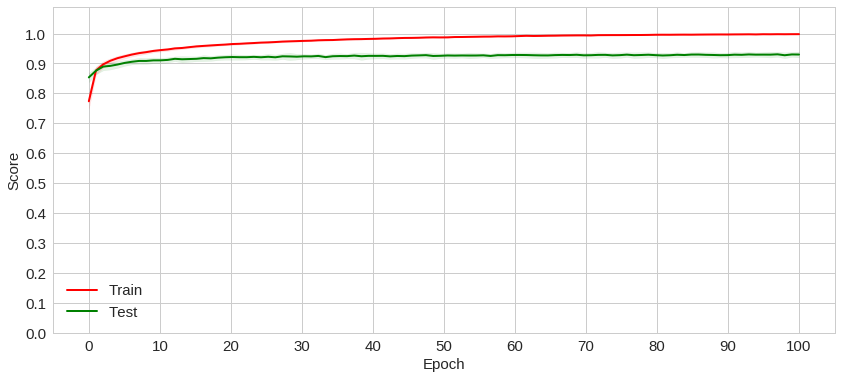

In [69]:
plot_mean_acc(tophist)

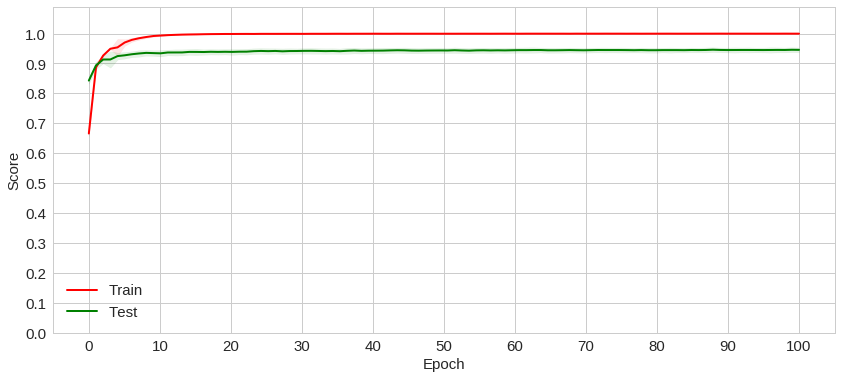

In [70]:
plot_mean_acc(hist)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

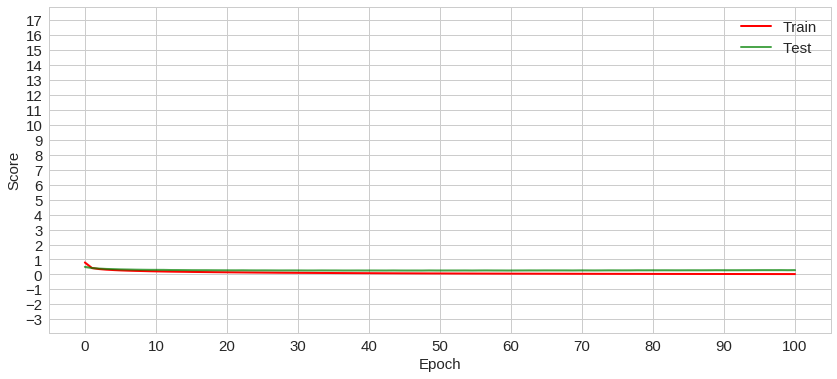

In [72]:
plot_mean_loss(tophist)

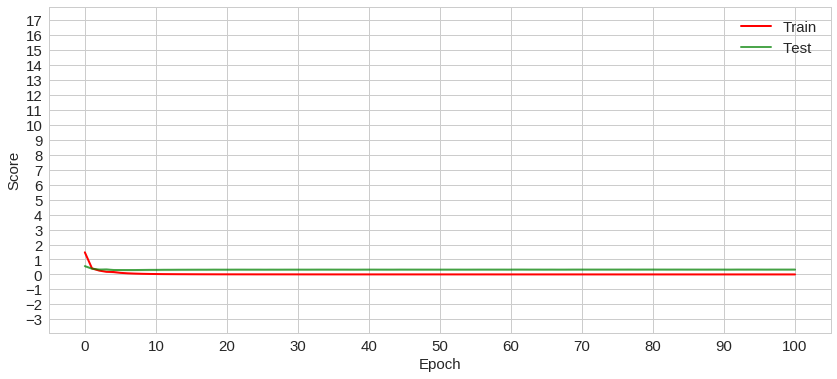

In [73]:
plot_mean_loss(hist)